In [ ]:
# [CELL 1] MOUNT DRIVE
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



=== Overall Summary (All Classes) ===
             width       height          area  aspect_ratio
count  9418.000000  9418.000000  9.418000e+03   9418.000000
mean    111.730659   125.213224  5.624431e+04      1.904565
std     348.113921   432.419597  2.700947e+05      2.952542
min       3.160000     2.550000  1.188000e+01      0.030637
25%       6.885000     7.090000  4.955800e+01      0.862319
50%      16.165000    15.950000  3.863036e+02      1.000000
75%      90.482500    76.767500  3.581480e+03      1.143934
max    5575.030000  5590.000000  5.049811e+06     40.887730


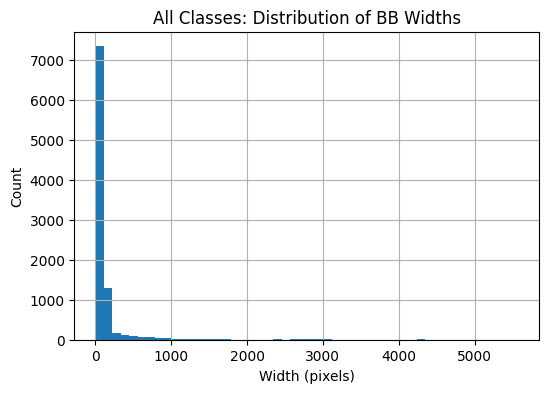

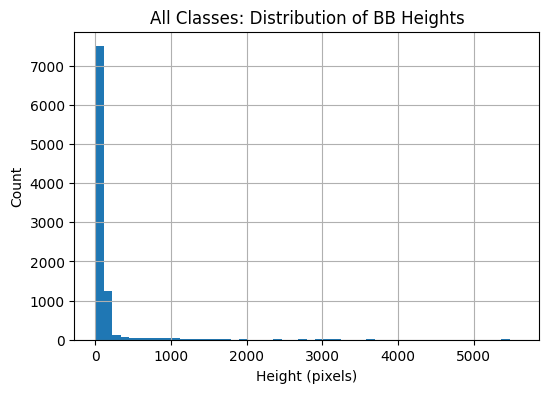

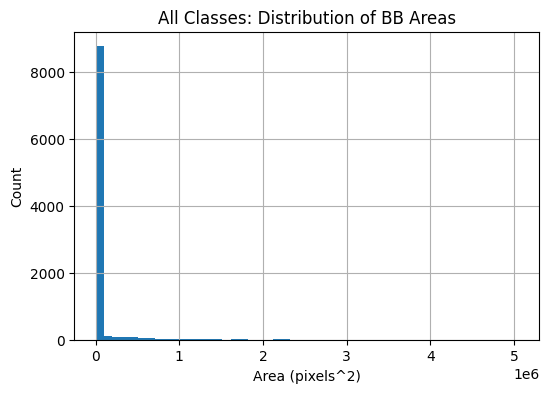

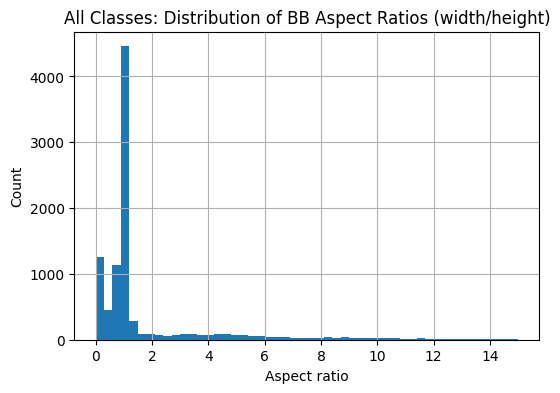


=== Per-Class Statistics ===

--- Class 0 => 5756 bounding boxes ---
             width       height          area  aspect_ratio
count  5756.000000  5756.000000   5756.000000   5756.000000
mean     28.822590    28.810853   3092.774835      1.001104
std      48.003636    47.832541   8884.104861      0.137875
min       3.160000     2.550000     11.880000      0.346487
25%       5.930000     6.130000     36.698000      0.935093
50%       8.455000     8.720000     73.463200      1.000000
75%      18.680000    17.945000    333.657675      1.057041
max     273.280000   286.420000  76179.532800      3.623385


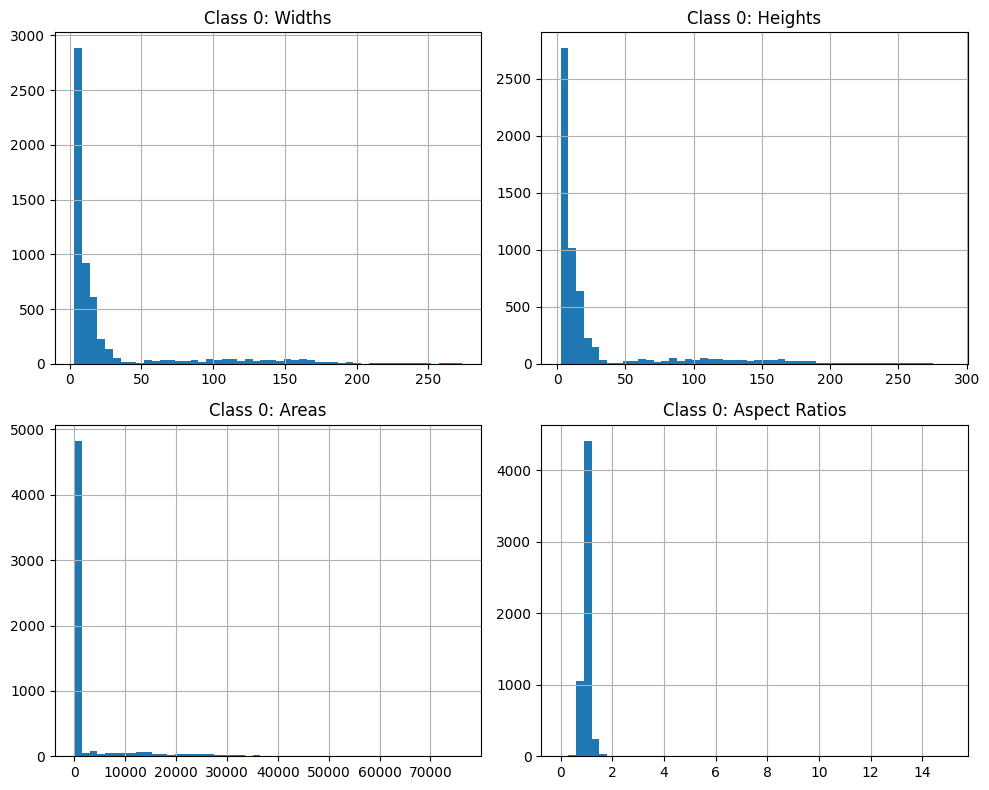


--- Class 1 => 3662 bounding boxes ---
             width       height          area  aspect_ratio
count  3662.000000  3662.000000  3.662000e+03   3662.000000
mean    242.047111   276.740270  1.397889e+05      3.324643
std     529.430711   663.175175  4.196439e+05      4.369576
min       4.560000     4.190000  6.376700e+01      0.030637
25%      20.415000    19.790000  9.140713e+02      0.208903
50%      60.020000    51.210000  2.728989e+03      1.215171
75%     180.175000   166.275000  8.733756e+03      5.023632
max    5575.030000  5590.000000  5.049811e+06     40.887730


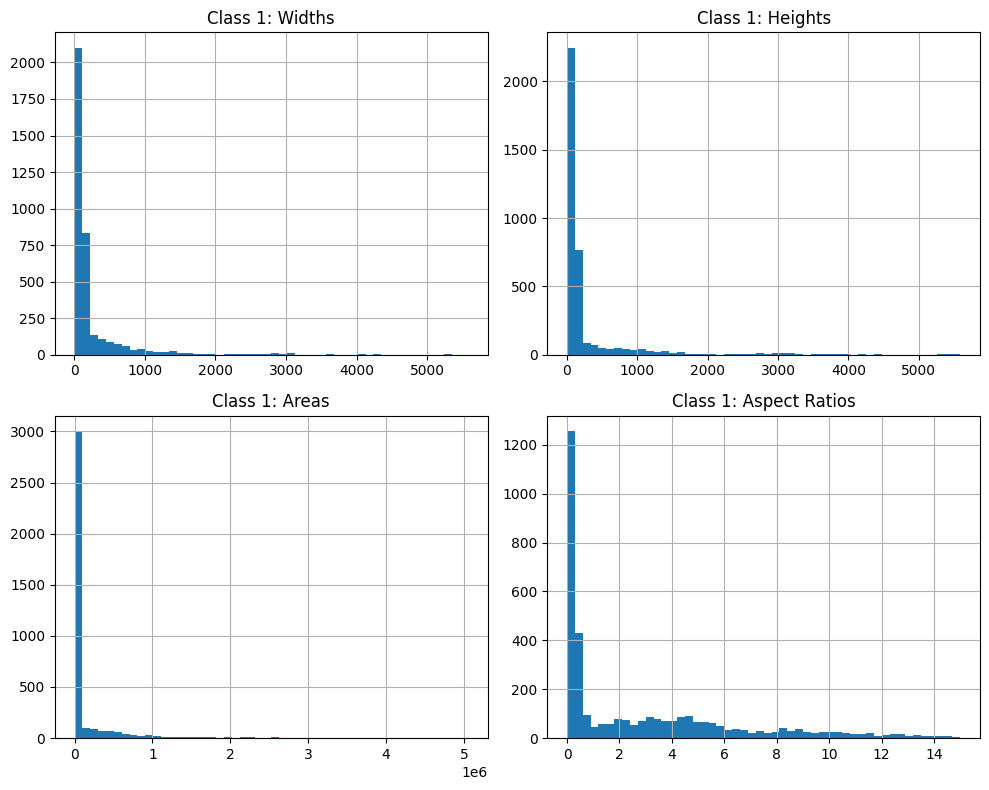

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Update this path if necessary:
CSV_PATH = "/content/drive/MyDrive/exp_retina_net/labels/merged_dataset.csv"

def analyze_bounding_boxes_by_class(csv_path):
    # Read the CSV.
    # If your data is comma-separated and includes a header row, this works directly.
    # Otherwise, adjust 'sep=' or 'names=[...]' as needed.
    df = pd.read_csv(csv_path)

    # Ensure required columns exist: x_min, y_min, x_max, y_max, class_idx
    required_cols = ["x_min","y_min","x_max","y_max","class_idx"]
    if not all(c in df.columns for c in required_cols):
        raise ValueError(f"CSV must contain columns: {required_cols}")

    # Compute width, height, area, aspect ratio
    df["width"]  = df["x_max"] - df["x_min"]
    df["height"] = df["y_max"] - df["y_min"]
    df["area"]   = df["width"] * df["height"]
    df["aspect_ratio"] = df["width"] / (df["height"] + 1e-9)  # Avoid division by zero

    # 1) Print overall summary stats
    print("\n=== Overall Summary (All Classes) ===")
    print(df[["width","height","area","aspect_ratio"]].describe())

    # 2) Overall histograms (all classes combined)
    plt.figure(figsize=(6,4))
    df["width"].hist(bins=50)
    plt.title("All Classes: Distribution of BB Widths")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(6,4))
    df["height"].hist(bins=50)
    plt.title("All Classes: Distribution of BB Heights")
    plt.xlabel("Height (pixels)")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(6,4))
    df["area"].hist(bins=50)
    plt.title("All Classes: Distribution of BB Areas")
    plt.xlabel("Area (pixels^2)")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(6,4))
    df["aspect_ratio"].hist(bins=50, range=(0,15))
    plt.title("All Classes: Distribution of BB Aspect Ratios (width/height)")
    plt.xlabel("Aspect ratio")
    plt.ylabel("Count")
    plt.show()

    # 3) Group by class => stats/histograms
    class_list = df["class_idx"].unique()
    print("\n=== Per-Class Statistics ===")

    for cls_ in sorted(class_list):
        subdf = df[df["class_idx"] == cls_]
        n = len(subdf)
        print(f"\n--- Class {cls_} => {n} bounding boxes ---")
        if n == 0:
            continue

        # Show descriptive stats
        print(subdf[["width","height","area","aspect_ratio"]].describe())

        # Histograms for this class
        fig, axes = plt.subplots(2, 2, figsize=(10,8))
        axes = axes.flatten()

        subdf["width"].hist(bins=50, ax=axes[0])
        axes[0].set_title(f"Class {cls_}: Widths")

        subdf["height"].hist(bins=50, ax=axes[1])
        axes[1].set_title(f"Class {cls_}: Heights")

        subdf["area"].hist(bins=50, ax=axes[2])
        axes[2].set_title(f"Class {cls_}: Areas")

        subdf["aspect_ratio"].hist(bins=50, range=(0,15), ax=axes[3])
        axes[3].set_title(f"Class {cls_}: Aspect Ratios")

        plt.tight_layout()
        plt.show()


# Run the analysis
analyze_bounding_boxes_by_class(CSV_PATH)


In [ ]:
#####################################################################################################
#####################################################################################################
#####################################################################################################
#                                         Stastics for classes

#####################################################################################################
#####################################################################################################
#####################################################################################################


import json
import pycocotools
from   pycocotools.coco import COCO
import pandas as pd
import matplotlib.pyplot as plt

JSON_PATH = "/content/drive/MyDrive/exp_retina_net/labels/merged_coco.json"

def analyze_coco_bboxes(json_path):
    """
    Reads a COCO-style JSON file, merges image (width, height) and annotation data,
    and computes bounding-box stats (both raw pixel sizes + normalized).
    """

    # 1) Load COCO
    coco = COCO(json_path)

    # 2) Build a list of rows, one per annotation
    rows = []
    ann_ids = coco.getAnnIds()
    ann_list= coco.loadAnns(ann_ids)

    for ann in ann_list:
        image_id   = ann["image_id"]
        cat_id     = ann["category_id"]
        x, y, w, h = ann["bbox"]

        # x_min, x_max, etc. in absolute pixels
        x_min = x
        y_min = y
        x_max = x + w
        y_max = y + h

        # Retrieve the image info from coco.imgs
        img_info = coco.imgs[image_id]
        img_w    = img_info["width"]
        img_h    = img_info["height"]
        file_name= img_info["file_name"]

        # Build row
        rows.append({
            "image_id":     image_id,
            "file_name":    file_name,
            "image_width":  img_w,
            "image_height": img_h,
            "x_min":        x_min,
            "y_min":        y_min,
            "x_max":        x_max,
            "y_max":        y_max,
            "class_idx":    cat_id
        })

    # 3) Convert to DataFrame
    df = pd.DataFrame(rows)
    print(f"[INFO] Created DataFrame with {len(df)} annotations from {len(coco.imgs)} images.")

    # 4) Compute bounding-box stats
    df["bb_width"]  = df["x_max"] - df["x_min"]
    df["bb_height"] = df["y_max"] - df["y_min"]
    df["bb_area"]   = df["bb_width"] * df["bb_height"]
    df["bb_aspect_ratio"] = df["bb_width"] / (df["bb_height"] + 1e-9)

    # Normalized to image dimensions
    df["bb_width_norm"]  = df["bb_width"]  / (df["image_width"] + 1e-9)
    df["bb_height_norm"] = df["bb_height"] / (df["image_height"] + 1e-9)
    df["bb_area_norm"]   = df["bb_area"]   / ((df["image_width"]*df["image_height"]) + 1e-9)

    # 5) Overall summary
    print("\n=== Overall Summary (Raw Pixels) ===")
    print(df[["bb_width","bb_height","bb_area","bb_aspect_ratio"]].describe())

    print("\n=== Overall Summary (Normalized) ===")
    print(df[["bb_width_norm","bb_height_norm","bb_area_norm"]].describe())

    # 6) Histograms (all classes combined)
    plt.figure(figsize=(6,4))
    df["bb_width"].hist(bins=50)
    plt.title("All Classes: Distribution of BB Widths (px)")
    plt.xlabel("Width (px)")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(6,4))
    df["bb_height"].hist(bins=50)
    plt.title("All Classes: Distribution of BB Heights (px)")
    plt.xlabel("Height (px)")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(6,4))
    df["bb_area"].hist(bins=50)
    plt.title("All Classes: Distribution of BB Areas (px^2)")
    plt.xlabel("Area (px^2)")
    plt.ylabel("Count")
    plt.show()

    # Normalized histograms
    plt.figure(figsize=(6,4))
    df["bb_width_norm"].hist(bins=50)
    plt.title("All Classes: Norm BB Width (fraction of image)")
    plt.xlabel("Width normalized")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(6,4))
    df["bb_height_norm"].hist(bins=50)
    plt.title("All Classes: Norm BB Height (fraction of image)")
    plt.xlabel("Height normalized")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(6,4))
    df["bb_area_norm"].hist(bins=50)
    plt.title("All Classes: Norm BB Area (fraction of image)")
    plt.xlabel("Area normalized")
    plt.ylabel("Count")
    plt.show()

    # 7) Per-Class stats
    class_list = sorted(df["class_idx"].unique())
    print("\n=== Per-Class Statistics (Raw + Normalized) ===")
    for cls_ in class_list:
        subdf = df[df["class_idx"] == cls_]
        n = len(subdf)
        print(f"\n--- Class {cls_} => {n} bounding boxes ---")
        if n == 0:
            continue

        # Show descriptive stats: raw
        print("Raw Pixel Stats:")
        print(subdf[["bb_width","bb_height","bb_area","bb_aspect_ratio"]].describe())

        # Show descriptive stats: normalized
        print("\nNormalized Stats:")
        print(subdf[["bb_width_norm","bb_height_norm","bb_area_norm"]].describe())

        # Histograms
        fig, axes = plt.subplots(2, 3, figsize=(15,10))
        axes = axes.flatten()

        subdf["bb_width"].hist(bins=50, ax=axes[0])
        axes[0].set_title(f"Class {cls_}: Raw BB Width")

        subdf["bb_height"].hist(bins=50, ax=axes[1])
        axes[1].set_title(f"Class {cls_}: Raw BB Height")

        subdf["bb_area"].hist(bins=50, ax=axes[2])
        axes[2].set_title(f"Class {cls_}: Raw BB Area")

        subdf["bb_width_norm"].hist(bins=50, ax=axes[3])
        axes[3].set_title(f"Class {cls_}: Norm BB Width")

        subdf["bb_height_norm"].hist(bins=50, ax=axes[4])
        axes[4].set_title(f"Class {cls_}: Norm BB Height")

        subdf["bb_area_norm"].hist(bins=50, ax=axes[5])
        axes[5].set_title(f"Class {cls_}: Norm BB Area")

        plt.tight_layout()
        plt.show()

    return df  # Return DataFrame if you want to do more analysis outside the function.

# Usage:
df_merged = analyze_coco_bboxes(JSON_PATH)


In [ ]:
#!/usr/bin/env python
"""
RetinaNet Training Script with:
 - Larger dataset (no artificial downsampling).
 - Automatic steps_per_epoch and val_steps based on dataset size & batch size.
 - Increased early stopping patience.
 - Possibly bigger batch size (adjust as needed).
 - Optionally remove or reduce augmentation for debugging stability.

This should provide a more "solid" training and validation loop,
reducing the huge step-to-step swings you saw earlier.
"""

################################################

################################################
#smaall loss long time per epoch
################################################

################################################


import os
import math
import json
import random
import numpy as np
import tensorflow as tf
from   tensorflow import keras
from   tensorflow.keras import layers
import matplotlib.pyplot as plt

# Mixed precision (optional)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
print("[INFO] Using mixed precision policy:", mixed_precision.global_policy())

try:
    import pycocotools
except ImportError:
    !pip install pycocotools
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


########################
# 0) User Configuration
########################
JSON_PATH   = "/content/drive/MyDrive/exp_retina_net/labels/merged_coco.json"
IMAGES_DIR  = "/content/drive/MyDrive/exp_retina_net/images"

TRAIN_SPLIT = 0.8
BATCH_SIZE  = 8      # Increase if you have the GPU memory, or keep small if not
EPOCHS      = 30     # More epochs for a bigger dataset
PATIENCE    = 10     # Higher patience so it won't stop too soon
REDUCE_LR_PATIENCE = 3  # We'll reduce LR if val loss stagnates for 3 epochs

IMG_HEIGHT  = 640
IMG_WIDTH   = 640

BASE_LR     = 2e-4   # Reasonable starting LR for fine-tuning
NUM_CLASSES = 3      # 0=background, 1=zip, 2=buttons

ASPECT_RATIOS = [0.5, 1.0, 2.0]
SCALES        = [0.5, 1.0, 2.0]
STRIDES       = [8,16,32]  # No P6 => drop 64 if not using add_p6

########################
# 1) Read the COCO JSON
########################
def load_coco_dataset(json_path):
    coco = COCO(json_path)
    img_ids = list(coco.imgs.keys())  # all image IDs
    return coco, img_ids

def split_image_ids(img_ids, train_split=0.8):
    random.shuffle(img_ids)
    n_train = int(len(img_ids)*train_split)
    return img_ids[:n_train], img_ids[n_train:]

########################
# 2) Simple TF dataset
########################
def read_image_and_boxes(coco_obj, image_id):
    img_info = coco_obj.imgs[image_id]
    fname    = img_info["file_name"]
    fullpath = os.path.join(IMAGES_DIR, fname)

    if not os.path.isfile(fullpath):
        # If file is missing, return a dummy image
        dummy_img   = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
        dummy_boxes = np.zeros((0,4), dtype=np.float32)
        dummy_cls   = np.zeros((0,),  dtype=np.int32)
        return dummy_img, dummy_boxes, dummy_cls

    raw  = tf.io.read_file(fullpath)
    img  = tf.image.decode_jpeg(raw, channels=3)
    img  = tf.cast(img, tf.float32)

    ann_ids = coco_obj.getAnnIds(imgIds=image_id)
    ann_list= coco_obj.loadAnns(ann_ids)

    boxes_list  = []
    classes_list= []
    for ann in ann_list:
        cat_id = ann["category_id"]  # e.g., 1=Zip,2=Buttons
        x,y,w,h = ann["bbox"]
        x2 = x+w
        y2 = y+h
        boxes_list.append([x,y,x2,y2])
        classes_list.append(cat_id)

    if len(boxes_list)==0:
        boxes_np   = np.zeros((0,4), dtype=np.float32)
        classes_np = np.zeros((0,),  dtype=np.int32)
    else:
        boxes_np   = np.array(boxes_list,   dtype=np.float32)
        classes_np = np.array(classes_list, dtype=np.int32)

    return img.numpy(), boxes_np, classes_np

def letterbox_resize(img_tf, boxes_np, target_h=640, target_w=640):
    h = tf.shape(img_tf)[0]
    w = tf.shape(img_tf)[1]
    h_ = tf.cast(h, tf.float32)
    w_ = tf.cast(w, tf.float32)
    scale = tf.minimum(target_w/w_, target_h/h_)
    new_h = tf.cast(h_*scale, tf.int32)
    new_w = tf.cast(w_*scale, tf.int32)

    resized = tf.image.resize(img_tf, (new_h,new_w))
    padded  = tf.image.pad_to_bounding_box(resized, 0,0, target_h, target_w)

    boxes_scaled = boxes_np * scale
    return padded, boxes_scaled

def random_horizontal_flip(img_tf, boxes_tf, classes_tf):
    # If you want *no augmentation*, comment this entire function call out
    coin_flip = tf.random.uniform([])
    do_flip   = coin_flip < 0.5

    def flip_image_and_boxes():
        flipped_img = tf.image.flip_left_right(img_tf)
        x1 = 640.0 - boxes_tf[:, 2]
        y1 = boxes_tf[:, 1]
        x2 = 640.0 - boxes_tf[:, 0]
        y2 = boxes_tf[:, 3]
        flipped_boxes = tf.stack([x1, y1, x2, y2], axis=-1)
        return flipped_img, flipped_boxes, classes_tf

    def no_flip():
        return img_tf, boxes_tf, classes_tf

    return tf.cond(do_flip, flip_image_and_boxes, no_flip)

def build_tf_dataset(coco_obj, img_ids, batch_size=4, shuffle=True):
    def gen():
        if shuffle:
            random.shuffle(img_ids)
        for iid in img_ids:
            img_np, boxes_np, classes_np = read_image_and_boxes(coco_obj, iid)
            img_tf, boxes_np = letterbox_resize(img_np, boxes_np,
                target_h=IMG_HEIGHT, target_w=IMG_WIDTH)
            boxes_tf = tf.convert_to_tensor(boxes_np, dtype=tf.float32)
            classes_tf = tf.convert_to_tensor(classes_np, dtype=tf.int32)

            # If you want to remove data augmentation for debugging, comment out:
            if shuffle:
                img_tf, boxes_tf, classes_tf = random_horizontal_flip(
                    img_tf, boxes_tf, classes_tf
                )
            img_tf = img_tf / 255.0
            img_tf = tf.cast(img_tf, tf.float16)
            yield (img_tf, boxes_tf, classes_tf)

    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float16, tf.float32, tf.int32),
        output_shapes=(
            (IMG_HEIGHT, IMG_WIDTH, 3),
            (None, 4),
            (None,)
        )
    )

    ds = ds.padded_batch(
        batch_size,
        padded_shapes=(
            (IMG_HEIGHT, IMG_WIDTH, 3),
            (None, 4),
            (None,)
        ),
        padding_values=(
            tf.constant(0.0, dtype=tf.float16),
            tf.constant(0.0, dtype=tf.float32),
            -1
        ),
        drop_remainder=False
    )

    ds = ds.repeat()  # So we can keep calling next(iter(...))
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

########################
# 3) Build the Model
########################
def get_backbone():
    bb = keras.applications.ResNet50(
        include_top=False,
        input_shape=(IMG_HEIGHT,IMG_WIDTH,3),
        weights="imagenet"
    )
    # Freeze first 80 layers, unfreeze the rest
    for layer in bb.layers[:10]:
        layer.trainable=False
    for layer in bb.layers[10:]:
        layer.trainable=True
    return bb

def build_head(num_classes, num_anchors):
    x_in= layers.Input(shape=(None,None,256))
    x= x_in
    for _ in range(4):
        x= layers.Conv2D(256,3,padding="same",activation="relu")(x)
    out= layers.Conv2D(num_anchors*(4 + num_classes), 3,
                       padding="same", dtype="float32")(x)
    return keras.Model(x_in, out)

def build_retinanet(num_classes=3, aspect_ratios=None, scales=None, add_p6=False):
    if aspect_ratios is None:
        aspect_ratios= ASPECT_RATIOS
    if scales is None:
        scales= SCALES

    bb= get_backbone()
    c3= bb.get_layer("conv3_block4_out").output
    c4= bb.get_layer("conv4_block6_out").output
    c5= bb.get_layer("conv5_block3_out").output

    # FPN
    P3= layers.Conv2D(256,1,padding="same")(c3)
    P4= layers.Conv2D(256,1,padding="same")(c4)
    P5= layers.Conv2D(256,1,padding="same")(c5)

    P4= layers.Add()([P4, layers.UpSampling2D()(P5)])
    P3= layers.Add()([P3, layers.UpSampling2D()(P4)])

    P3= layers.Conv2D(256,3,padding="same",activation="relu")(P3)
    P4= layers.Conv2D(256,3,padding="same",activation="relu")(P4)
    P5= layers.Conv2D(256,3,padding="same",activation="relu")(P5)

    feats = [P3,P4,P5]
    if add_p6:
        P6= layers.Conv2D(256,3,strides=2,padding="same",activation="relu")(P5)
        feats.append(P6)

    num_anchors= len(aspect_ratios)* len(scales)
    head= build_head(num_classes, num_anchors)
    c= 4 + num_classes
    outs=[]
    for f in feats:
        hf= head(f)
        hf= layers.Reshape((-1,c))(hf)
        outs.append(hf)
    final_out= layers.Concatenate(axis=1)(outs)
    model= keras.Model(bb.input, final_out, name="RetinaNetFPN")
    return model

############################
# 4) Detection Loss
############################
def iou(boxes_a, boxes_b):
    boxes_a= tf.expand_dims(boxes_a,1)
    boxes_b= tf.expand_dims(boxes_b,0)
    inter_x1= tf.maximum(boxes_a[...,0], boxes_b[...,0])
    inter_y1= tf.maximum(boxes_a[...,1], boxes_b[...,1])
    inter_x2= tf.minimum(boxes_a[...,2], boxes_b[...,2])
    inter_y2= tf.minimum(boxes_a[...,3], boxes_b[...,3])
    inter_w = tf.maximum(0.0, inter_x2 - inter_x1)
    inter_h = tf.maximum(0.0, inter_y2 - inter_y1)
    inter_area= inter_w * inter_h

    area_a= (boxes_a[...,2]-boxes_a[...,0])*(boxes_a[...,3]-boxes_a[...,1])
    area_b= (boxes_b[...,2]-boxes_b[...,0])*(boxes_b[...,3]-boxes_b[...,1])
    union= area_a + area_b - inter_area
    return tf.where(union>0, inter_area/union, 0.0)

def box_to_delta(anchors, gt_boxes):
    anc_wh= anchors[:,2:4] - anchors[:,0:2]
    anc_xy= anchors[:,0:2] + 0.5*anc_wh
    box_wh= gt_boxes[:,2:4] - gt_boxes[:,0:2]
    box_xy= gt_boxes[:,0:2] + 0.5*box_wh
    tx_ty = (box_xy - anc_xy)/ (anc_wh + 1e-7)
    tw_th = tf.math.log((box_wh/(anc_wh))+1e-7)
    return tf.concat([tx_ty, tw_th], axis=-1)

def match_anchors(anchors, gt_boxes, gt_classes, iou_thresh=0.4):
    A= tf.shape(anchors)[0]
    ious_ = iou(anchors, gt_boxes)
    best_iou= tf.reduce_max(ious_, axis=1)
    best_idx= tf.argmax(ious_, axis=1)
    pos_mask= best_iou > iou_thresh

    cls_t  = tf.zeros((A,), dtype=tf.int32)
    matched_gt= tf.gather(gt_classes, best_idx)
    cls_t = tf.where(pos_mask, matched_gt, cls_t)

    matched_boxes= tf.gather(gt_boxes, best_idx)
    deltas= box_to_delta(anchors, matched_boxes)
    deltas= tf.where(tf.expand_dims(pos_mask,1), deltas, tf.zeros_like(deltas))
    return cls_t, deltas

def focal_loss(logits, cls_targets, alpha=0.25, gamma=2.0, num_classes=3):
    logits = tf.cast(logits, tf.float32)
    cls_targets_1hot = tf.one_hot(cls_targets, depth=num_classes, dtype=tf.float32)
    log_prob = tf.nn.log_softmax(logits, axis=-1)
    prob     = tf.nn.softmax(logits, axis=-1)

    pt     = tf.reduce_sum(prob * cls_targets_1hot, axis=-1)
    log_pt = tf.reduce_sum(log_prob * cls_targets_1hot, axis=-1)

    alpha_t= tf.where(tf.equal(cls_targets, 0), 1.0 - alpha, alpha)
    focal  = -alpha_t * tf.pow((1.0 - pt), gamma)* log_pt
    return focal

def smooth_l1_loss(pred_box, tgt_box, sigma=1.0):
    diff= pred_box - tgt_box
    abs_diff= tf.abs(diff)
    sq_diff = 0.5*(diff**2)*(1.0/(sigma**2))
    l1= tf.where(abs_diff< (1.0/(sigma**2)), sq_diff, abs_diff- 0.5/(sigma**2))
    return tf.reduce_sum(l1, axis=-1)

def detection_loss(logits, anchors, gt_boxes, gt_classes):
    B= tf.shape(logits)[0]
    A= tf.shape(logits)[1]
    box_pred= tf.cast(logits[..., :4], tf.float32)
    cls_pred= tf.cast(logits[..., 4:], tf.float32)

    total_cls_loss= 0.0
    total_box_loss= 0.0

    for b_idx in range(B):
        boxes_b = gt_boxes[b_idx]
        classes_b= gt_classes[b_idx]
        valid_mask= tf.where(classes_b>=0)
        boxes_b= tf.gather_nd(boxes_b, valid_mask)
        classes_b= tf.gather_nd(classes_b, valid_mask)

        if tf.shape(boxes_b)[0]==0:
            zero_t= tf.zeros((A,), dtype=tf.int32)
            fl= focal_loss(cls_pred[b_idx], zero_t,
                           alpha=0.25,gamma=2.0, num_classes=3)
            total_cls_loss += tf.reduce_mean(fl)
            continue

        cls_targets_b, box_targets_b= match_anchors(
            anchors, boxes_b, classes_b, iou_thresh=0.4
        )
        fl= focal_loss(cls_pred[b_idx], cls_targets_b,
                       alpha=0.25, gamma=2.0, num_classes=3)

        pos_mask= tf.where(cls_targets_b>0)
        box_pred_pos= tf.gather_nd(box_pred[b_idx], pos_mask)
        box_tgt_pos= tf.gather_nd(box_targets_b, pos_mask)
        sl1= smooth_l1_loss(box_pred_pos, box_tgt_pos)

        pos_count= tf.cast(tf.shape(pos_mask)[0], tf.float32)
        cls_loss_img= tf.reduce_sum(fl)/(pos_count+1.0)
        box_loss_img= tf.reduce_sum(sl1)/(pos_count+1.0)
        total_cls_loss  += cls_loss_img
        total_box_loss  += box_loss_img

    return total_cls_loss + total_box_loss, total_cls_loss, total_box_loss

############################
# 5) Training loop
############################
@tf.function
def train_step(images, boxes, classes, anchors, model, optimizer):
    with tf.GradientTape() as tape:
        logits= model(images, training=True)
        loss_val, cls_l, box_l= detection_loss(logits, anchors, boxes, classes)
    grads= tape.gradient(loss_val, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_val, cls_l, box_l

@tf.function
def val_step(images, boxes, classes, anchors, model):
    logits= model(images, training=False)
    loss_val, cls_l, box_l= detection_loss(logits, anchors, boxes, classes)
    return loss_val, cls_l, box_l

############################
# 6) Build anchors
############################
def generate_anchors(aspect_ratios, scales, strides, h=640, w=640):
    anchors_all=[]
    for stride in strides:
        fh= h//stride
        fw= w//stride
        rx= tf.range(fw, dtype=tf.float32)+0.5
        ry= tf.range(fh, dtype=tf.float32)+0.5
        cx= rx*stride
        cy= ry*stride
        cx_grid, cy_grid= tf.meshgrid(cx,cy)
        cx_grid= tf.reshape(cx_grid, [-1])
        cy_grid= tf.reshape(cy_grid, [-1])

        widths=[]
        heights=[]
        for s in scales:
            for ar in aspect_ratios:
                anchor_w= stride*s*tf.sqrt(ar)
                anchor_h= stride*s / tf.sqrt(ar)
                widths.append(anchor_w)
                heights.append(anchor_h)
        widths= tf.stack(widths)
        heights= tf.stack(heights)
        tile_count= fh*fw
        widths_grid= tf.tile(widths, [tile_count])
        heights_grid=tf.tile(heights,[tile_count])
        cx_grid_rep=tf.repeat(cx_grid, repeats=len(widths))
        cy_grid_rep=tf.repeat(cy_grid, repeats=len(heights))

        x1= cx_grid_rep - 0.5*widths_grid
        y1= cy_grid_rep - 0.5*heights_grid
        x2= cx_grid_rep + 0.5*widths_grid
        y2= cy_grid_rep + 0.5*heights_grid
        anchors_stride= tf.stack([x1,y1,x2,y2], axis=1)
        anchors_all.append(anchors_stride)
    anchors_all= tf.concat(anchors_all, axis=0)
    return anchors_all

############################
# 7) Main Pipeline
############################
def main():
    # 1) Load COCO => split
    coco_obj, img_ids_all = load_coco_dataset(JSON_PATH)
    train_ids, val_ids = split_image_ids(img_ids_all, train_split=TRAIN_SPLIT)
    print(f"[INFO] #train={len(train_ids)}, #val={len(val_ids)}")

    # 2) dataset => no artificial downsampling
    train_ds= build_tf_dataset(coco_obj, train_ids,
                               batch_size=BATCH_SIZE,
                               shuffle=True)
    val_ds  = build_tf_dataset(coco_obj, val_ids,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

    # We'll compute steps automatically
    steps_per_epoch = math.ceil(len(train_ids) / BATCH_SIZE)
    val_steps       = math.ceil(len(val_ids) / BATCH_SIZE)
    print(f"[INFO] steps_per_epoch={steps_per_epoch}, val_steps={val_steps}")

    # 3) Build model
    model= build_retinanet(
        num_classes=NUM_CLASSES,
        aspect_ratios=ASPECT_RATIOS,
        scales=SCALES,
        add_p6=False
    )
    model.summary()

    # 4) Anchors
    anchors= generate_anchors(
        ASPECT_RATIOS,
        SCALES,
        STRIDES,
        h=IMG_HEIGHT,
        w=IMG_WIDTH
    )
    anchors= tf.constant(anchors, dtype=tf.float32)

    # 5) optimizer
    optimizer= tf.keras.optimizers.Adam(learning_rate=BASE_LR)

    best_val_loss= 999999.0
    patience_count= 0
    improvement_stagnation_count= 0

    for epoch in range(EPOCHS):
        print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")

        # training
        avg_train= 0.0
        train_iter = iter(train_ds)
        for step_i in range(steps_per_epoch):
            batch= next(train_iter)
            imgs, boxes, classes= batch
            loss_val, cls_l, box_l= train_step(imgs, boxes, classes,
                                               anchors, model, optimizer)
            avg_train += loss_val.numpy()
            if step_i % 10 == 0:
                print(f"  step={step_i} => loss={loss_val.numpy():.3f} "
                      f"(cls={cls_l.numpy():.3f}, box={box_l.numpy():.3f})")
        avg_train /= steps_per_epoch
        print(f"[Epoch {epoch+1}] train avg loss={avg_train:.3f}")

        # val
        avg_val= 0.0
        val_iter = iter(val_ds)
        for v_i in range(val_steps):
            vb= next(val_iter)
            vimgs, vboxes, vclss= vb
            v_loss, vc, vb_ = val_step(vimgs, vboxes, vclss, anchors, model)
            avg_val += v_loss.numpy()
        avg_val/=val_steps
        print(f"[Epoch {epoch+1}] val avg loss={avg_val:.3f}")

        # LR schedule & early stop
        if avg_val < best_val_loss:
            best_val_loss= avg_val
            patience_count= 0
            improvement_stagnation_count= 0
            print(" [INFO] new best => reset patience=0, improvement_stagnation_count=0")
        else:
            patience_count+=1
            improvement_stagnation_count+=1
            print(f" [INFO] no improvement => {patience_count}/{PATIENCE}; "
                  f"stagnation={improvement_stagnation_count}/{REDUCE_LR_PATIENCE}")

            # If we've stagnated for `REDUCE_LR_PATIENCE` => reduce LR
            if improvement_stagnation_count >= REDUCE_LR_PATIENCE:
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * 0.5
                optimizer.learning_rate.assign(new_lr)
                improvement_stagnation_count= 0
                print(f" [INFO] LR plateau => Reduced from {old_lr:.2e} to {new_lr:.2e}")

            # Check early stopping
            if patience_count>= PATIENCE:
                print("[EarlyStop] done.")
                break

    print("[INFO] Done training.")
    print("With a larger dataset, more steps per epoch, bigger patience, and a suitable batch size, "
          "you should see more consistent training & validation curves.")


if __name__=="__main__":
    main()


KeyboardInterrupt: 

In [ ]:
#!/usr/bin/env python
"""
RetinaNet Training Script with:
 - Larger dataset (no artificial downsampling).
 - Automatic steps_per_epoch and val_steps based on dataset size & batch size.
 - Increased early stopping patience.
 - Possibly bigger batch size (adjust as needed).
 - Optionally remove or reduce augmentation for debugging stability.
 - Saves final model weights.
 - Runs inference on 20 random validation images afterward.

NOW ADDS from the 700-epoch code:
 - Store training history for each epoch (classification & box losses).
 - Save weights every 5 epochs.
 - Final COCO evaluation => produces val_dt.json + prints mAP.
 - Plots training/validation loss curves at end.
 - Confusion matrix & F1 curve vs. confidence threshold.
"""

import os
import math
import json
import random
import numpy as np
import tensorflow as tf
from   tensorflow import keras
from   tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2  # For bounding-box drawing in inference

# Mixed precision (optional)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
print("[INFO] Using mixed precision policy:", mixed_precision.global_policy())

try:
    import pycocotools
except ImportError:
    !pip install pycocotools

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

########################
# 0) User Configuration
########################
JSON_PATH   = "/content/drive/MyDrive/exp_retina_net/labels/merged_coco.json"
IMAGES_DIR  = "/content/drive/MyDrive/exp_retina_net/images"

TRAIN_SPLIT = 0.8
BATCH_SIZE  = 128       # Adjust as needed
EPOCHS      = 15
PATIENCE    = 5         # Early-stop patience
REDUCE_LR_PATIENCE = 3

IMG_HEIGHT  = 512
IMG_WIDTH   = 512

BASE_LR     = 5e-4
NUM_CLASSES = 3  # 0=background,1=zip,2=buttons

ASPECT_RATIOS = [0.5, 1.0, 2.0]
SCALES        = [0.5, 1.0, 2.0]
STRIDES       = [8,16,32]  # no P6 => ignoring stride=64

SAVE_WEIGHTS_DIR = "/content/drive/MyDrive/exp_retina_net/weights"
os.makedirs(SAVE_WEIGHTS_DIR, exist_ok=True)

INFERENCE_RESULTS_DIR = "/content/drive/MyDrive/exp_retina_net/labels/results"
os.makedirs(INFERENCE_RESULTS_DIR, exist_ok=True)

########################
# 1) Read the COCO JSON
########################
def load_coco_dataset(json_path):
    coco = COCO(json_path)
    img_ids = list(coco.imgs.keys())  # all image IDs
    return coco, img_ids

def split_image_ids(img_ids, train_split=0.8):
    random.shuffle(img_ids)
    n_train = int(len(img_ids)*train_split)
    return img_ids[:n_train], img_ids[n_train:]

########################
# 2) Simple TF dataset
########################
def read_image_and_boxes(coco_obj, image_id):
    img_info = coco_obj.imgs[image_id]
    fname    = img_info["file_name"]
    fullpath = os.path.join(IMAGES_DIR, fname)

    if not os.path.isfile(fullpath):
        # If file is missing, return a dummy image
        dummy_img   = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
        dummy_boxes = np.zeros((0,4), dtype=np.float32)
        dummy_cls   = np.zeros((0,),  dtype=np.int32)
        return dummy_img, dummy_boxes, dummy_cls

    raw  = tf.io.read_file(fullpath)
    img  = tf.image.decode_jpeg(raw, channels=3)
    img  = tf.cast(img, tf.float32)

    ann_ids = coco_obj.getAnnIds(imgIds=image_id)
    ann_list= coco_obj.loadAnns(ann_ids)

    boxes_list  = []
    classes_list= []
    for ann in ann_list:
        cat_id = ann["category_id"]
        x,y,w,h = ann["bbox"]
        x2 = x+w
        y2 = y+h
        boxes_list.append([x,y,x2,y2])
        classes_list.append(cat_id)

    if len(boxes_list)==0:
        boxes_np   = np.zeros((0,4), dtype=np.float32)
        classes_np = np.zeros((0,),  dtype=np.int32)
    else:
        boxes_np   = np.array(boxes_list,   dtype=np.float32)
        classes_np = np.array(classes_list, dtype=np.int32)

    return img.numpy(), boxes_np, classes_np

def letterbox_resize(img_tf, boxes_np, target_h=640, target_w=640):
    h = tf.shape(img_tf)[0]
    w = tf.shape(img_tf)[1]
    h_ = tf.cast(h, tf.float32)
    w_ = tf.cast(w, tf.float32)
    scale = tf.minimum(target_w/w_, target_h/h_)
    new_h = tf.cast(h_*scale, tf.int32)
    new_w = tf.cast(w_*scale, tf.int32)

    resized = tf.image.resize(img_tf, (new_h,new_w))
    padded  = tf.image.pad_to_bounding_box(resized, 0,0, target_h, target_w)

    boxes_scaled = boxes_np * scale
    return padded, boxes_scaled

def random_horizontal_flip(img_tf, boxes_tf, classes_tf):
    coin_flip = tf.random.uniform([])
    do_flip   = coin_flip < 0.5

    def flip_image_and_boxes():
        flipped_img = tf.image.flip_left_right(img_tf)
        x1 = 512.0 - boxes_tf[:, 2]
        y1 = boxes_tf[:, 1]
        x2 = 512.0 - boxes_tf[:, 0]
        y2 = boxes_tf[:, 3]
        flipped_boxes = tf.stack([x1, y1, x2, y2], axis=-1)
        return flipped_img, flipped_boxes, classes_tf

    def no_flip():
        return img_tf, boxes_tf, classes_tf

    return tf.cond(do_flip, flip_image_and_boxes, no_flip)

def build_tf_dataset(coco_obj, img_ids, batch_size=4, shuffle=True):
    def gen():
        if shuffle:
            random.shuffle(img_ids)
        for iid in img_ids:
            img_np, boxes_np, classes_np = read_image_and_boxes(coco_obj, iid)
            img_tf, boxes_np = letterbox_resize(
                img_np, boxes_np,
                target_h=IMG_HEIGHT, target_w=IMG_WIDTH
            )
            boxes_tf = tf.convert_to_tensor(boxes_np, dtype=tf.float32)
            classes_tf_ = tf.convert_to_tensor(classes_np, dtype=tf.int32)

            if shuffle:
                img_tf, boxes_tf, classes_tf_ = random_horizontal_flip(
                    img_tf, boxes_tf, classes_tf_
                )
            img_tf = img_tf / 255.0
            img_tf = tf.cast(img_tf, tf.float16)
            yield (img_tf, boxes_tf, classes_tf_)

    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float16, tf.float32, tf.int32),
        output_shapes=(
            (IMG_HEIGHT, IMG_WIDTH, 3),
            (None, 4),
            (None,)
        )
    )

    ds = ds.padded_batch(
        batch_size,
        padded_shapes=(
            (IMG_HEIGHT, IMG_WIDTH, 3),
            (None, 4),
            (None,)
        ),
        padding_values=(
            tf.constant(0.0, dtype=tf.float16),
            tf.constant(0.0, dtype=tf.float32),
            -1
        ),
        drop_remainder=False
    )

    ds = ds.repeat()
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

########################
# 3) Build the Model
########################
def get_backbone():
    bb = keras.applications.ResNet50(
        include_top=False,
        input_shape=(IMG_HEIGHT,IMG_WIDTH,3),
        weights="imagenet"
    )
    # Freeze first 100 layers => unfreeze the rest
    for layer in bb.layers[:990]:
        layer.trainable=False
    for layer in bb.layers[90:]:
        layer.trainable=True
    return bb

def build_head(num_classes, num_anchors):
    x_in= layers.Input(shape=(None,None,256))
    x= x_in
    for _ in range(4):
        x= layers.Conv2D(256,3,padding="same",activation="relu")(x)
    out= layers.Conv2D(num_anchors*(4 + num_classes), 3,
                       padding="same", dtype="float32")(x)
    return keras.Model(x_in, out)

def build_retinanet(num_classes=3, aspect_ratios=None, scales=None, add_p6=False):
    if aspect_ratios is None:
        aspect_ratios= ASPECT_RATIOS
    if scales is None:
        scales= SCALES

    bb= get_backbone()
    c3= bb.get_layer("conv3_block4_out").output
    c4= bb.get_layer("conv4_block6_out").output
    c5= bb.get_layer("conv5_block3_out").output

    # FPN
    P3= layers.Conv2D(256,1,padding="same")(c3)
    P4= layers.Conv2D(256,1,padding="same")(c4)
    P5= layers.Conv2D(256,1,padding="same")(c5)

    P4= layers.Add()([P4, layers.UpSampling2D()(P5)])
    P3= layers.Add()([P3, layers.UpSampling2D()(P4)])

    P3= layers.Conv2D(256,3,padding="same",activation="relu")(P3)
    P4= layers.Conv2D(256,3,padding="same",activation="relu")(P4)
    P5= layers.Conv2D(256,3,padding="same",activation="relu")(P5)

    feats = [P3,P4,P5]
    if add_p6:
        P6= layers.Conv2D(256,3,strides=2,padding="same",activation="relu")(P5)
        feats.append(P6)

    num_anchors= len(aspect_ratios)* len(scales)
    head= build_head(num_classes, num_anchors)
    c= 4+ num_classes
    outs=[]
    for f in feats:
        hf= head(f)
        hf= layers.Reshape((-1,c))(hf)
        outs.append(hf)
    final_out= layers.Concatenate(axis=1)(outs)
    model= keras.Model(bb.input, final_out, name="RetinaNetFPN")
    return model

############################
# 4) Detection Loss
############################
def iou(boxes_a, boxes_b):
    boxes_a= tf.expand_dims(boxes_a,1)
    boxes_b= tf.expand_dims(boxes_b,0)
    inter_x1= tf.maximum(boxes_a[...,0], boxes_b[...,0])
    inter_y1= tf.maximum(boxes_a[...,1], boxes_b[...,1])
    inter_x2= tf.minimum(boxes_a[...,2], boxes_b[...,2])
    inter_y2= tf.minimum(boxes_a[...,3], boxes_b[...,3])
    inter_w = tf.maximum(0.0, inter_x2 - inter_x1)
    inter_h = tf.maximum(0.0, inter_y2 - inter_y1)
    inter_area= inter_w* inter_h

    area_a= (boxes_a[...,2]-boxes_a[...,0])*(boxes_a[...,3]-boxes_a[...,1])
    area_b= (boxes_b[...,2]-boxes_b[...,0])*(boxes_b[...,3]-boxes_b[...,1])
    union= area_a+ area_b- inter_area
    return tf.where(union>0, inter_area/union, 0.0)

def box_to_delta(anchors, gt_boxes):
    anc_wh= anchors[:,2:4]- anchors[:,0:2]
    anc_xy= anchors[:,0:2]+ 0.5* anc_wh
    box_wh= gt_boxes[:,2:4]- gt_boxes[:,0:2]
    box_xy= gt_boxes[:,0:2]+ 0.5* box_wh
    tx_ty= (box_xy- anc_xy)/ (anc_wh+ 1e-7)
    tw_th= tf.math.log((box_wh/(anc_wh))+1e-7)
    return tf.concat([tx_ty, tw_th], axis=-1)

def match_anchors(anchors, gt_boxes, gt_classes, iou_thresh=0.4):
    A= tf.shape(anchors)[0]
    ious_= iou(anchors, gt_boxes)
    best_iou= tf.reduce_max(ious_, axis=1)
    best_idx= tf.argmax(ious_, axis=1)
    pos_mask= best_iou> iou_thresh

    cls_t= tf.zeros((A,), dtype=tf.int32)
    matched_gt= tf.gather(gt_classes, best_idx)
    cls_t= tf.where(pos_mask, matched_gt, cls_t)

    matched_boxes= tf.gather(gt_boxes, best_idx)
    deltas= box_to_delta(anchors, matched_boxes)
    deltas= tf.where(tf.expand_dims(pos_mask,1), deltas, tf.zeros_like(deltas))
    return cls_t, deltas

def focal_loss(logits, cls_targets, alpha=0.25, gamma=2.0, num_classes=3):
    logits= tf.cast(logits, tf.float32)
    cls_targets_1hot= tf.one_hot(cls_targets, depth=num_classes, dtype=tf.float32)
    log_prob= tf.nn.log_softmax(logits, axis=-1)
    prob= tf.nn.softmax(logits, axis=-1)

    pt= tf.reduce_sum(prob* cls_targets_1hot, axis=-1)
    log_pt= tf.reduce_sum(log_prob* cls_targets_1hot, axis=-1)

    alpha_t= tf.where(tf.equal(cls_targets,0), 1.0-alpha, alpha)
    focal= -alpha_t* tf.pow((1.0- pt), gamma)* log_pt
    return focal

def smooth_l1_loss(pred_box, tgt_box, sigma=1.0):
    diff= pred_box- tgt_box
    abs_diff= tf.abs(diff)
    sq_diff= 0.5*(diff**2)*(1.0/(sigma**2))
    l1= tf.where(abs_diff< (1.0/(sigma**2)), sq_diff, abs_diff- 0.5/(sigma**2))
    return tf.reduce_sum(l1, axis=-1)

def detection_loss(logits, anchors, gt_boxes, gt_classes):
    B= tf.shape(logits)[0]
    A= tf.shape(logits)[1]
    box_pred= tf.cast(logits[..., :4], tf.float32)
    cls_pred= tf.cast(logits[..., 4:], tf.float32)

    total_cls_loss= 0.0
    total_box_loss= 0.0

    for b_idx in range(B):
        boxes_b= gt_boxes[b_idx]
        classes_b= gt_classes[b_idx]
        valid_mask= tf.where(classes_b>=0)
        boxes_b= tf.gather_nd(boxes_b, valid_mask)
        classes_b= tf.gather_nd(classes_b, valid_mask)

        if tf.shape(boxes_b)[0]==0:
            zero_t= tf.zeros((A,), dtype=tf.int32)
            fl= focal_loss(cls_pred[b_idx], zero_t,
                           alpha=0.25,gamma=2.0,num_classes=3)
            total_cls_loss+= tf.reduce_mean(fl)
            continue

        cls_targets_b, box_targets_b= match_anchors(anchors, boxes_b, classes_b, iou_thresh=0.4)
        fl= focal_loss(cls_pred[b_idx], cls_targets_b, alpha=0.25,gamma=2.0,num_classes=3)

        pos_mask= tf.where(cls_targets_b>0)
        box_pred_pos= tf.gather_nd(box_pred[b_idx], pos_mask)
        box_tgt_pos= tf.gather_nd(box_targets_b, pos_mask)
        sl1= smooth_l1_loss(box_pred_pos, box_tgt_pos)

        pos_count= tf.cast(tf.shape(pos_mask)[0], tf.float32)
        cls_loss_img= tf.reduce_sum(fl)/(pos_count+1.0)
        box_loss_img= tf.reduce_sum(sl1)/(pos_count+1.0)
        total_cls_loss+= cls_loss_img
        total_box_loss+= box_loss_img

    return total_cls_loss+ total_box_loss, total_cls_loss, total_box_loss

############################
# 5) Training loop
############################
@tf.function
def train_step(images, boxes, classes, anchors, model, optimizer):
    with tf.GradientTape() as tape:
        logits= model(images, training=True)
        loss_val, cls_l, box_l= detection_loss(logits, anchors, boxes, classes)
    grads = tape.gradient(loss_val, model.trainable_variables)
    grads = [tf.clip_by_value(g, -1.0, 1.0) for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss_val, cls_l, box_l

@tf.function
def val_step(images, boxes, classes, anchors, model):
    logits= model(images, training=False)
    loss_val, cls_l, box_l= detection_loss(logits, anchors, boxes, classes)
    return loss_val, cls_l, box_l

############################
# 6) Build anchors
############################
def generate_anchors(aspect_ratios, scales, strides, h=640, w=640):
    anchors_all=[]
    for stride in strides:
        fh= h//stride
        fw= w//stride
        rx= tf.range(fw, dtype=tf.float32)+0.5
        ry= tf.range(fh, dtype=tf.float32)+0.5
        cx= rx*stride
        cy= ry*stride
        cx_grid, cy_grid= tf.meshgrid(cx,cy)
        cx_grid= tf.reshape(cx_grid, [-1])
        cy_grid= tf.reshape(cy_grid, [-1])

        widths=[]
        heights=[]
        for s in scales:
            for ar in aspect_ratios:
                anchor_w= stride*s*tf.sqrt(ar)
                anchor_h= stride*s/ tf.sqrt(ar)
                widths.append(anchor_w)
                heights.append(anchor_h)
        widths= tf.stack(widths)
        heights= tf.stack(heights)
        tile_count= fh*fw
        widths_grid= tf.tile(widths, [tile_count])
        heights_grid=tf.tile(heights,[tile_count])
        cx_grid_rep= tf.repeat(cx_grid, repeats=len(widths))
        cy_grid_rep= tf.repeat(cy_grid, repeats=len(heights))

        x1= cx_grid_rep- 0.5*widths_grid
        y1= cy_grid_rep- 0.5*heights_grid
        x2= cx_grid_rep+ 0.5*widths_grid
        y2= cy_grid_rep+ 0.5*heights_grid
        anchors_stride= tf.stack([x1,y1,x2,y2], axis=1)
        anchors_all.append(anchors_stride)
    anchors_all= tf.concat(anchors_all, axis=0)
    return anchors_all

############################
# 7) Basic decode & NMS for inference
############################
def decode_and_nms(model_logits, anchors, score_thresh=0.05, nms_iou=0.5):
    # B, A
    B = tf.shape(model_logits)[0]

    box_pred = model_logits[..., :4]     # likely float16 from the model
    cls_pred = model_logits[..., 4:]     # also float16
    # Convert these to float32:
    box_pred_f = tf.cast(box_pred, tf.float32)
    cls_pred_f = tf.cast(cls_pred, tf.float32)

    cls_prob = tf.nn.softmax(cls_pred_f, axis=-1)

    # anchors should already be float32:
    # anchors_f = tf.cast(anchors, tf.float32)
    # ... or you can enforce again if needed

    anc_wh = anchors[..., 2:4] - anchors[..., 0:2]
    anc_xy = anchors[..., 0:2] + 0.5 * anc_wh

    results = []
    for b_idx in range(B):
        # decode boxes
        box_delta = box_pred_f[b_idx]  # (A,4) float32
        box_xy = box_delta[:, 0:2] * anc_wh + anc_xy
        box_wh = tf.exp(box_delta[:, 2:4]) * anc_wh
        x1y1 = box_xy - 0.5 * box_wh
        x2y2 = box_xy + 0.5 * box_wh
        final_boxes = tf.concat([x1y1, x2y2], axis=-1)  # float32

        # classification
        prob_ = cls_prob[b_idx]  # (A, num_classes), float32
        prob_no_bg = prob_[:, 1:]  # ignoring index 0 => BG
        max_probs = tf.reduce_max(prob_no_bg, axis=-1)  # float32
        cls_ids = tf.argmax(prob_no_bg, axis=-1) + 1    # int

        keep_mask = max_probs > score_thresh
        sel_boxes = tf.boolean_mask(final_boxes, keep_mask)   # float32
        sel_scores = tf.boolean_mask(max_probs, keep_mask)    # float32
        sel_classes = tf.boolean_mask(cls_ids, keep_mask)     # int

        # Now tf.image.non_max_suppression => requires float32 boxes & scores
        # They are already float32, so no error here:
        nms_idx = tf.image.non_max_suppression(
            sel_boxes, sel_scores,
            max_output_size=200,
            iou_threshold=nms_iou,
            score_threshold=score_thresh
        )

        out_boxes = tf.gather(sel_boxes, nms_idx).numpy()
        out_scores = tf.gather(sel_scores, nms_idx).numpy()
        out_cls = tf.gather(sel_classes, nms_idx).numpy()

        results.append({
            "boxes": out_boxes,
            "scores": out_scores,
            "classes": out_cls
        })

    return results


############################
# 8) Inference on val images
############################
def run_inference_on_val_images(
    model, anchors, coco_obj, val_ids,
    images_dir, results_dir,
    num_images=20,
    img_height=640,
    img_width=640,
    score_thresh=0.05,
    nms_iou=0.5
):
    os.makedirs(results_dir,exist_ok=True)
    chosen_ids= random.sample(val_ids,min(len(val_ids),num_images))

    for iid in chosen_ids:
        img_info= coco_obj.imgs[iid]
        fname= img_info["file_name"]
        full_path= os.path.join(images_dir,fname)
        if not os.path.isfile(full_path):
            print(f"[WARNING] Missing {full_path}, skipping.")
            continue

        raw= tf.io.read_file(full_path)
        img_tf= tf.image.decode_jpeg(raw, channels=3)
        img_tf= tf.cast(img_tf,tf.float32)

        orig_h= tf.shape(img_tf)[0]
        orig_w= tf.shape(img_tf)[1]

        scale= tf.minimum(img_width/tf.cast(orig_w,tf.float32),
                          img_height/tf.cast(orig_h,tf.float32))
        new_h= tf.cast(tf.cast(orig_h,tf.float32)* scale, tf.int32)
        new_w= tf.cast(tf.cast(orig_w,tf.float32)* scale, tf.int32)

        resized= tf.image.resize(img_tf,(new_h,new_w))
        padded= tf.image.pad_to_bounding_box(resized,0,0,img_height,img_width)
        letter_img= padded/255.0
        letter_img= tf.cast(letter_img,tf.float16)[None,...]

        logits= model(letter_img,training=False)
        out_list= decode_and_nms(logits,anchors,score_thresh,nms_iou)
        out= out_list[0]

        letter_np= letter_img[0].numpy()
        letter_np= np.clip(letter_np*255.0,0,255).astype(np.uint8)

        boxes= out["boxes"]
        scores= out["scores"]
        clss= out["classes"]

        for i_det in range(len(boxes)):
            x1,y1,x2,y2= boxes[i_det]
            sc= scores[i_det]
            c_= int(clss[i_det])
            color= (0,255,0)
            cv2.rectangle(letter_np,(int(x1),int(y1)),(int(x2),int(y2)),color,2)
            label= f"cls{c_}:{sc:.2f}"
            cv2.putText(letter_np,label,
                        (int(x1),max(0,int(y1)-5)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,(255,255,0),1)

        out_name= os.path.splitext(fname)[0]+ "_pred.jpg"
        out_path= os.path.join(results_dir,out_name)
        letter_np_bgr= letter_np[...,::-1]
        cv2.imwrite(out_path,letter_np_bgr)
        print(f"[INFO] Wrote {out_path}")

    print("[INFO] Done. Inference on",len(chosen_ids),"val images =>",results_dir)

############################
# 9) COCO-style evaluation
############################
def generate_val_detections_in_memory(
    model, anchors, coco_obj, val_ids,
    images_dir,
    img_height=512, img_width=512,
    score_thresh=0.05, nms_iou=0.5
):
    dt_list = []
    for iid in val_ids:
        img_info = coco_obj.imgs[iid]
        fname    = img_info["file_name"]
        full_path= os.path.join(images_dir, fname)
        if not os.path.isfile(full_path):
            continue

        # Letterbox to (img_height x img_width)
        raw    = tf.io.read_file(full_path)
        img_tf = tf.image.decode_jpeg(raw, channels=3)
        img_tf = tf.cast(img_tf, tf.float32)
        orig_h = tf.shape(img_tf)[0]
        orig_w = tf.shape(img_tf)[1]

        scale = tf.minimum(img_width/tf.cast(orig_w,tf.float32),
                           img_height/tf.cast(orig_h,tf.float32))
        new_h = tf.cast(tf.cast(orig_h,tf.float32) * scale, tf.int32)
        new_w = tf.cast(tf.cast(orig_w,tf.float32) * scale, tf.int32)

        resized = tf.image.resize(img_tf, (new_h,new_w))
        padded  = tf.image.pad_to_bounding_box(
            resized, 0, 0, img_height, img_width
        )
        letter_img = padded / 255.0
        letter_img = tf.cast(letter_img, tf.float16)[None,...]

        # Run model => decode => nms
        logits = model(letter_img, training=False)
        out_list = decode_and_nms(
            logits,
            anchors,
            score_thresh=score_thresh,
            nms_iou=nms_iou
        )
        out = out_list[0]  # single batch

        # Fill dt_list in COCO format
        boxes   = out["boxes"]
        scores  = out["scores"]
        classes = out["classes"]
        for i_det in range(len(boxes)):
            x1,y1,x2,y2 = boxes[i_det]
            w_ = x2 - x1
            h_ = y2 - y1
            sc_ = float(scores[i_det])
            c_  = int(classes[i_det])  # 1=zip,2=button
            dt_list.append({
                "image_id":    int(iid),
                "category_id": c_,
                "bbox":        [float(x1), float(y1), float(w_), float(h_)],
                "score":       sc_
            })

    return dt_list

def evaluate_coco_map_in_memory(coco_gt, dt_list):
    # Pass the list of detections directly to loadRes(...)
    coco_dt   = coco_gt.loadRes(dt_list)    # No JSON file needed
    coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return coco_eval.stats[0]  # AP50:95



# === NEW CODE: For confusion matrix + F1 curve after training ===
def compute_confusion_matrix(dt_list, coco_obj, iou_threshold=0.5, score_threshold=0.25):
    """
    Build a 2x2 confusion matrix for classes [zip=1, buttons=2],
    ignoring background.
    - dt_list: list of dicts, each with {image_id, category_id, bbox, score}
    - We match each detection to a ground-truth if IoU>= iou_threshold
      and the detection's score >= score_threshold.
    - If matched, increment confMat[gtClass, predClass].
    - Unmatched detection => false positive
    - Unmatched ground truth => false negative
    """
    gt_dict = {}
    for img_id in coco_obj.imgs.keys():
        ann_ids = coco_obj.getAnnIds(imgIds=img_id)
        ann_list= coco_obj.loadAnns(ann_ids)
        boxes_list = []
        for ann in ann_list:
            cat_id = ann["category_id"]  # 1=zip,2=buttons
            if cat_id<1:
                continue
            x,y,w,h = ann["bbox"]
            x2= x+w
            y2= y+h
            boxes_list.append([x, y, x2, y2, cat_id])
        gt_dict[img_id] = boxes_list

    dt_by_img = {}
    for dt in dt_list:
        img_id = dt["image_id"]
        cat_id= dt["category_id"]
        score = dt["score"]
        x,y,w,h = dt["bbox"]
        x2= x+w
        y2= y+h
        if img_id not in dt_by_img:
            dt_by_img[img_id] = []
        dt_by_img[img_id].append([x,y,x2,y2,cat_id, score])

    confMat = np.zeros((2, 2), dtype=np.int32)

    for img_id, dt_items in dt_by_img.items():
        dt_items = [d for d in dt_items if d[5]>= score_threshold]
        dt_items.sort(key=lambda x: x[5], reverse=True)

        gt_items = gt_dict.get(img_id, [])
        matched_gt = set()

        for dt_box in dt_items:
            dx1, dy1, dx2, dy2, d_cls, d_score = dt_box
            best_iou = 0.0
            best_gt_idx = -1
            for gi, g in enumerate(gt_items):
                gx1, gy1, gx2, gy2, g_cls = g
                if gi in matched_gt:
                    continue
                inter_x1 = max(dx1, gx1)
                inter_y1 = max(dy1, gy1)
                inter_x2 = min(dx2, gx2)
                inter_y2 = min(dy2, gy2)
                inter_w  = max(0.0, inter_x2 - inter_x1)
                inter_h  = max(0.0, inter_y2 - inter_y1)
                interArea= inter_w*inter_h

                area_dt = (dx2-dx1)*(dy2-dy1)
                area_gt = (gx2-gx1)*(gy2-gy1)
                union   = area_dt + area_gt - interArea
                iou_val = interArea / union if union>0 else 0

                if iou_val> best_iou:
                    best_iou = iou_val
                    best_gt_idx = gi

            if best_iou>= iou_threshold and best_gt_idx>=0:
                g_cls = gt_items[best_gt_idx][4]
                matched_gt.add(best_gt_idx)
                confMat[g_cls-1, d_cls-1] += 1
            else:
                pass

        # unmatched GT => false negative (not shown in 2x2 matrix for BG)

    return confMat

def plot_confusion_matrix(confMat, class_names=("zip","button")):
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(confMat, cmap="Blues")

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Ground Truth")
    plt.title("Confusion Matrix")

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, confMat[i,j],
                    ha="center", va="center", color="red")
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

def compute_pr_curve(dt_list, coco_obj,
                     iou_threshold=0.3,
                     score_thresholds=np.linspace(0.0,1.0,101)):
    gt_dict = {}
    total_gt_count = 0
    for img_id in coco_obj.imgs.keys():
        ann_ids = coco_obj.getAnnIds(imgIds=img_id)
        ann_list= coco_obj.loadAnns(ann_ids)
        boxes_list = []
        for ann in ann_list:
            cat_id = ann["category_id"]
            if cat_id<1:
                continue
            x,y,w,h = ann["bbox"]
            x2= x+w
            y2= y+h
            boxes_list.append([x,y,x2,y2, cat_id])
        gt_dict[img_id] = boxes_list
        total_gt_count += len(boxes_list)

    dt_by_img = {}
    for dt in dt_list:
        img_id = dt["image_id"]
        cat_id= dt["category_id"]
        score = dt["score"]
        x,y,w,h = dt["bbox"]
        x2= x+w
        y2= y+h
        if img_id not in dt_by_img:
            dt_by_img[img_id] = []
        dt_by_img[img_id].append([x,y,x2,y2,cat_id, score])

    pr_data = []
    for thr in score_thresholds:
        tp= 0
        fp= 0
        fn= 0

        for img_id, dt_items in dt_by_img.items():
            dt_items_thr = [d for d in dt_items if d[5]>= thr]
            dt_items_thr.sort(key=lambda x: x[5], reverse=True)

            gt_items = gt_dict.get(img_id, [])
            matched_gt = set()

            for dt_box in dt_items_thr:
                dx1, dy1, dx2, dy2, d_cls, d_score = dt_box
                best_iou = 0.0
                best_gt_idx = -1
                for gi, g in enumerate(gt_items):
                    gx1, gy1, gx2, gy2, g_cls = g
                    if gi in matched_gt:
                        continue
                    inter_x1 = max(dx1, gx1)
                    inter_y1 = max(dy1, gy1)
                    inter_x2 = min(dx2, gx2)
                    inter_y2 = min(dy2, gy2)
                    inter_w  = max(0.0, inter_x2 - inter_x1)
                    inter_h  = max(0.0, inter_y2 - inter_y1)
                    interArea= inter_w*inter_h

                    area_dt = (dx2-dx1)*(dy2-dy1)
                    area_gt = (gx2-gx1)*(gy2-gy1)
                    union   = area_dt + area_gt - interArea
                    iou_val = interArea / union if union>0 else 0

                    if iou_val> best_iou:
                        best_iou = iou_val
                        best_gt_idx = gi

                if best_iou>= iou_threshold and best_gt_idx>=0:
                    tp+= 1
                    matched_gt.add(best_gt_idx)
                else:
                    fp+= 1

            fn+= (len(gt_items) - len(matched_gt))

        precision= tp/(tp+fp+1e-16)
        recall   = tp/(tp+fn+1e-16)
        f1       = 2*(precision*recall)/(precision+recall+1e-16)
        pr_data.append((thr, precision, recall, f1))

    return pr_data

def plot_f1_curve(pr_data):
    thresholds = [x[0] for x in pr_data]
    precisions = [x[1] for x in pr_data]
    recalls    = [x[2] for x in pr_data]
    f1s        = [x[3] for x in pr_data]

    plt.figure(figsize=(8,6))
    plt.plot(thresholds, precisions, label="Precision", color="blue")
    plt.plot(thresholds, recalls,    label="Recall",    color="green")
    plt.plot(thresholds, f1s,        label="F1",        color="red")
    plt.xlabel("Confidence Threshold")
    plt.ylabel("Metric Value")
    plt.title("Precision, Recall, F1 vs. Confidence Threshold")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_loss_curves(history_dict):
    epochs = range(1, len(history_dict['train_total'])+1)

    plt.figure(figsize=(10,6))
    plt.plot(epochs, history_dict['train_total'], label='Train Total Loss', color='blue')
    plt.plot(epochs, history_dict['val_total'],   label='Val Total Loss',   color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(epochs, history_dict['train_cls'], label='Train Cls Loss', color='blue')
    plt.plot(epochs, history_dict['train_box'], label='Train Box Loss', color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Classification & Box Loss")
    plt.grid(True)
    plt.legend()
    plt.show()


def main():
    # 1) Load dataset => split
    coco_obj, img_ids_all= load_coco_dataset(JSON_PATH)
    train_ids, val_ids   = split_image_ids(img_ids_all, train_split=TRAIN_SPLIT)
    print(f"[INFO] #train={len(train_ids)}, #val={len(val_ids)}")

    # 2) Datasets
    train_ds= build_tf_dataset(coco_obj, train_ids,
                               batch_size=BATCH_SIZE,
                               shuffle=True)
    val_ds  = build_tf_dataset(coco_obj, val_ids,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

    steps_per_epoch= math.ceil(len(train_ids) / BATCH_SIZE)
    val_steps      = math.ceil(len(val_ids)   / BATCH_SIZE)
    print(f"[INFO] steps_per_epoch={steps_per_epoch}, val_steps={val_steps}")

    # 3) Build model
    model= build_retinanet(
        num_classes= NUM_CLASSES,
        aspect_ratios= ASPECT_RATIOS,
        scales= SCALES,
        add_p6= False
    )
    model.summary()

    # 4) Anchors
    anchors= generate_anchors(
        ASPECT_RATIOS,
        SCALES,
        STRIDES,
        h= IMG_HEIGHT,
        w= IMG_WIDTH
    )
    anchors= tf.constant(anchors, dtype=tf.float32)

    # 5) Optimizer
    optimizer= tf.keras.optimizers.Adam(learning_rate=BASE_LR)

    best_val_loss= 999999.0
    patience_count= 0
    improvement_stagnation_count= 0

    train_iter= iter(train_ds)
    val_iter  = iter(val_ds)

    # === STORE TRAINING HISTORY (like 700-epoch code) ===
    history = {
        'train_total': [],
        'val_total':   [],
        'train_cls':   [],
        'train_box':   []
    }
    for epoch in range(EPOCHS):
        print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")

        # -------------------
        # A) Train
        # -------------------
        avg_train_loss     = 0.0
        avg_train_cls_loss = 0.0
        avg_train_box_loss = 0.0
        for step_i in range(steps_per_epoch):
            imgs, boxes, classes = next(train_iter)
            total_loss, cls_l, box_l = train_step(imgs, boxes, classes, anchors, model, optimizer)

            avg_train_loss     += total_loss.numpy()
            avg_train_cls_loss += cls_l.numpy()
            avg_train_box_loss += box_l.numpy()

            if step_i % 10 == 0:
                print(f"  step={step_i} => loss={total_loss.numpy():.3f} "
                      f"(cls={cls_l.numpy():.3f}, box={box_l.numpy():.3f})")

        avg_train_loss     /= steps_per_epoch
        avg_train_cls_loss /= steps_per_epoch
        avg_train_box_loss /= steps_per_epoch
        print(f"[Epoch {epoch+1}] train avg loss={avg_train_loss:.3f} "
              f"(cls={avg_train_cls_loss:.3f}, box={avg_train_box_loss:.3f})")

        # -------------------
        # B) Val Loss
        # -------------------
        avg_val_loss = 0.0
        for _ in range(val_steps):
            imgs_v, boxes_v, classes_v = next(val_iter)
            val_loss_b, val_cls_b, val_box_b = val_step(imgs_v, boxes_v, classes_v, anchors, model)
            avg_val_loss += val_loss_b.numpy()

        avg_val_loss /= val_steps
        print(f"[Epoch {epoch+1}] val avg loss={avg_val_loss:.3f}")

        # -------------------
        # C) Generate In-Memory Detections & Print
        # -------------------
        dt_list = generate_val_detections_in_memory(
            model      = model,
            anchors    = anchors,
            coco_obj   = coco_obj,
            val_ids    = val_ids,
            images_dir = IMAGES_DIR,
            img_height = IMG_HEIGHT,
            img_width  = IMG_WIDTH,
            score_thresh = 0.05,
            nms_iou    = 0.5
        )
        # Here is the "old" style print, but we clarify "in memory only"
        print(f"[INFO] wrote {len(dt_list)} dt => val_dt_epoch{epoch+1}.json (not actually saved, in memory only)")

        # -------------------
        # D) COCO Eval In Memory
        # -------------------
        map_5095 = evaluate_coco_map_in_memory(coco_obj, dt_list)
        print(f"[Epoch {epoch+1}] COCO mAP(0.5:0.95) = {map_5095:.4f}")

        # -------------------
        # E) Early Stopping, etc.
        # -------------------
        if avg_val_loss < best_val_loss:
            best_val_loss   = avg_val_loss
            patience_count  = 0
            stagnation_count= 0
            print(" [INFO] best val => reset patience=0, stagnation=0")
        else:
            patience_count  += 1
            stagnation_count+= 1
            print(f" [INFO] no improvement => patience={patience_count}/{PATIENCE}, "
                  f"stagnation={stagnation_count}/{REDUCE_LR_PATIENCE}")
            if stagnation_count >= REDUCE_LR_PATIENCE:
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * 0.5
                optimizer.learning_rate.assign(new_lr)
                stagnation_count = 0
                print(f" [INFO] LR plateau => reduced from {old_lr:.2e} to {new_lr:.2e}")
            if patience_count >= PATIENCE:
                print("[EarlyStop] done.")
                break

        # (Optional) save weights every N epochs
        if (epoch + 1) % 5 == 0:
            ckpt_path = os.path.join(SAVE_WEIGHTS_DIR, f"retinanet_epoch{epoch+1}.h5")
            model.save_weights(ckpt_path)
            print(f"[INFO] Saved: {ckpt_path}")

    print("[INFO] Training complete!")
    final_ckpt = os.path.join(SAVE_WEIGHTS_DIR, "retinanet_final.h5")
    model.save_weights(final_ckpt)
    print(f"[INFO] Final model weights => {final_ckpt}")

    # === Plot the loss curves (like 700-epoch code) ===
    plot_loss_curves(history)

    # ============= 20-image inference =============
    print("[INFO] Running inference on 20 random val images after training...")
    run_inference_on_val_images(
        model       = model,
        anchors     = anchors,
        coco_obj    = coco_obj,
        val_ids     = val_ids,
        images_dir  = IMAGES_DIR,
        results_dir = INFERENCE_RESULTS_DIR,
        num_images  = 20,
        img_height  = IMG_HEIGHT,
        img_width   = IMG_WIDTH,
        score_thresh= 0.05,
        nms_iou     = 0.5
    )
    print("[INFO] Inference done! Check images in", INFERENCE_RESULTS_DIR)

    # === Confusion matrix & F1 curve (like 700-epoch code)
    print("[INFO] Computing confusion matrix & F1 curve for final model predictions...")
    final_dt_list = generate_val_detections_in_memory(
        model, anchors, coco_obj, val_ids, IMAGES_DIR,
        img_height=IMG_HEIGHT, img_width=IMG_WIDTH
    )

    # Then confusion matrix in memory:
    confMat = compute_confusion_matrix(
        final_dt_list, coco_obj,
        iou_threshold=0.5, score_threshold=0.25
    )
    print("Confusion Matrix (2x2) => [zip, button]")
    print(confMat)
    plot_confusion_matrix(confMat, class_names=("zip","button"))

    pr_data = compute_pr_curve(
        final_dt_list, coco_obj,
        iou_threshold=0.5,
        score_thresholds=np.linspace(0,1,101)
    )
    plot_f1_curve(pr_data)

    print("[INFO] All done!")

if __name__=="__main__":
    main()


In [ ]:
#####################################################
##########################################################################################################
##########################################################################################################
#OVERFIT ONE PICTURE FOR DEBUG
##########################################################################################################
##########################################################################################################
import os
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import cv2
from pycocotools.coco import COCO
#####################################################
##########################################################################################################
##########################################################################################################
#OVERFIT ONE PICTURE FOR DEBUG
##########################################################################################################
##########################################################################################################


# 1) Basic Box Conversions + Visualization
#####################################################

def convert_to_xywh(boxes):
    """(xmin,ymin,xmax,ymax)->(x_center,y_center,width,height)."""
    return tf.concat([
        (boxes[..., :2] + boxes[..., 2:]) / 2.0,
        boxes[..., 2:] - boxes[..., :2]
    ], axis=-1)

def convert_to_corners(boxes_xywh):
    """(x_center,y_center,w,h)->(xmin,ymin,xmax,ymax)."""
    return tf.concat([
        boxes_xywh[..., :2] - boxes_xywh[..., 2:] / 2.0,
        boxes_xywh[..., :2] + boxes_xywh[..., 2:] / 2.0
    ], axis=-1)

def visualize_detections(image, boxes, scores=None, classes=None, color=(0,255,0)):
    """Draw bounding boxes [xmin,ymin,xmax,ymax] on a np.uint8 image."""
    img_vis = image.copy()
    if boxes is not None:
        for i in range(len(boxes)):
            x1,y1,x2,y2 = boxes[i]
            cv2.rectangle(img_vis,(int(x1),int(y1)),(int(x2),int(y2)),color,2)
            label = ""
            if classes is not None: label += f"{classes[i]}"
            if scores is not None: label += f" {scores[i]:.2f}"
            if label:
                cv2.putText(img_vis,label,(int(x1),max(0,int(y1)-5)),
                            cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,255,255),2)
    plt.figure(figsize=(7,7))
    plt.imshow(img_vis[...,::-1])  # BGR->RGB
    plt.axis("off")
    plt.show()

#####################################################
# 2) Minimal Anchor Generator (like tutorial)
#####################################################
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales        = [2 ** x for x in [0,1/3,2/3]]
        self.num_anchors   = len(self.aspect_ratios)*len(self.scales)
        self.strides       = [8,16,32,64,128]
        self.areas         = [32**2,64**2,128**2,256**2,512**2]
        self._anchor_dims  = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all= []
        for area in self.areas:
            anchor_dims= []
            for ar in self.aspect_ratios:
                h= tf.sqrt(area/ar)
                w= area/h
                base= tf.stack([w,h], axis=-1)
                for s in self.scales:
                    anchor_dims.append(s*base)
            anchor_dims_all.append(tf.stack(anchor_dims,axis=0))
        return anchor_dims_all

    def _get_anchors(self, feat_h, feat_w, level):
        stride= self.strides[level-3]
        rx= tf.range(feat_w, dtype=tf.float32)+0.5
        ry= tf.range(feat_h, dtype=tf.float32)+0.5
        cx,cy= tf.meshgrid(rx,ry)
        cx= cx* stride
        cy= cy* stride
        center_grid= tf.stack([cx,cy],axis=-1)
        center_grid= tf.expand_dims(center_grid,2)

        dims= self._anchor_dims[level-3]
        dims= tf.reshape(dims, [1,1,self.num_anchors,2])
        dims_tiled= tf.tile(dims,[feat_h,feat_w,1,1])
        center_tiled= tf.tile(center_grid,[1,1,self.num_anchors,1])
        anchors_l= tf.concat([center_tiled,dims_tiled], axis=-1) # (fh,fw,9,4)
        anchors_l= tf.reshape(anchors_l, [-1,4])
        return anchors_l

    def get_anchors(self, img_h, img_w):
        all_anchors=[]
        for level in range(3,8):
            fh= tf.math.ceil(img_h/(2**level))
            fw= tf.math.ceil(img_w/(2**level))
            anchors_l= self._get_anchors(int(fh),int(fw),level)
            all_anchors.append(anchors_l)
        return tf.concat(all_anchors, axis=0)

#####################################################
# 3) Resize + Pad + Scaling BBoxes
#####################################################

def resize_and_pad(image, min_side=800, max_side=1333, stride=128):
    """Tutorial logic: scale so short side=800 unless that makes long side>1333,
       then scale so long side=1333. Then pad to multiple of stride."""
    orig_h= tf.cast(tf.shape(image)[0], tf.float32)
    orig_w= tf.cast(tf.shape(image)[1], tf.float32)
    short_side= tf.minimum(orig_h, orig_w)
    ratio= min_side / short_side
    long_side= tf.maximum(orig_h, orig_w)
    if ratio* long_side> max_side:
        ratio= max_side/ long_side

    new_h_f= orig_h* ratio
    new_w_f= orig_w* ratio
    # for resizing => int
    resized_h= tf.cast(new_h_f, tf.int32)
    resized_w= tf.cast(new_w_f, tf.int32)

    image_resized= tf.image.resize(image, (resized_h,resized_w))
    # pad
    p_h_f= tf.math.ceil(new_h_f/ stride)* stride
    p_w_f= tf.math.ceil(new_w_f/ stride)* stride
    p_h= tf.cast(p_h_f, tf.int32)
    p_w= tf.cast(p_w_f, tf.int32)

    image_padded= tf.image.pad_to_bounding_box(image_resized, 0,0, p_h, p_w)
    return image_padded, ratio

def preprocess_image_for_train(img, boxes):
    """
    1) resize/pad => ratio
    2) scale boxes => boxes*[ratio]
    3) convert to (x_center,y_center,w,h)
    """
    img= tf.cast(img, tf.float32)
    img_pad, ratio= resize_and_pad(img)
    scaled_boxes= boxes* ratio
    xywh= convert_to_xywh(scaled_boxes)
    return img_pad, xywh, ratio

#####################################################
# 4) Model: Minimal RetinaNet
#####################################################
def build_head(out_filters):
    kinit= tf.random_normal_initializer(0.0,0.01)
    seq= keras.Sequential()
    for _ in range(4):
        seq.add(keras.layers.Conv2D(256,3,padding="same",kernel_initializer=kinit))
        seq.add(keras.layers.ReLU())
    seq.add(keras.layers.Conv2D(out_filters,3,padding="same",kernel_initializer=kinit))
    return seq

class FPN(keras.layers.Layer):
    def __init__(self):
        super().__init__()
        backbone= keras.applications.ResNet50(include_top=False, input_shape=[None,None,3])
        c3= backbone.get_layer("conv3_block4_out").output
        c4= backbone.get_layer("conv4_block6_out").output
        c5= backbone.get_layer("conv5_block3_out").output
        self.backbone= keras.Model(backbone.inputs,[c3,c4,c5])

        self.c3_1x1= keras.layers.Conv2D(256,1)
        self.c4_1x1= keras.layers.Conv2D(256,1)
        self.c5_1x1= keras.layers.Conv2D(256,1)

        self.c3_3x3= keras.layers.Conv2D(256,3,padding="same")
        self.c4_3x3= keras.layers.Conv2D(256,3,padding="same")
        self.c5_3x3= keras.layers.Conv2D(256,3,padding="same")
        self.c6_3x3= keras.layers.Conv2D(256,3,2,padding="same")
        self.c7_3x3= keras.layers.Conv2D(256,3,2,padding="same")
        self.up= keras.layers.UpSampling2D(2)

    def call(self,x):
        c3,c4,c5= self.backbone(x)
        p3= self.c3_1x1(c3)
        p4= self.c4_1x1(c4)
        p5= self.c5_1x1(c5)

        p4= p4+ self.up(p5)
        p3= p3+ self.up(p4)

        p3= self.c3_3x3(p3)
        p4= self.c4_3x3(p4)
        p5= self.c5_3x3(p5)
        p6= self.c6_3x3(c5)
        p7= self.c7_3x3(tf.nn.relu(p6))
        return [p3,p4,p5,p6,p7]

class RetinaNet(keras.Model):
    def __init__(self,num_classes=3):
        super().__init__()
        self.fpn= FPN()
        self.cls_head= build_head(9*num_classes)
        self.box_head= build_head(9*4)
        self.num_classes= num_classes

    def call(self,x):
        feats= self.fpn(x)
        B= tf.shape(x)[0]
        cls_outs=[]
        box_outs=[]
        for f in feats:
            cls_f= self.cls_head(f)
            box_f= self.box_head(f)
            cls_f= tf.reshape(cls_f,[B,-1,self.num_classes])
            box_f= tf.reshape(box_f,[B,-1,4])
            cls_outs.append(cls_f)
            box_outs.append(box_f)
        cls_out= tf.concat(cls_outs, axis=1) # (B, A, c)
        box_out= tf.concat(box_outs, axis=1) # (B, A, 4)
        return tf.concat([box_out,cls_out], axis=-1)

#####################################################
# 5) Simple Focal + Box Loss
#####################################################
class FocalLoss(tf.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__(reduction="none")
        self.alpha= alpha
        self.gamma= gamma

    def call(self, y_true, y_pred):
        xent= tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        p= tf.nn.sigmoid(y_pred)
        alpha_= tf.where(tf.equal(y_true,1.0), self.alpha, 1.0-self.alpha)
        pt= tf.where(tf.equal(y_true,1.0), p, 1.0-p)
        focal= alpha_*((1.0-pt)**self.gamma)* xent
        return tf.reduce_sum(focal,axis=-1)

class SmoothL1Loss(tf.losses.Loss):
    def __init__(self, delta=1.0):
        super().__init__(reduction="none")
        self.delta= delta
    def call(self, y_true, y_pred):
        diff= y_true- y_pred
        abs_diff= tf.abs(diff)
        sq_diff= diff**2
        loss= tf.where(abs_diff<self.delta, 0.5* sq_diff, abs_diff- 0.5*self.delta)
        return tf.reduce_sum(loss, axis=-1)

class DetLoss(tf.losses.Loss):
    def __init__(self,num_classes=3, alpha=0.25,gamma=2.0,delta=1.0):
        super().__init__(reduction="none")
        self.num_classes= num_classes
        self.focal= FocalLoss(alpha,gamma)
        self.l1= SmoothL1Loss(delta)

    def call(self, y_true, y_pred):
        # y_true => (B, A, 5) => [dx, dy, dw, dh, cls_id]
        # y_pred => (B, A, 4+ num_classes)
        box_tgt= y_true[:,:,:4]
        cls_id = y_true[:,:,4]

        box_pred= y_pred[:,:,:4]
        cls_pred= y_pred[:,:,4:]

        # Build one-hot
        cls_id_int= tf.cast(cls_id, tf.int32)
        cls_1hot= tf.one_hot(cls_id_int, depth=self.num_classes)

        # ignore => -2 => zero out both
        # pos => cls_id>=0 => real object
        # background => -1
        pos_mask= tf.where(cls_id>=0,1.0,0.0)
        ignore_mask= tf.where(tf.equal(cls_id,-2.0),1.0,0.0)

        c_loss= self.focal(cls_1hot, cls_pred)
        b_loss= self.l1(box_tgt, box_pred)

        # zero out classification for ignore
        c_loss= tf.where(ignore_mask>0.0, 0.0, c_loss)
        # zero out box for not pos
        b_loss= tf.where(pos_mask>0.0, b_loss, 0.0)

        normalizer= tf.reduce_sum(pos_mask, axis=-1)
        c_loss_sum= tf.reduce_sum(c_loss, axis=-1)
        b_loss_sum= tf.reduce_sum(b_loss, axis=-1)
        c_loss_mean= tf.math.divide_no_nan(c_loss_sum, normalizer)
        b_loss_mean= tf.math.divide_no_nan(b_loss_sum, normalizer)

        return c_loss_mean+ b_loss_mean

#####################################################
# 6) Decoding + NMS
#####################################################
def decode_predictions(y_pred, anchors, num_classes=3, box_var=[0.1,0.1,0.2,0.2],
                       score_thresh=0.05, iou_thresh=0.5, max_output=50):
    # y_pred: (B, A, 4 + num_classes)
    # anchors: (A,4) => [x_center,y_center,w,h]
    # decode => corners => do nms
    box_pred= y_pred[:,:,:4]
    cls_pred= y_pred[:,:,4:]  # shape=(B,A,num_classes)

    # decode box
    box_var= tf.constant(box_var,tf.float32)
    dx= box_pred[:,:,0]* box_var[0]
    dy= box_pred[:,:,1]* box_var[1]
    dw= box_pred[:,:,2]* box_var[2]
    dh= box_pred[:,:,3]* box_var[3]

    anc_tf= tf.expand_dims(anchors,0) # (1,A,4)
    anc_tf= tf.tile(anc_tf, [tf.shape(y_pred)[0],1,1]) # (B,A,4)
    x_a= anc_tf[:,:,0]
    y_a= anc_tf[:,:,1]
    w_a= anc_tf[:,:,2]
    h_a= anc_tf[:,:,3]

    x_center= x_a + dx*w_a
    y_center= y_a + dy*h_a
    w= w_a* tf.exp(dw)
    h= h_a* tf.exp(dh)

    x1= x_center- 0.5*w
    y1= y_center- 0.5*h
    x2= x_center+ 0.5*w
    y2= y_center+ 0.5*h
    boxes_all= tf.stack([x1,y1,x2,y2], axis=-1) # (B,A,4)

    # apply sigmoid => get prob
    prob= tf.nn.sigmoid(cls_pred)  # (B,A,num_classes)
    # we do a naive approach => take max(prob, axis=-1), etc. Or we can do a full multiclass NMS
    # We'll do a simpler approach => for each batch:
    results=[]
    B= tf.shape(y_pred)[0]
    for i in range(B):
        boxes_i= boxes_all[i]
        prob_i = prob[i]
        # flatten => find max score => label
        max_probs= tf.reduce_max(prob_i, axis=-1) # shape=(A,)
        cls_ids  = tf.argmax(prob_i, axis=-1)     # shape=(A,)

        keep= max_probs> score_thresh
        sel_boxes= tf.boolean_mask(boxes_i, keep)
        sel_scores= tf.boolean_mask(max_probs, keep)
        sel_cls= tf.boolean_mask(cls_ids, keep)

        # nms => tf.image.non_max_suppression
        nms_idx= tf.image.non_max_suppression(sel_boxes, sel_scores,
                                              max_output_size=max_output,
                                              iou_threshold=iou_thresh,
                                              score_threshold=score_thresh)
        sel_boxes= tf.gather(sel_boxes, nms_idx)
        sel_scores= tf.gather(sel_scores, nms_idx)
        sel_cls= tf.gather(sel_cls, nms_idx)
        results.append({
            "boxes": sel_boxes.numpy(),
            "scores": sel_scores.numpy(),
            "classes": sel_cls.numpy()
        })
    return results


#####################################################
# 7) Overfit a Single Image
#####################################################
def main():
    # -- Adapt these to your environment --
    JSON_PATH = "/content/drive/MyDrive/exp_retina_net/labels/merged_coco.json"
    IMAGES_DIR= "/content/drive/MyDrive/exp_retina_net/images"

    # We pick 1 image ID from your dataset:
    # (Maybe a random or known image ID)
    ONE_IMAGE_ID= 101  # <-- put a valid ID from your dataset

    coco= COCO(JSON_PATH)
    # read that single image + bounding boxes
    img_info= coco.imgs[ONE_IMAGE_ID]
    file_name= img_info["file_name"]
    full_path= os.path.join(IMAGES_DIR, file_name)
    if not os.path.isfile(full_path):
        print("File missing:",full_path)
        return

    raw= tf.io.read_file(full_path)
    img= tf.image.decode_jpeg(raw, channels=3)
    img= tf.cast(img,tf.float32)
    # gather ground-truth
    ann_ids= coco.getAnnIds(imgIds=ONE_IMAGE_ID)
    ann_list= coco.loadAnns(ann_ids)
    boxes_list=[]
    cls_list=[]
    for ann in ann_list:
        cat_id= ann["category_id"]  # e.g. 1..3
        x,y,w,h= ann["bbox"]
        boxes_list.append([x,y,x+w,y+h])
        cls_list.append(cat_id-1)
        # If cat_id=1 => class=0, etc.
        # If your dataset is 0-based, remove this -1

    if len(boxes_list)==0:
        print("No GT boxes in this image.")
        return
    boxes_tf= tf.constant(boxes_list, tf.float32)
    cls_tf= tf.constant(cls_list, tf.float32)

    # A) Preprocess
    pre_img, pre_boxes, ratio= preprocess_image_for_train(img, boxes_tf)
    # pre_boxes => shape=(N,4) in x_center,y_center,w,h
    # ratio => scale factor used

    # B) Build anchors => for the final shape
    H= tf.shape(pre_img)[0]
    W= tf.shape(pre_img)[1]
    anchors_gen= AnchorBox()
    anchors= anchors_gen.get_anchors(tf.cast(H,tf.float32),
                                     tf.cast(W,tf.float32))
    # anchors => shape=(A,4) => (x_center,y_center,w,h)

    # C) Match + encode ground truth => label => shape=(A,5)
    # simplified => we do the anchor matching inline
    # for real code => you'd do the full pipeline, but let's do a direct approach:
    # 1) compute iou
    # 2) find best box
    # 3) set -1 or -2 or box deltas
    # We'll do minimal approach:

    # Convert your gt boxes from x_center,y_center => anchor format
    # Wait, we have them in x_center format => so let's do iou in x_center space:
    # We define a quick iou function:

    def iou_xywh(a, b):
        # a,b => Nx4 => x_center,y_center,w,h
        A= tf.shape(a)[0]
        B= tf.shape(b)[0]
        a_corners= convert_to_corners(a)
        b_corners= convert_to_corners(b)
        a_corners= tf.reshape(a_corners, [A,1,4])
        b_corners= tf.reshape(b_corners, [1,B,4])
        lu= tf.maximum(a_corners[...,:2], b_corners[...,:2])
        rd= tf.minimum(a_corners[...,2:], b_corners[...,2:])
        wh= tf.maximum(0.0, rd-lu)
        inter= wh[...,0]*wh[...,1]
        area_a= a[...,2]*a[...,3]
        area_b= b[...,2]*b[...,3]
        area_a= tf.reshape(area_a,[A,1])
        area_b= tf.reshape(area_b,[1,B])
        union= area_a+ area_b- inter
        return tf.clip_by_value(inter/ union,0,1)

    # anchor => anchors
    # gt => pre_boxes => shape=(N,4)
    ious_= iou_xywh(anchors, pre_boxes)
    max_iou= tf.reduce_max(ious_, axis=1)
    best_idx= tf.argmax(ious_, axis=1) # which gt box

    pos_mask= max_iou> 0.5
    neg_mask= max_iou< 0.4
    ignore_mask= tf.logical_not(tf.logical_or(pos_mask, neg_mask))

    matched_boxes= tf.gather(pre_boxes, best_idx)
    matched_cls  = tf.gather(cls_tf, best_idx)
    # box target => see the standard formula:
    box_var= [0.1,0.1,0.2,0.2]
    a_x,a_y,a_w,a_h= tf.unstack(anchors, axis=-1)
    m_x,m_y,m_w,m_h= tf.unstack(matched_boxes, axis=-1)
    dx= (m_x- a_x)/ a_w
    dy= (m_y- a_y)/ a_h
    dw= tf.math.log(m_w/ a_w)
    dh= tf.math.log(m_h/ a_h)
    # scale by box_var
    dx/= box_var[0]
    dy/= box_var[1]
    dw/= box_var[2]
    dh/= box_var[3]

    # define final label => (A,5)
    # col0..3 => dx,dy,dw,dh
    # col4 => class => -1 => bg, -2 => ignore
    label_dxdy= tf.stack([dx,dy,dw,dh], axis=-1)
    # fill with -1 => background
    cls_ = tf.ones_like(dx)* -1.0
    # where pos => matched_cls
    cls_ = tf.where(pos_mask, matched_cls, cls_)
    # where ignore => -2
    ignore_mask_f= tf.cast(ignore_mask, tf.float32)
    cls_ = tf.where(ignore_mask, -2.0, cls_)
    label_ = tf.concat([label_dxdy, tf.expand_dims(cls_,axis=-1)], axis=-1)

    # D) Expand dims => shape=(1,A,5)
    label_ = tf.expand_dims(label_, axis=0)
    pre_img_b= tf.expand_dims(pre_img, axis=0) # shape=(1,H,W,3)

    # E) Build the model
    model= RetinaNet(num_classes=3)
    loss_obj= DetLoss(num_classes=3)
    opt= tf.keras.optimizers.Adam(learning_rate=1e-4)

    # F) Overfit for e.g. 200 steps
    steps= 200
    for step_i in range(steps):
        with tf.GradientTape() as tape:
            pred= model(pre_img_b, training=True)
            loss_val= loss_obj(label_, pred)
            loss_mean= tf.reduce_mean(loss_val)
        grads= tape.gradient(loss_mean, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        if step_i%20==0:
            print(f"step={step_i}, loss={loss_mean.numpy():.4f}")

    print("Done single-image training. Let's do inference...")

    # G) Inference => decode + visualize
    pred_inf= model(pre_img_b, training=False) # shape=(1,A,4+3)
    anchors_np= anchors.numpy()
    results= decode_predictions(pred_inf, anchors_np, num_classes=3,
                                score_thresh=0.05, iou_thresh=0.5, max_output=50)
    # results => list of length=1 => [ {"boxes":..., "scores":..., "classes":...} ]
    boxes_pred= results[0]["boxes"]
    scores_pred= results[0]["scores"]
    cls_pred= results[0]["classes"]
    print(f"Found {len(boxes_pred)} boxes after NMS.")
    # Convert the letterboxed image to uint8 for display
    disp_img= np.clip(pre_img.numpy(),0,255).astype("uint8")

    visualize_detections(disp_img, boxes_pred, scores_pred, cls_pred)

if __name__=="__main__":
    main()


In [ ]:
import os
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import cv2
from pycocotools.coco import COCO
#####################################################
##########################################################################################################
##########################################################################################################
#OVERFIT ONE PICTURE FOR DEBUG
##########################################################################################################
##########################################################################################################


# 1) Basic Box Conversions + Visualization
#####################################################

def convert_to_xywh(boxes):
    """(xmin,ymin,xmax,ymax)->(x_center,y_center,width,height)."""
    return tf.concat([
        (boxes[..., :2] + boxes[..., 2:]) / 2.0,
        boxes[..., 2:] - boxes[..., :2]
    ], axis=-1)

def convert_to_corners(boxes_xywh):
    """(x_center,y_center,w,h)->(xmin,ymin,xmax,ymax)."""
    return tf.concat([
        boxes_xywh[..., :2] - boxes_xywh[..., 2:] / 2.0,
        boxes_xywh[..., :2] + boxes_xywh[..., 2:] / 2.0
    ], axis=-1)

def visualize_detections(image, boxes, scores=None, classes=None, color=(0,255,0)):
    """Draw bounding boxes [xmin,ymin,xmax,ymax] on a np.uint8 image."""
    img_vis = image.copy()
    if boxes is not None:
        for i in range(len(boxes)):
            x1,y1,x2,y2 = boxes[i]
            cv2.rectangle(img_vis,(int(x1),int(y1)),(int(x2),int(y2)),color,2)
            label = ""
            if classes is not None: label += f"{classes[i]}"
            if scores is not None: label += f" {scores[i]:.2f}"
            if label:
                cv2.putText(img_vis,label,(int(x1),max(0,int(y1)-5)),
                            cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,255,255),2)
    plt.figure(figsize=(7,7))
    plt.imshow(img_vis[...,::-1])  # BGR->RGB
    plt.axis("off")
    plt.show()

#####################################################
# 2) Minimal Anchor Generator (like tutorial)
#####################################################
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales        = [2 ** x for x in [0,1/3,2/3]]
        self.num_anchors   = len(self.aspect_ratios)*len(self.scales)
        self.strides       = [8,16,32,64,128]
        self.areas         = [32**2,64**2,128**2,256**2,512**2]
        self._anchor_dims  = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all= []
        for area in self.areas:
            anchor_dims= []
            for ar in self.aspect_ratios:
                h= tf.sqrt(area/ar)
                w= area/h
                base= tf.stack([w,h], axis=-1)
                for s in self.scales:
                    anchor_dims.append(s*base)
            anchor_dims_all.append(tf.stack(anchor_dims,axis=0))
        return anchor_dims_all

    def _get_anchors(self, feat_h, feat_w, level):
        stride= self.strides[level-3]
        rx= tf.range(feat_w, dtype=tf.float32)+0.5
        ry= tf.range(feat_h, dtype=tf.float32)+0.5
        cx,cy= tf.meshgrid(rx,ry)
        cx= cx* stride
        cy= cy* stride
        center_grid= tf.stack([cx,cy],axis=-1)
        center_grid= tf.expand_dims(center_grid,2)

        dims= self._anchor_dims[level-3]
        dims= tf.reshape(dims, [1,1,self.num_anchors,2])
        dims_tiled= tf.tile(dims,[feat_h,feat_w,1,1])
        center_tiled= tf.tile(center_grid,[1,1,self.num_anchors,1])
        anchors_l= tf.concat([center_tiled,dims_tiled], axis=-1) # (fh,fw,9,4)
        anchors_l= tf.reshape(anchors_l, [-1,4])
        return anchors_l

    def get_anchors(self, img_h, img_w):
        all_anchors=[]
        for level in range(3,8):
            fh= tf.math.ceil(img_h/(2**level))
            fw= tf.math.ceil(img_w/(2**level))
            anchors_l= self._get_anchors(int(fh),int(fw),level)
            all_anchors.append(anchors_l)
        return tf.concat(all_anchors, axis=0)

#####################################################
# 3) Resize + Pad + Scaling BBoxes
#####################################################

def resize_and_pad(image, min_side=800, max_side=1333, stride=128):
    """Tutorial logic: scale so short side=800 unless that makes long side>1333,
       then scale so long side=1333. Then pad to multiple of stride."""
    orig_h= tf.cast(tf.shape(image)[0], tf.float32)
    orig_w= tf.cast(tf.shape(image)[1], tf.float32)
    short_side= tf.minimum(orig_h, orig_w)
    ratio= min_side / short_side
    long_side= tf.maximum(orig_h, orig_w)
    if ratio* long_side> max_side:
        ratio= max_side/ long_side

    new_h_f= orig_h* ratio
    new_w_f= orig_w* ratio
    # for resizing => int
    resized_h= tf.cast(new_h_f, tf.int32)
    resized_w= tf.cast(new_w_f, tf.int32)

    image_resized= tf.image.resize(image, (resized_h,resized_w))
    # pad
    p_h_f= tf.math.ceil(new_h_f/ stride)* stride
    p_w_f= tf.math.ceil(new_w_f/ stride)* stride
    p_h= tf.cast(p_h_f, tf.int32)
    p_w= tf.cast(p_w_f, tf.int32)

    image_padded= tf.image.pad_to_bounding_box(image_resized, 0,0, p_h, p_w)
    return image_padded, ratio

def preprocess_image_for_train(img, boxes):
    """
    1) resize/pad => ratio
    2) scale boxes => boxes*[ratio]
    3) convert to (x_center,y_center,w,h)
    """
    img= tf.cast(img, tf.float32)
    img_pad, ratio= resize_and_pad(img)
    scaled_boxes= boxes* ratio
    xywh= convert_to_xywh(scaled_boxes)
    return img_pad, xywh, ratio

#####################################################
# 4) Model: Minimal RetinaNet
#####################################################
def build_head(out_filters):
    kinit= tf.random_normal_initializer(0.0,0.01)
    seq= keras.Sequential()
    for _ in range(4):
        seq.add(keras.layers.Conv2D(256,3,padding="same",kernel_initializer=kinit))
        seq.add(keras.layers.ReLU())
    seq.add(keras.layers.Conv2D(out_filters,3,padding="same",kernel_initializer=kinit))
    return seq

class FPN(keras.layers.Layer):
    def __init__(self):
        super().__init__()
        backbone= keras.applications.ResNet50(include_top=False, input_shape=[None,None,3])
        c3= backbone.get_layer("conv3_block4_out").output
        c4= backbone.get_layer("conv4_block6_out").output
        c5= backbone.get_layer("conv5_block3_out").output
        self.backbone= keras.Model(backbone.inputs,[c3,c4,c5])

        self.c3_1x1= keras.layers.Conv2D(256,1)
        self.c4_1x1= keras.layers.Conv2D(256,1)
        self.c5_1x1= keras.layers.Conv2D(256,1)

        self.c3_3x3= keras.layers.Conv2D(256,3,padding="same")
        self.c4_3x3= keras.layers.Conv2D(256,3,padding="same")
        self.c5_3x3= keras.layers.Conv2D(256,3,padding="same")
        self.c6_3x3= keras.layers.Conv2D(256,3,2,padding="same")
        self.c7_3x3= keras.layers.Conv2D(256,3,2,padding="same")
        self.up= keras.layers.UpSampling2D(2)

    def call(self,x):
        c3,c4,c5= self.backbone(x)
        p3= self.c3_1x1(c3)
        p4= self.c4_1x1(c4)
        p5= self.c5_1x1(c5)

        p4= p4+ self.up(p5)
        p3= p3+ self.up(p4)

        p3= self.c3_3x3(p3)
        p4= self.c4_3x3(p4)
        p5= self.c5_3x3(p5)
        p6= self.c6_3x3(c5)
        p7= self.c7_3x3(tf.nn.relu(p6))
        return [p3,p4,p5,p6,p7]

class RetinaNet(keras.Model):
    def __init__(self,num_classes=3):
        super().__init__()
        self.fpn= FPN()
        self.cls_head= build_head(9*num_classes)
        self.box_head= build_head(9*4)
        self.num_classes= num_classes

    def call(self,x):
        feats= self.fpn(x)
        B= tf.shape(x)[0]
        cls_outs=[]
        box_outs=[]
        for f in feats:
            cls_f= self.cls_head(f)
            box_f= self.box_head(f)
            cls_f= tf.reshape(cls_f,[B,-1,self.num_classes])
            box_f= tf.reshape(box_f,[B,-1,4])
            cls_outs.append(cls_f)
            box_outs.append(box_f)
        cls_out= tf.concat(cls_outs, axis=1) # (B, A, c)
        box_out= tf.concat(box_outs, axis=1) # (B, A, 4)
        return tf.concat([box_out,cls_out], axis=-1)

#####################################################
# 5) Simple Focal + Box Loss
#####################################################
class FocalLoss(tf.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__(reduction="none")
        self.alpha= alpha
        self.gamma= gamma

    def call(self, y_true, y_pred):
        xent= tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        p= tf.nn.sigmoid(y_pred)
        alpha_= tf.where(tf.equal(y_true,1.0), self.alpha, 1.0-self.alpha)
        pt= tf.where(tf.equal(y_true,1.0), p, 1.0-p)
        focal= alpha_*((1.0-pt)**self.gamma)* xent
        return tf.reduce_sum(focal,axis=-1)

class SmoothL1Loss(tf.losses.Loss):
    def __init__(self, delta=1.0):
        super().__init__(reduction="none")
        self.delta= delta
    def call(self, y_true, y_pred):
        diff= y_true- y_pred
        abs_diff= tf.abs(diff)
        sq_diff= diff**2
        loss= tf.where(abs_diff<self.delta, 0.5* sq_diff, abs_diff- 0.5*self.delta)
        return tf.reduce_sum(loss, axis=-1)

class DetLoss(tf.losses.Loss):
    def __init__(self,num_classes=3, alpha=0.25,gamma=2.0,delta=1.0):
        super().__init__(reduction="none")
        self.num_classes= num_classes
        self.focal= FocalLoss(alpha,gamma)
        self.l1= SmoothL1Loss(delta)

    def call(self, y_true, y_pred):
        # y_true => (B, A, 5) => [dx, dy, dw, dh, cls_id]
        # y_pred => (B, A, 4+ num_classes)
        box_tgt= y_true[:,:,:4]
        cls_id = y_true[:,:,4]

        box_pred= y_pred[:,:,:4]
        cls_pred= y_pred[:,:,4:]

        # Build one-hot
        cls_id_int= tf.cast(cls_id, tf.int32)
        cls_1hot= tf.one_hot(cls_id_int, depth=self.num_classes)

        # ignore => -2 => zero out both
        # pos => cls_id>=0 => real object
        # background => -1
        pos_mask= tf.where(cls_id>=0,1.0,0.0)
        ignore_mask= tf.where(tf.equal(cls_id,-2.0),1.0,0.0)

        c_loss= self.focal(cls_1hot, cls_pred)
        b_loss= self.l1(box_tgt, box_pred)

        # zero out classification for ignore
        c_loss= tf.where(ignore_mask>0.0, 0.0, c_loss)
        # zero out box for not pos
        b_loss= tf.where(pos_mask>0.0, b_loss, 0.0)

        normalizer= tf.reduce_sum(pos_mask, axis=-1)
        c_loss_sum= tf.reduce_sum(c_loss, axis=-1)
        b_loss_sum= tf.reduce_sum(b_loss, axis=-1)
        c_loss_mean= tf.math.divide_no_nan(c_loss_sum, normalizer)
        b_loss_mean= tf.math.divide_no_nan(b_loss_sum, normalizer)

        return c_loss_mean+ b_loss_mean

#####################################################
# 6) Decoding + NMS
#####################################################
def decode_predictions(y_pred, anchors, num_classes=3, box_var=[0.1,0.1,0.2,0.2],
                       score_thresh=0.05, iou_thresh=0.5, max_output=50):
    # y_pred: (B, A, 4 + num_classes)
    # anchors: (A,4) => [x_center,y_center,w,h]
    # decode => corners => do nms
    box_pred= y_pred[:,:,:4]
    cls_pred= y_pred[:,:,4:]  # shape=(B,A,num_classes)

    # decode box
    box_var= tf.constant(box_var,tf.float32)
    dx= box_pred[:,:,0]* box_var[0]
    dy= box_pred[:,:,1]* box_var[1]
    dw= box_pred[:,:,2]* box_var[2]
    dh= box_pred[:,:,3]* box_var[3]

    anc_tf= tf.expand_dims(anchors,0) # (1,A,4)
    anc_tf= tf.tile(anc_tf, [tf.shape(y_pred)[0],1,1]) # (B,A,4)
    x_a= anc_tf[:,:,0]
    y_a= anc_tf[:,:,1]
    w_a= anc_tf[:,:,2]
    h_a= anc_tf[:,:,3]

    x_center= x_a + dx*w_a
    y_center= y_a + dy*h_a
    w= w_a* tf.exp(dw)
    h= h_a* tf.exp(dh)

    x1= x_center- 0.5*w
    y1= y_center- 0.5*h
    x2= x_center+ 0.5*w
    y2= y_center+ 0.5*h
    boxes_all= tf.stack([x1,y1,x2,y2], axis=-1) # (B,A,4)

    # apply sigmoid => get prob
    prob= tf.nn.sigmoid(cls_pred)  # (B,A,num_classes)
    # we do a naive approach => take max(prob, axis=-1), etc. Or we can do a full multiclass NMS
    # We'll do a simpler approach => for each batch:
    results=[]
    B= tf.shape(y_pred)[0]
    for i in range(B):
        boxes_i= boxes_all[i]
        prob_i = prob[i]
        # flatten => find max score => label
        max_probs= tf.reduce_max(prob_i, axis=-1) # shape=(A,)
        cls_ids  = tf.argmax(prob_i, axis=-1)     # shape=(A,)

        keep= max_probs> score_thresh
        sel_boxes= tf.boolean_mask(boxes_i, keep)
        sel_scores= tf.boolean_mask(max_probs, keep)
        sel_cls= tf.boolean_mask(cls_ids, keep)

        # nms => tf.image.non_max_suppression
        nms_idx= tf.image.non_max_suppression(sel_boxes, sel_scores,
                                              max_output_size=max_output,
                                              iou_threshold=iou_thresh,
                                              score_threshold=score_thresh)
        sel_boxes= tf.gather(sel_boxes, nms_idx)
        sel_scores= tf.gather(sel_scores, nms_idx)
        sel_cls= tf.gather(sel_cls, nms_idx)
        results.append({
            "boxes": sel_boxes.numpy(),
            "scores": sel_scores.numpy(),
            "classes": sel_cls.numpy()
        })
    return results


#####################################################
# 7) Overfit a Single Image
#####################################################
def main():
    # -- Adapt these to your environment --
    JSON_PATH = "/content/drive/MyDrive/exp_retina_net/labels/merged_coco.json"
    IMAGES_DIR= "/content/drive/MyDrive/exp_retina_net/images"

    # We pick 1 image ID from your dataset:
    # (Maybe a random or known image ID)
    ONE_IMAGE_ID= 101  # <-- put a valid ID from your dataset

    coco= COCO(JSON_PATH)
    # read that single image + bounding boxes
    img_info= coco.imgs[ONE_IMAGE_ID]
    file_name= img_info["file_name"]
    full_path= os.path.join(IMAGES_DIR, file_name)
    if not os.path.isfile(full_path):
        print("File missing:",full_path)
        return

    raw= tf.io.read_file(full_path)
    img= tf.image.decode_jpeg(raw, channels=3)
    img= tf.cast(img,tf.float32)
    # gather ground-truth
    ann_ids= coco.getAnnIds(imgIds=ONE_IMAGE_ID)
    ann_list= coco.loadAnns(ann_ids)
    boxes_list=[]
    cls_list=[]
    for ann in ann_list:
        cat_id= ann["category_id"]  # e.g. 1..3
        x,y,w,h= ann["bbox"]
        boxes_list.append([x,y,x+w,y+h])
        cls_list.append(cat_id-1)
        # If cat_id=1 => class=0, etc.
        # If your dataset is 0-based, remove this -1

    if len(boxes_list)==0:
        print("No GT boxes in this image.")
        return
    boxes_tf= tf.constant(boxes_list, tf.float32)
    cls_tf= tf.constant(cls_list, tf.float32)

    # A) Preprocess
    pre_img, pre_boxes, ratio= preprocess_image_for_train(img, boxes_tf)
    # pre_boxes => shape=(N,4) in x_center,y_center,w,h
    # ratio => scale factor used

    # B) Build anchors => for the final shape
    H= tf.shape(pre_img)[0]
    W= tf.shape(pre_img)[1]
    anchors_gen= AnchorBox()
    anchors= anchors_gen.get_anchors(tf.cast(H,tf.float32),
                                     tf.cast(W,tf.float32))
    # anchors => shape=(A,4) => (x_center,y_center,w,h)

    # C) Match + encode ground truth => label => shape=(A,5)
    # simplified => we do the anchor matching inline
    # for real code => you'd do the full pipeline, but let's do a direct approach:
    # 1) compute iou
    # 2) find best box
    # 3) set -1 or -2 or box deltas
    # We'll do minimal approach:

    # Convert your gt boxes from x_center,y_center => anchor format
    # Wait, we have them in x_center format => so let's do iou in x_center space:
    # We define a quick iou function:

    def iou_xywh(a, b):
        # a,b => Nx4 => x_center,y_center,w,h
        A= tf.shape(a)[0]
        B= tf.shape(b)[0]
        a_corners= convert_to_corners(a)
        b_corners= convert_to_corners(b)
        a_corners= tf.reshape(a_corners, [A,1,4])
        b_corners= tf.reshape(b_corners, [1,B,4])
        lu= tf.maximum(a_corners[...,:2], b_corners[...,:2])
        rd= tf.minimum(a_corners[...,2:], b_corners[...,2:])
        wh= tf.maximum(0.0, rd-lu)
        inter= wh[...,0]*wh[...,1]
        area_a= a[...,2]*a[...,3]
        area_b= b[...,2]*b[...,3]
        area_a= tf.reshape(area_a,[A,1])
        area_b= tf.reshape(area_b,[1,B])
        union= area_a+ area_b- inter
        return tf.clip_by_value(inter/ union,0,1)

    # anchor => anchors
    # gt => pre_boxes => shape=(N,4)
    ious_= iou_xywh(anchors, pre_boxes)
    max_iou= tf.reduce_max(ious_, axis=1)
    best_idx= tf.argmax(ious_, axis=1) # which gt box

    pos_mask= max_iou> 0.5
    neg_mask= max_iou< 0.4
    ignore_mask= tf.logical_not(tf.logical_or(pos_mask, neg_mask))

    matched_boxes= tf.gather(pre_boxes, best_idx)
    matched_cls  = tf.gather(cls_tf, best_idx)
    # box target => see the standard formula:
    box_var= [0.1,0.1,0.2,0.2]
    a_x,a_y,a_w,a_h= tf.unstack(anchors, axis=-1)
    m_x,m_y,m_w,m_h= tf.unstack(matched_boxes, axis=-1)
    dx= (m_x- a_x)/ a_w
    dy= (m_y- a_y)/ a_h
    dw= tf.math.log(m_w/ a_w)
    dh= tf.math.log(m_h/ a_h)
    # scale by box_var
    dx/= box_var[0]
    dy/= box_var[1]
    dw/= box_var[2]
    dh/= box_var[3]

    # define final label => (A,5)
    # col0..3 => dx,dy,dw,dh
    # col4 => class => -1 => bg, -2 => ignore
    label_dxdy= tf.stack([dx,dy,dw,dh], axis=-1)
    # fill with -1 => background
    cls_ = tf.ones_like(dx)* -1.0
    # where pos => matched_cls
    cls_ = tf.where(pos_mask, matched_cls, cls_)
    # where ignore => -2
    ignore_mask_f= tf.cast(ignore_mask, tf.float32)
    cls_ = tf.where(ignore_mask, -2.0, cls_)
    label_ = tf.concat([label_dxdy, tf.expand_dims(cls_,axis=-1)], axis=-1)

    # D) Expand dims => shape=(1,A,5)
    label_ = tf.expand_dims(label_, axis=0)
    pre_img_b= tf.expand_dims(pre_img, axis=0) # shape=(1,H,W,3)

    # E) Build the model
    model= RetinaNet(num_classes=3)
    loss_obj= DetLoss(num_classes=3)
    opt= tf.keras.optimizers.Adam(learning_rate=1e-4)

    # F) Overfit for e.g. 200 steps
    steps= 200
    for step_i in range(steps):
        with tf.GradientTape() as tape:
            pred= model(pre_img_b, training=True)
            loss_val= loss_obj(label_, pred)
            loss_mean= tf.reduce_mean(loss_val)
        grads= tape.gradient(loss_mean, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        if step_i%20==0:
            print(f"step={step_i}, loss={loss_mean.numpy():.4f}")

    print("Done single-image training. Let's do inference...")

    # G) Inference => decode + visualize
    pred_inf= model(pre_img_b, training=False) # shape=(1,A,4+3)
    anchors_np= anchors.numpy()
    results= decode_predictions(pred_inf, anchors_np, num_classes=3,
                                score_thresh=0.05, iou_thresh=0.5, max_output=50)
    # results => list of length=1 => [ {"boxes":..., "scores":..., "classes":...} ]
    boxes_pred= results[0]["boxes"]
    scores_pred= results[0]["scores"]
    cls_pred= results[0]["classes"]
    print(f"Found {len(boxes_pred)} boxes after NMS.")
    # Convert the letterboxed image to uint8 for display
    disp_img= np.clip(pre_img.numpy(),0,255).astype("uint8")

    visualize_detections(disp_img, boxes_pred, scores_pred, cls_pred)

if __name__=="__main__":
    main()


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
[DEBUG] After resize/pad, shape=(1280, 896, 3), #boxes=2


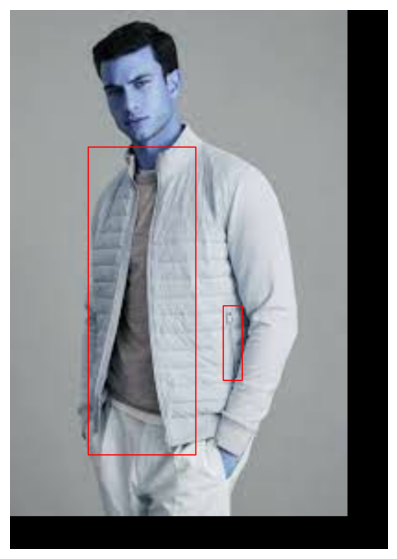

[DEBUG] After resize/pad, shape=(1408, 768, 3), #boxes=3


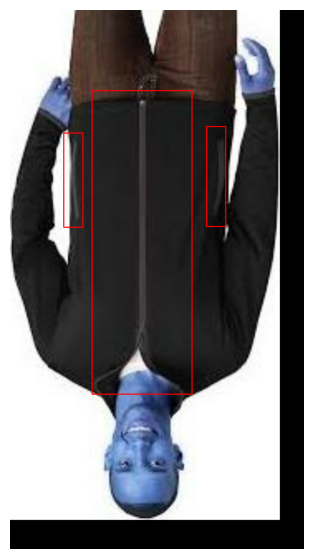

[DEBUG] After resize/pad, shape=(896, 1280, 3), #boxes=2


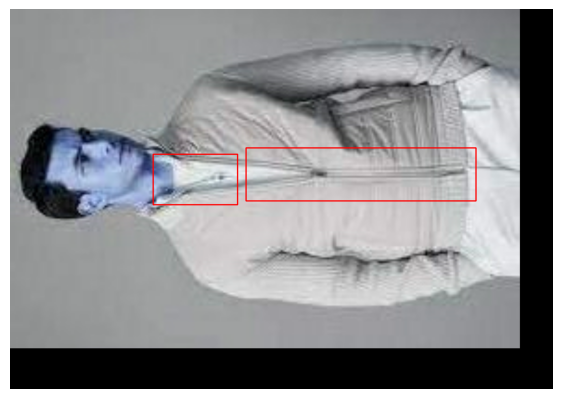

[DEBUG] After resize/pad, shape=(896, 1280, 3), #boxes=3


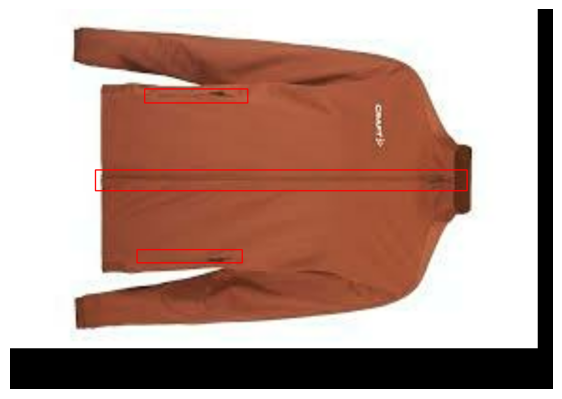

Got batch => shape=(4, 1408, 1280, 3), anchors=(337590, 4)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_603']
Received: inputs=Tensor(shape=(4, 1408, 1280, 3))
  warnings.warn(msg)


Step=0, loss=4013.8171
Step=20, loss=3.1690
Step=40, loss=1.5130
Step=60, loss=1.3088
Step=80, loss=3.5569
Step=100, loss=1.3617
Step=120, loss=1.0569
Step=140, loss=0.7384
Step=160, loss=0.5487
Step=180, loss=0.3702
Done training. Let's decode + visualize last batch!
[Image 0] => Found 1 boxes > 0.5 conf.


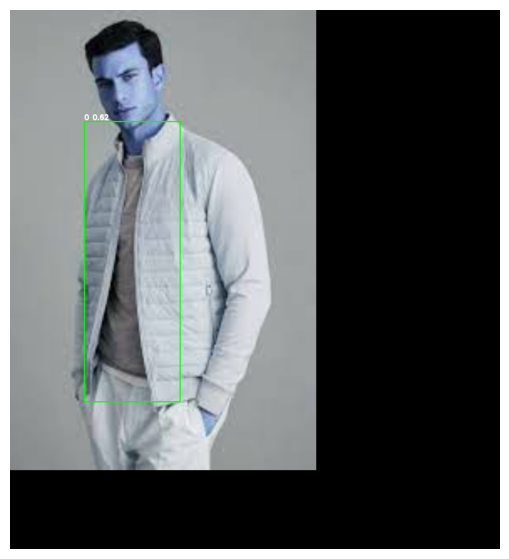

[Image 1] => Found 1 boxes > 0.5 conf.


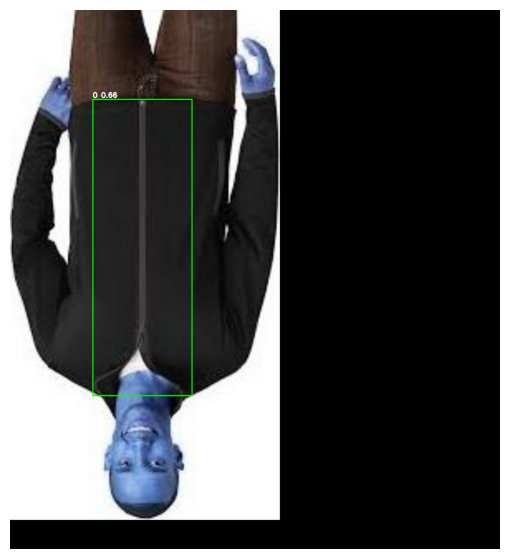

[Image 2] => Found 0 boxes > 0.5 conf.


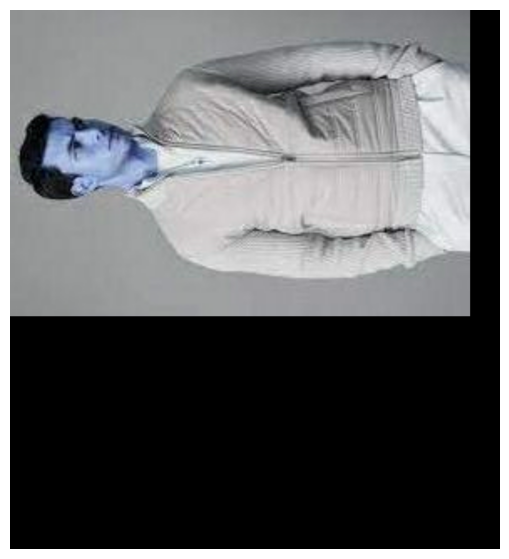

[Image 3] => Found 0 boxes > 0.5 conf.


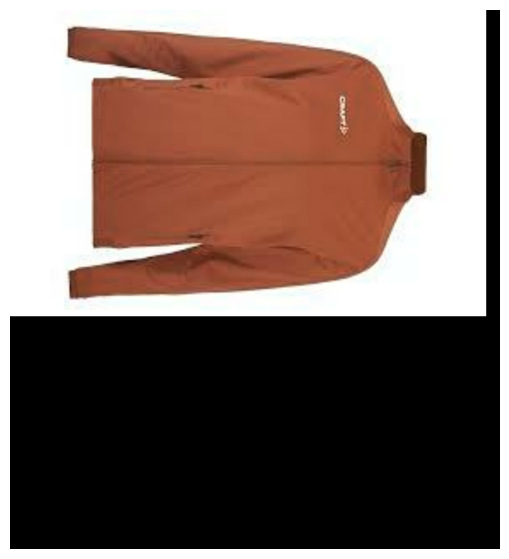

In [ ]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras import mixed_precision
# Force everything to float32 from the start:
mixed_precision.set_global_policy("float32")

import keras
from pycocotools.coco import COCO

################################################################################
# 1) Basic Box Conversions + Visualization
################################################################################

def convert_to_xywh(boxes):
    """(xmin,ymin,xmax,ymax)->(x_center,y_center,width,height)."""
    return tf.concat([
        (boxes[..., :2] + boxes[..., 2:]) / 2.0,
        boxes[..., 2:] - boxes[..., :2]
    ], axis=-1)

def convert_to_corners(boxes_xywh):
    """(x_center,y_center,w,h)->(xmin,ymin,xmax,ymax)."""
    return tf.concat([
        boxes_xywh[..., :2] - boxes_xywh[..., 2:] / 2.0,
        boxes_xywh[..., :2] + boxes_xywh[..., 2:] / 2.0
    ], axis=-1)

def visualize_detections(image, boxes, scores=None, classes=None, color=(0,255,0)):
    """Draw bounding boxes [xmin,ymin,xmax,ymax] on a np.uint8 image."""
    img_vis = image.copy()
    if boxes is not None:
        for i in range(len(boxes)):
            x1,y1,x2,y2 = boxes[i]
            cv2.rectangle(img_vis,(int(x1),int(y1)),(int(x2),int(y2)),color,2)
            label = ""
            if classes is not None:
                label += f"{classes[i]}"
            if scores is not None:
                label += f" {scores[i]:.2f}"
            if label:
                cv2.putText(
                    img_vis,
                    label,
                    (int(x1), max(0,int(y1)-5)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,(255,255,255),2
                )
    plt.figure(figsize=(7,7))
    plt.imshow(img_vis[...,::-1])  # BGR->RGB
    plt.axis("off")
    plt.show()

################################################################################
# 2) Minimal Anchor Generator
################################################################################

class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        # Add 1024^2 to handle bigger objects
        self.areas         = [32**2,64**2,128**2,256**2,512**2,1024**2]
        # scales => ~1.0, 1.26, 1.59
        self.scales        = [2 ** x for x in [0,1/3,2/3]]
        self.num_anchors   = len(self.aspect_ratios)*len(self.scales)
        self.strides       = [8,16,32,64,128]
        self._anchor_dims  = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all= []
        for area in self.areas:
            anchor_dims= []
            for ar in self.aspect_ratios:
                h= tf.sqrt(area/ar)
                w= area/h
                base= tf.stack([w,h], axis=-1)
                for s in self.scales:
                    anchor_dims.append(s*base)
            anchor_dims_all.append(tf.stack(anchor_dims,axis=0))
        return anchor_dims_all

    def _get_anchors(self, feat_h, feat_w, level):
        stride= self.strides[level-3]
        rx= tf.range(feat_w, dtype=tf.float32)+0.5
        ry= tf.range(feat_h, dtype=tf.float32)+0.5
        cx,cy= tf.meshgrid(rx, ry)
        cx= cx* stride
        cy= cy* stride
        center_grid= tf.stack([cx,cy],axis=-1)
        center_grid= tf.expand_dims(center_grid,2)

        dims= self._anchor_dims[level-3]
        dims= tf.reshape(dims, [1,1,self.num_anchors,2])
        dims_tiled= tf.tile(dims,[feat_h,feat_w,1,1])
        center_tiled= tf.tile(center_grid,[1,1,self.num_anchors,1])
        anchors_l= tf.concat([center_tiled,dims_tiled], axis=-1) # (fh,fw,9,4)
        anchors_l= tf.reshape(anchors_l, [-1,4])
        return anchors_l

    def get_anchors(self, img_h, img_w):
        all_anchors=[]
        for level in range(3,8):
            fh= tf.math.ceil(img_h/(2**level))
            fw= tf.math.ceil(img_w/(2**level))
            anchors_l= self._get_anchors(int(fh),int(fw),level)
            all_anchors.append(anchors_l)
        return tf.concat(all_anchors, axis=0)

################################################################################
# 3) Resize + Pad + Scaling BBoxes
################################################################################

def resize_and_pad(image, min_side=800, max_side=1333, stride=128):
    """
    1) Scale so short side=800, if that leads to long side>1333,
       then scale by 1333/long_side.
    2) Pad height/width to a multiple of stride (128).
    """
    orig_h= tf.cast(tf.shape(image)[0], tf.float32)
    orig_w= tf.cast(tf.shape(image)[1], tf.float32)
    short_side= tf.minimum(orig_h, orig_w)
    ratio= min_side / short_side
    long_side= tf.maximum(orig_h, orig_w)
    if ratio * long_side > max_side:
        ratio= max_side / long_side

    new_h_f= orig_h * ratio
    new_w_f= orig_w * ratio
    resized_h= tf.cast(new_h_f, tf.int32)
    resized_w= tf.cast(new_w_f, tf.int32)

    image_resized= tf.image.resize(image, (resized_h,resized_w))

    p_h_f= tf.math.ceil(new_h_f /  stride)* stride
    p_w_f= tf.math.ceil(new_w_f /  stride)* stride
    p_h= tf.cast(p_h_f, tf.int32)
    p_w= tf.cast(p_w_f, tf.int32)

    image_padded= tf.image.pad_to_bounding_box(image_resized, 0,0, p_h, p_w)
    return image_padded, ratio

def preprocess_image_for_train(img, boxes):
    """
    1) resize/pad => ratio
    2) scale boxes => boxes*[ratio]
    3) convert to (x_center,y_center,w,h)
    """
    img= tf.cast(img, tf.float32)
    img_pad, ratio= resize_and_pad(img)
    scaled_boxes= boxes * ratio
    xywh= convert_to_xywh(scaled_boxes)
    return img_pad, xywh, ratio

################################################################################
# 4) Model: Minimal RetinaNet
################################################################################

def build_head(out_filters):
    kinit= tf.random_normal_initializer(0.0,0.01)
    seq= keras.Sequential()
    for _ in range(4):
        seq.add(keras.layers.Conv2D(256,3,padding="same",kernel_initializer=kinit))
        seq.add(keras.layers.ReLU())
    seq.add(keras.layers.Conv2D(out_filters,3,padding="same",kernel_initializer=kinit))
    return seq

class FPN(keras.layers.Layer):
    def __init__(self):
        super().__init__()
        backbone= keras.applications.ResNet50(include_top=False,
                                              input_shape=[None,None,3])
        c3= backbone.get_layer("conv3_block4_out").output
        c4= backbone.get_layer("conv4_block6_out").output
        c5= backbone.get_layer("conv5_block3_out").output
        self.backbone= keras.Model(backbone.inputs,[c3,c4,c5])

        self.c3_1x1= keras.layers.Conv2D(256,1)
        self.c4_1x1= keras.layers.Conv2D(256,1)
        self.c5_1x1= keras.layers.Conv2D(256,1)

        self.c3_3x3= keras.layers.Conv2D(256,3,padding="same")
        self.c4_3x3= keras.layers.Conv2D(256,3,padding="same")
        self.c5_3x3= keras.layers.Conv2D(256,3,padding="same")
        self.c6_3x3= keras.layers.Conv2D(256,3,2,padding="same")
        self.c7_3x3= keras.layers.Conv2D(256,3,2,padding="same")
        self.up= keras.layers.UpSampling2D(2)

    def call(self,x):
        c3,c4,c5= self.backbone(x)
        p3= self.c3_1x1(c3)
        p4= self.c4_1x1(c4)
        p5= self.c5_1x1(c5)

        p4= p4 + self.up(p5)
        p3= p3 + self.up(p4)

        p3= self.c3_3x3(p3)
        p4= self.c4_3x3(p4)
        p5= self.c5_3x3(p5)
        p6= self.c6_3x3(c5)
        p7= self.c7_3x3(tf.nn.relu(p6))
        return [p3,p4,p5,p6,p7]

class RetinaNet(keras.Model):
    def __init__(self,num_classes=3):
        super().__init__()
        self.fpn= FPN()
        self.cls_head= build_head(9*num_classes)
        self.box_head= build_head(9*4)
        self.num_classes= num_classes

    def call(self,x):
        feats= self.fpn(x)
        B= tf.shape(x)[0]
        cls_outs=[]
        box_outs=[]
        for f in feats:
            cls_f= self.cls_head(f)
            box_f= self.box_head(f)
            cls_f= tf.reshape(cls_f,[B,-1,self.num_classes])
            box_f= tf.reshape(box_f,[B,-1,4])
            cls_outs.append(cls_f)
            box_outs.append(box_f)
        cls_out= tf.concat(cls_outs, axis=1)
        box_out= tf.concat(box_outs, axis=1)
        return tf.concat([box_out, cls_out], axis=-1)

################################################################################
# 5) Simple Focal + Box Loss
################################################################################

class FocalLoss(tf.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__(reduction="none")
        self.alpha= alpha
        self.gamma= gamma

    def call(self, y_true, y_pred):
        xent= tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        p= tf.nn.sigmoid(y_pred)
        alpha_= tf.where(tf.equal(y_true,1.0), self.alpha, 1.0-self.alpha)
        pt= tf.where(tf.equal(y_true,1.0), p, 1.0-p)
        focal= alpha_*((1.0-pt)**self.gamma)* xent
        return tf.reduce_sum(focal,axis=-1)

class SmoothL1Loss(tf.losses.Loss):
    def __init__(self, delta=1.0):
        super().__init__(reduction="none")
        self.delta= delta
    def call(self, y_true, y_pred):
        diff= y_true- y_pred
        abs_diff= tf.abs(diff)
        sq_diff= diff**2
        loss= tf.where(abs_diff<self.delta, 0.5* sq_diff, abs_diff- 0.5*self.delta)
        return tf.reduce_sum(loss, axis=-1)

class DetLoss(tf.losses.Loss):
    def __init__(self,num_classes=3, alpha=0.25,gamma=2.0,delta=1.0):
        super().__init__(reduction="none")
        self.num_classes= num_classes
        self.focal= FocalLoss(alpha,gamma)
        self.l1= SmoothL1Loss(delta)

    def call(self, y_true, y_pred):
        # y_true => (B, A, 5) => [dx, dy, dw, dh, cls_id]
        # y_pred => (B, A, 4+ num_classes)
        box_tgt= y_true[:,:,:4]
        cls_id = y_true[:,:,4]

        box_pred= y_pred[:,:,:4]
        cls_pred= y_pred[:,:,4:]

        # Build one-hot
        cls_id_int= tf.cast(cls_id, tf.int32)
        cls_1hot= tf.one_hot(cls_id_int, depth=self.num_classes)

        # ignore => -2 => zero out both
        # pos => cls_id>=0 => real object
        # background => -1
        pos_mask= tf.where(cls_id>=0,1.0,0.0)
        ignore_mask= tf.where(tf.equal(cls_id,-2.0),1.0,0.0)

        c_loss= self.focal(cls_1hot, cls_pred)
        b_loss= self.l1(box_tgt, box_pred)

        # zero out classification for ignore
        c_loss= tf.where(ignore_mask>0.0, 0.0, c_loss)
        # zero out box for not pos
        b_loss= tf.where(pos_mask>0.0, b_loss, 0.0)

        normalizer= tf.reduce_sum(pos_mask, axis=-1)
        c_loss_sum= tf.reduce_sum(c_loss, axis=-1)
        b_loss_sum= tf.reduce_sum(b_loss, axis=-1)
        c_loss_mean= tf.math.divide_no_nan(c_loss_sum, normalizer)
        b_loss_mean= tf.math.divide_no_nan(b_loss_sum, normalizer)

        return c_loss_mean+ b_loss_mean

################################################################################
# 6) Decoding + NMS
################################################################################

def decode_predictions(y_pred, anchors, num_classes=3, box_var=[0.1,0.1,0.2,0.2],
                       score_thresh=0.05, iou_thresh=0.5, max_output=50):
    """
    y_pred: (B, A, 4 + num_classes)
    anchors: (A,4) => [x_center,y_center,w,h]
    """
    box_pred= y_pred[:,:,:4]
    cls_pred= y_pred[:,:,4:]  # shape=(B,A,num_classes)

    # decode box
    box_var= tf.constant(box_var,tf.float32)
    dx= box_pred[:,:,0]* box_var[0]
    dy= box_pred[:,:,1]* box_var[1]
    dw= box_pred[:,:,2]* box_var[2]
    dh= box_pred[:,:,3]* box_var[3]

    anc_tf= tf.expand_dims(anchors,0) # (1,A,4)
    anc_tf= tf.tile(anc_tf, [tf.shape(y_pred)[0],1,1]) # (B,A,4)
    x_a= anc_tf[:,:,0]
    y_a= anc_tf[:,:,1]
    w_a= anc_tf[:,:,2]
    h_a= anc_tf[:,:,3]

    x_center= x_a + dx*w_a
    y_center= y_a + dy*h_a
    w= w_a* tf.exp(dw)
    h= h_a* tf.exp(dh)

    x1= x_center- 0.5*w
    y1= y_center- 0.5*h
    x2= x_center+ 0.5*w
    y2= y_center+ 0.5*h
    boxes_all= tf.stack([x1,y1,x2,y2], axis=-1) # (B,A,4)

    # apply sigmoid => get prob
    prob= tf.nn.sigmoid(cls_pred)  # (B,A,num_classes)

    results=[]
    B= tf.shape(y_pred)[0]
    for i in range(B):
        boxes_i= boxes_all[i]
        prob_i = prob[i]
        # flatten => find max class
        max_probs= tf.reduce_max(prob_i, axis=-1)
        cls_ids  = tf.argmax(prob_i, axis=-1)

        keep= max_probs> score_thresh
        sel_boxes= tf.boolean_mask(boxes_i, keep)
        sel_scores= tf.boolean_mask(max_probs, keep)
        sel_cls= tf.boolean_mask(cls_ids, keep)

        nms_idx= tf.image.non_max_suppression(
            sel_boxes, sel_scores,
            max_output_size=max_output,
            iou_threshold=iou_thresh,
            score_threshold=score_thresh
        )
        sel_boxes= tf.gather(sel_boxes, nms_idx)
        sel_scores= tf.gather(sel_scores, nms_idx)
        sel_cls= tf.gather(sel_cls, nms_idx)
        results.append({
            "boxes": sel_boxes.numpy(),
            "scores": sel_scores.numpy(),
            "classes": sel_cls.numpy()
        })
    return results

################################################################################
# 7) Utility: iou_xywh + anchor matching
################################################################################

def iou_xywh(a, b):
    """
    a,b => Nx4 => x_center,y_center,w,h
    returns iou => shape=(aN, bN)
    """
    A= tf.shape(a)[0]
    B= tf.shape(b)[0]
    def corners(xc_yc_wh):
        return tf.concat([
            xc_yc_wh[..., :2] - xc_yc_wh[..., 2:]/2.0,
            xc_yc_wh[..., :2] + xc_yc_wh[..., 2:]/2.0
        ], axis=-1)

    a_c= corners(a)
    b_c= corners(b)

    a_c= tf.reshape(a_c, [A,1,4])
    b_c= tf.reshape(b_c, [1,B,4])
    lu= tf.maximum(a_c[...,:2], b_c[...,:2])
    rd= tf.minimum(a_c[...,2:], b_c[...,2:])
    wh= tf.maximum(0.0, rd-lu)
    inter= wh[...,0]*wh[...,1]
    area_a= a[...,2]* a[...,3]
    area_b= b[...,2]* b[...,3]
    area_a= tf.reshape(area_a,[A,1])
    area_b= tf.reshape(area_b,[1,B])
    union= area_a+ area_b- inter
    return tf.clip_by_value(inter/union,0,1)

def match_anchors(anchors, gt_xywh, gt_cls, iou_pos=0.5, iou_neg=0.4,
                  box_var=[0.1,0.1,0.2,0.2]):
    ious_= iou_xywh(anchors, gt_xywh)
    max_iou= tf.reduce_max(ious_, axis=1)
    best_idx= tf.argmax(ious_, axis=1)

    pos_mask= max_iou>= iou_pos
    neg_mask= max_iou<  iou_neg
    ignore_mask= tf.logical_not(tf.logical_or(pos_mask, neg_mask))

    matched_boxes= tf.gather(gt_xywh, best_idx)
    matched_cls  = tf.gather(gt_cls,   best_idx)

    a_x,a_y,a_w,a_h= tf.unstack(anchors, axis=-1)
    m_x,m_y,m_w,m_h= tf.unstack(matched_boxes, axis=-1)

    dx= (m_x - a_x)/ a_w
    dy= (m_y - a_y)/ a_h
    dw= tf.math.log(m_w/ a_w)
    dh= tf.math.log(m_h/ a_h)

    dx/= box_var[0]
    dy/= box_var[1]
    dw/= box_var[2]
    dh/= box_var[3]

    # default => -1 => background
    cls_ = tf.ones_like(dx)* -1.0
    cls_ = tf.where(pos_mask, matched_cls, cls_)
    cls_ = tf.where(ignore_mask, -2.0, cls_)

    label_reg= tf.stack([dx,dy,dw,dh], axis=-1)
    label_final= tf.concat([label_reg, tf.expand_dims(cls_, axis=-1)], axis=-1)
    return label_final

################################################################################
# 8) Overfit MULTIPLE Images
################################################################################

def get_random_batch(coco, images_dir, anchor_obj, num_images=4):
    """
    1) Randomly pick 'num_images' from the COCO dataset that have >=1 annotation.
    2) For each image: read it, decode, build GT boxes, preprocess -> (resized+pad, scaled boxes).
    3) Debug visualize bounding boxes after resizing/padding.
    4) Collect them all, unify to (maxH, maxW).
    5) Build anchors for (maxH, maxW).
    6) Match anchors for each image => label => shape=(A,5). Then stack => (num_images,A,5).
    7) Return images_b, labels_b, anchors, (maxH, maxW).
    """
    coco_ids = list(coco.imgs.keys())
    random_ids = []
    while len(random_ids)< num_images:
        cand_id = random.choice(coco_ids)
        ann_ids= coco.getAnnIds(imgIds=cand_id)
        if len(ann_ids)>0:
            random_ids.append(cand_id)

    images_list=[]
    boxes_list=[]
    cls_list=[]
    shapes_list=[]

    for iid in random_ids:
        info= coco.imgs[iid]
        fpath= os.path.join(images_dir, info["file_name"])
        raw= tf.io.read_file(fpath)
        img= tf.image.decode_jpeg(raw, channels=3)
        img= tf.cast(img, tf.float32)

        ann_ids= coco.getAnnIds(imgIds=iid)
        ann_list= coco.loadAnns(ann_ids)
        bbb=[]
        ccc=[]
        for ann in ann_list:
            cat_id= ann["category_id"]
            x,y,w,h= ann["bbox"]
            bbb.append([x,y,x+w,y+h])
            # shift to 0-based if needed
            ccc.append(cat_id-1)

        if len(bbb)==0:
            # produce empty
            btf= tf.zeros((0,4), dtype=tf.float32)
            ctf= tf.zeros((0,), dtype=tf.float32)
        else:
            btf= tf.constant(bbb, tf.float32)
            ctf= tf.constant(ccc, tf.float32)

        pre_img, pre_xywh, _= preprocess_image_for_train(img, btf)

        # Debug visualize
        debug_img_np = pre_img.numpy().astype('uint8')
        debug_boxes_xyxy = convert_to_corners(pre_xywh).numpy()
        print(f"[DEBUG] After resize/pad, shape={pre_img.shape}, #boxes={debug_boxes_xyxy.shape[0]}")
        visualize_detections(debug_img_np, debug_boxes_xyxy, color=(0,0,255))

        images_list.append(pre_img)
        boxes_list.append(pre_xywh)
        cls_list.append(ctf)
        shapes_list.append((tf.shape(pre_img)[0], tf.shape(pre_img)[1]))

    # unify shapes => find maxH, maxW
    maxH= max([shp[0].numpy() for shp in shapes_list])
    maxW= max([shp[1].numpy() for shp in shapes_list])

    # pad each image => (maxH, maxW)
    final_imgs=[]
    for i in range(num_images):
        cur_img= images_list[i]
        pad_img= tf.image.pad_to_bounding_box(cur_img, 0,0, maxH, maxW)
        final_imgs.append(pad_img)
    images_b= tf.stack(final_imgs, axis=0)  # shape=(num_images, maxH, maxW, 3)

    # build anchors for (maxH, maxW)
    anchors= anchor_obj.get_anchors(
        tf.cast(maxH,tf.float32),
        tf.cast(maxW,tf.float32)
    )

    # match anchors for each image
    all_labels=[]
    for i in range(num_images):
        label_ = match_anchors(anchors, boxes_list[i], cls_list[i])
        all_labels.append(label_)
    labels_b= tf.stack(all_labels, axis=0)  # shape=(num_images,A,5)

    return images_b, labels_b, anchors, (maxH, maxW)

################################################################################
# 9) Main Overfit
################################################################################

def main():
    JSON_PATH = "/content/drive/MyDrive/exp_retina_net/labels/merged_coco.json"
    IMAGES_DIR= "/content/drive/MyDrive/exp_retina_net/images"

    coco= COCO(JSON_PATH)
    anchor_obj= AnchorBox()

    # pick e.g. 4 images
    images_b, labels_b, anchors_b, (H, W) = get_random_batch(
        coco, IMAGES_DIR, anchor_obj, num_images=4
    )

    print(f"Got batch => shape={images_b.shape}, anchors={anchors_b.shape}")

    model= RetinaNet(num_classes=3)
    loss_obj= DetLoss(num_classes=3)
    opt= tf.keras.optimizers.Adam(1e-4)

    steps= 200
    for step_i in range(steps):
        with tf.GradientTape() as tape:
            pred_b= model(images_b, training=True) # shape=(4, A, 4+3)
            loss_b= loss_obj(labels_b, pred_b)      # shape=(4,)
            loss_val= tf.reduce_mean(loss_b)
        grads= tape.gradient(loss_val, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))

        if step_i % 20 == 0:
            print(f"Step={step_i}, loss={loss_val.numpy():.4f}")

    print("Done training. Let's decode + visualize last batch!")
    # decode
    pred_b= model(images_b, training=False)
    anchors_np= anchors_b.numpy()

    # Use a lower threshold for debugging if you want to see more boxes
    results= decode_predictions(
        pred_b, anchors_np,
        score_thresh=0.5, iou_thresh=0.5, max_output=50
    )
    images_np= images_b.numpy().astype("uint8")

    # visualize each
    for i in range(images_b.shape[0]):
        boxes_i= results[i]["boxes"]
        scores_i= results[i]["scores"]
        cls_i= results[i]["classes"]
        print(f"[Image {i}] => Found {len(boxes_i)} boxes > 0.5 conf.")
        visualize_detections(images_np[i], boxes_i, scores_i, cls_i)

if __name__=="__main__":
    main()


[INFO] Successfully loaded weights from /content/weights/weights.h5.
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
[Image: IMG_0953.jpg] => Found 0 boxes above 0.2 conf.


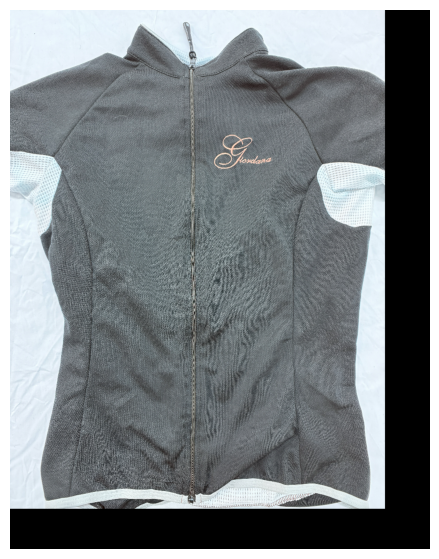

[Image: image_267.jpg] => Found 5 boxes above 0.2 conf.


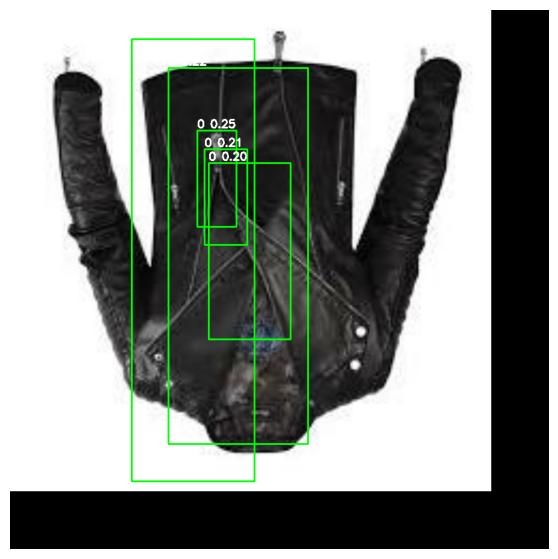

[Image: front_2023_11_29_10_11_19.jpg] => Found 0 boxes above 0.2 conf.


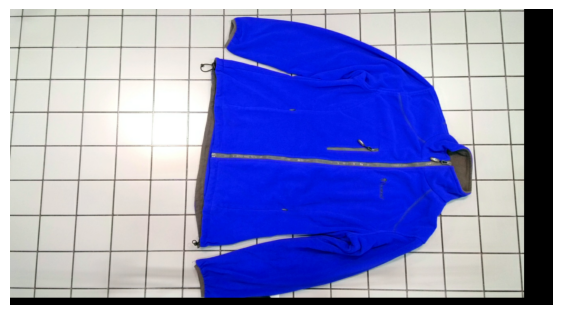

[Image: image_308.jpg] => Found 10 boxes above 0.2 conf.


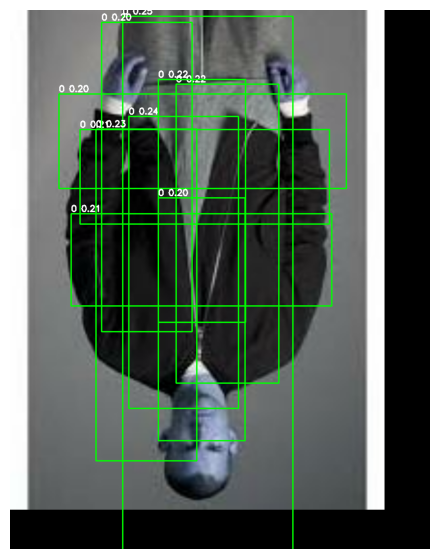

[Image: image_608 - Copy.jpg] => Found 4 boxes above 0.2 conf.


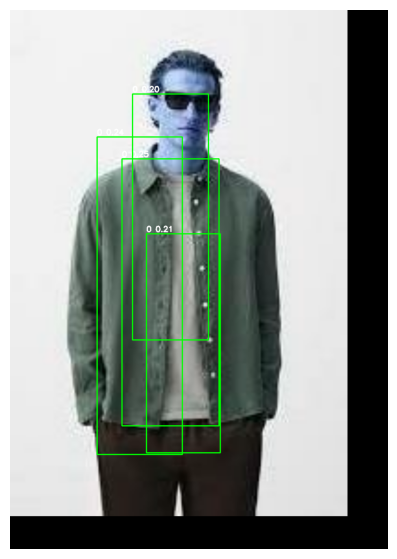

[Image: IMG_1017.jpg] => Found 0 boxes above 0.2 conf.


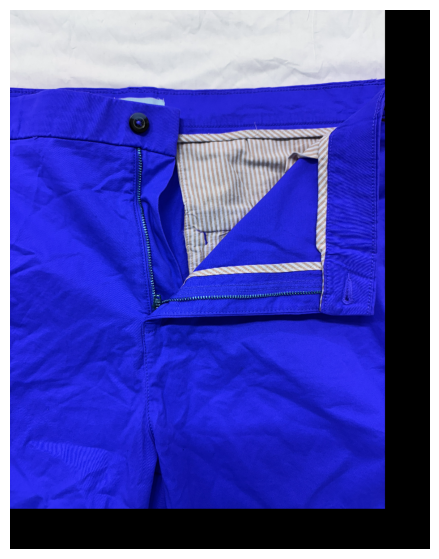

[Image: IMG_1010.jpg] => Found 0 boxes above 0.2 conf.


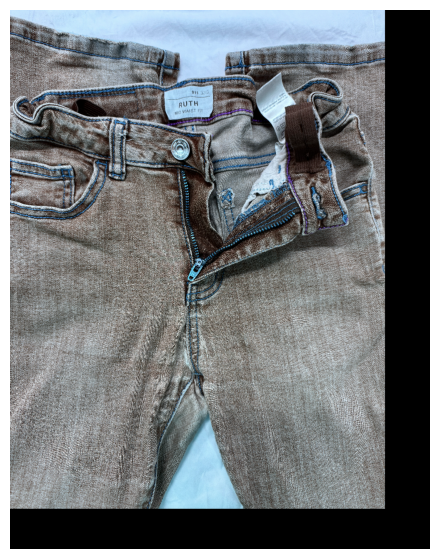

[Image: image_95.jpg] => Found 1 boxes above 0.2 conf.


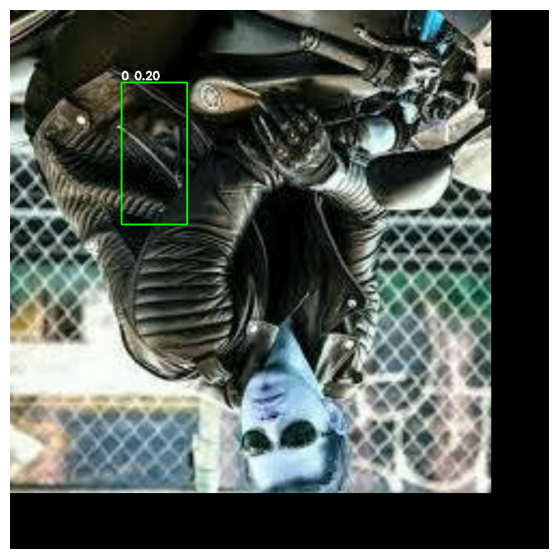

[Image: image_647.jpg] => Found 9 boxes above 0.2 conf.


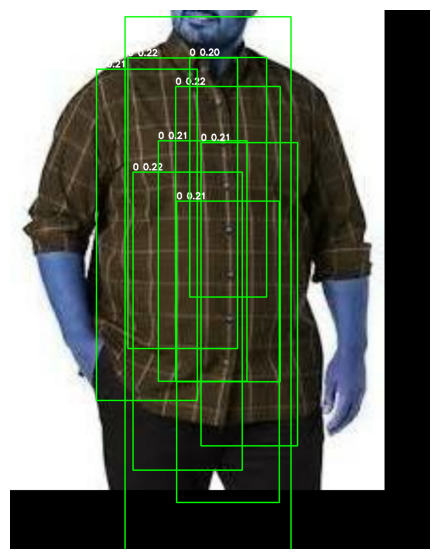

[Image: IMG_1088.jpg] => Found 0 boxes above 0.2 conf.


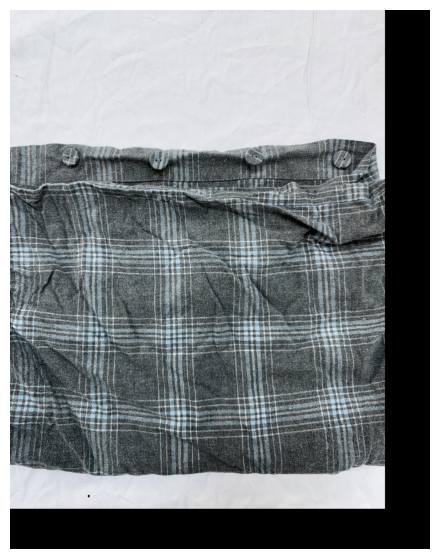

[Image: front_2023_11_02_07_01_06.jpg] => Found 0 boxes above 0.2 conf.


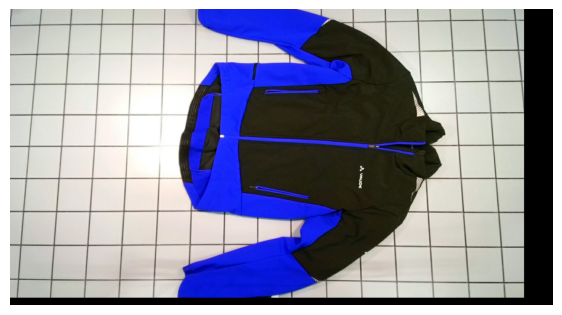

[Image: image_326.jpg] => Found 0 boxes above 0.2 conf.


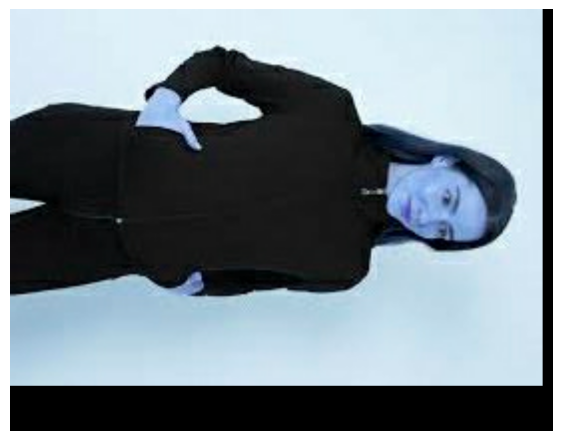

[Image: image_17 - Copy.jpg] => Found 0 boxes above 0.2 conf.


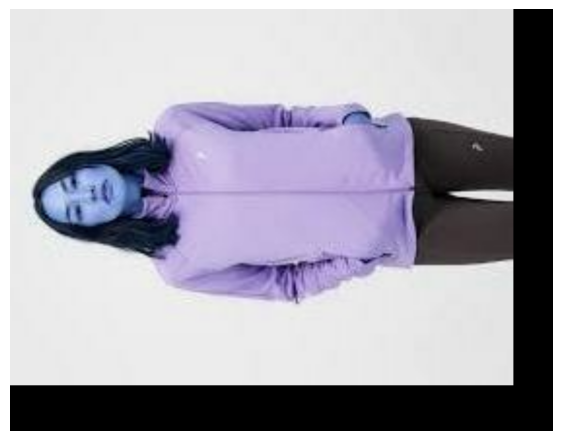

[Image: front_2024_05_06_06_19_18.jpg] => Found 0 boxes above 0.2 conf.


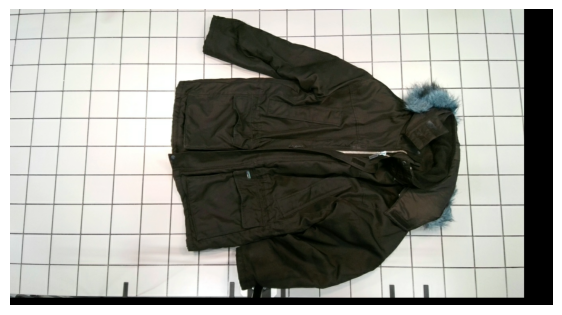

[Image: image_136 - Copy.jpg] => Found 7 boxes above 0.2 conf.


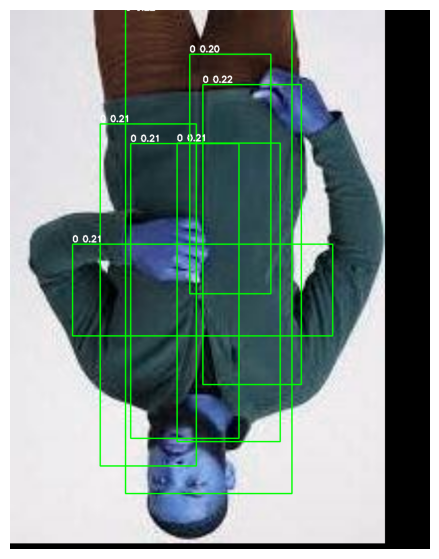

[Image: image_92.jpg] => Found 1 boxes above 0.2 conf.


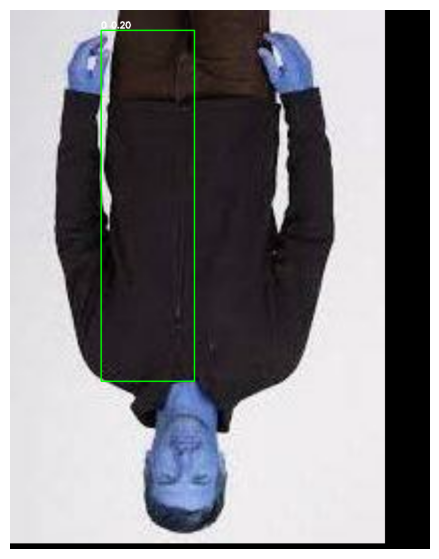

[Image: IMG_0953 - Copy.jpg] => Found 0 boxes above 0.2 conf.


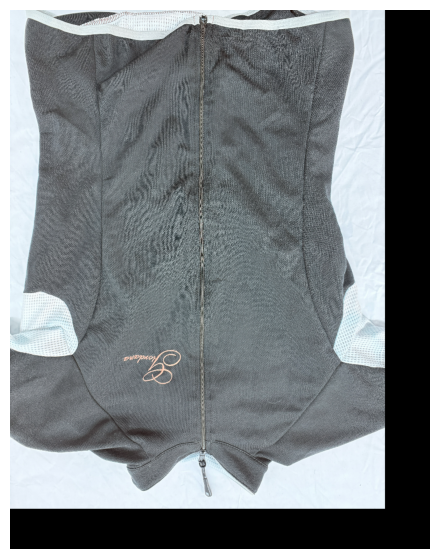

[Image: image_680.jpg] => Found 3 boxes above 0.2 conf.


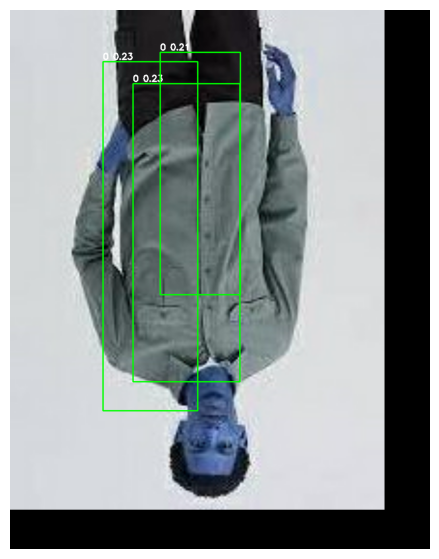

[Image: front_2023_05_22_12_05_06 - Copy.jpg] => Found 1 boxes above 0.2 conf.


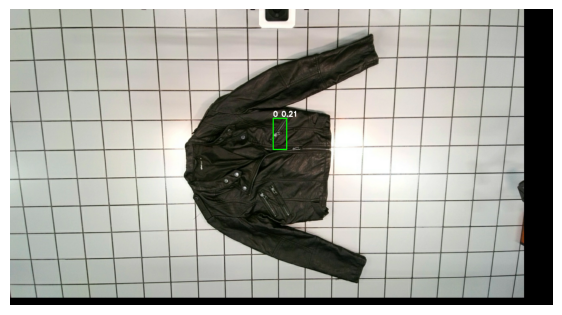

[Image: image_488 - Copy.jpg] => Found 1 boxes above 0.2 conf.


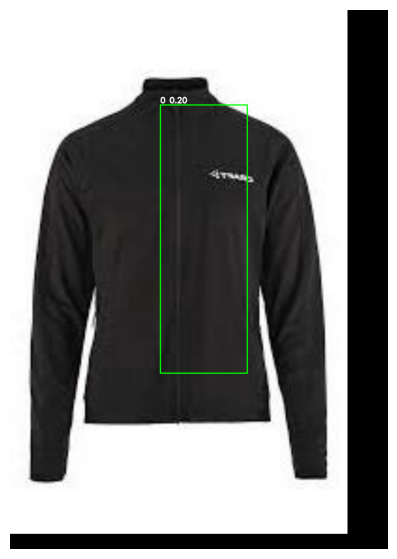

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import cv2
from pycocotools.coco import COCO

################################################################################
# 1) Basic Box Conversions + Visualization (identical to training)
################################################################################

def convert_to_xywh(boxes):
    """(xmin,ymin,xmax,ymax)->(cx,cy,w,h)."""
    return tf.concat([
        (boxes[..., :2] + boxes[..., 2:]) / 2.0,
        boxes[..., 2:] - boxes[..., :2]
    ], axis=-1)

def convert_to_corners_xywh(boxes_xywh):
    """(cx,cy,w,h)->(xmin,ymin,xmax,ymax)."""
    return tf.concat([
        boxes_xywh[..., :2] - boxes_xywh[..., 2:] / 2.0,
        boxes_xywh[..., :2] + boxes_xywh[..., 2:] / 2.0
    ], axis=-1)

def visualize_detections(image, boxes, scores=None, classes=None, color=(0,255,0)):
    """
    Draw bounding boxes [xmin,ymin,xmax,ymax] onto a copy of `image` (uint8).
    Then show via matplotlib.
    """
    img_vis = image.copy()
    if boxes is not None:
        for i in range(len(boxes)):
            x1, y1, x2, y2 = boxes[i]
            cv2.rectangle(img_vis, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            label = ""
            if classes is not None:
                label += f"{classes[i]}"
            if scores is not None:
                label += f" {scores[i]:.2f}"
            if label:
                cv2.putText(
                    img_vis,
                    label,
                    (int(x1), max(0, int(y1) - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,
                    (255, 255, 255),
                    2
                )
    plt.figure(figsize=(7,7))
    plt.imshow(img_vis[..., ::-1])
    plt.axis("off")
    plt.show()

################################################################################
# 2) Minimal Anchor Generator (same as training)
################################################################################

class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.areas         = [32**2, 64**2, 128**2, 256**2, 512**2, 1024**2]
        self.scales        = [2 ** x for x in [0, 1/3, 2/3]]
        self.num_anchors   = len(self.aspect_ratios) * len(self.scales)
        # Feature map strides for P3..P7
        self.strides       = [8, 16, 32, 64, 128]
        self._anchor_dims  = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self.areas:
            anchor_dims = []
            for ar in self.aspect_ratios:
                h = tf.sqrt(area / ar)
                w = area / h
                base = tf.stack([w, h], axis=-1)
                for s in self.scales:
                    anchor_dims.append(s * base)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=0))
        return anchor_dims_all

    def _get_anchors(self, feat_h, feat_w, level):
        stride = self.strides[level - 3]
        rx = tf.range(feat_w, dtype=tf.float32) + 0.5
        ry = tf.range(feat_h, dtype=tf.float32) + 0.5
        cx, cy = tf.meshgrid(rx, ry)
        cx = cx * stride
        cy = cy * stride
        center_grid = tf.stack([cx, cy], axis=-1)
        center_grid = tf.expand_dims(center_grid, 2)

        dims = self._anchor_dims[level - 3]
        dims = tf.reshape(dims, [1, 1, self.num_anchors, 2])
        dims_tiled = tf.tile(dims, [feat_h, feat_w, 1, 1])
        center_tiled = tf.tile(center_grid, [1, 1, self.num_anchors, 1])
        anchors_l = tf.concat([center_tiled, dims_tiled], axis=-1)  # (fh,fw,9,4)
        anchors_l = tf.reshape(anchors_l, [-1, 4])
        return anchors_l

    def get_anchors(self, img_h, img_w):
        """
        Generate all anchors for pyramid levels [3..7].
        Returns shape=(A,4) => (center_x, center_y, w, h).
        """
        all_anchors = []
        for level in range(3, 8):
            fh = tf.math.ceil(img_h / (2 ** level))
            fw = tf.math.ceil(img_w / (2 ** level))
            anchors_l = self._get_anchors(int(fh), int(fw), level)
            all_anchors.append(anchors_l)
        return tf.concat(all_anchors, axis=0)

################################################################################
# 3) Resize + Pad (same as training)
################################################################################

def resize_and_pad(image, min_side=800, max_side=1333, stride=128):
    """
    1) Resizes so the short side ~800px (unless that would exceed max_side=1333).
    2) Then pads up to the nearest multiple of `stride=128`.
    Returns (padded_image, scale_factor).
    """
    orig_h = tf.cast(tf.shape(image)[0], tf.float32)
    orig_w = tf.cast(tf.shape(image)[1], tf.float32)
    short_side = tf.minimum(orig_h, orig_w)
    ratio = 800.0 / short_side
    long_side = tf.maximum(orig_h, orig_w)
    if ratio * long_side > max_side:
        ratio = max_side / long_side

    new_h_f = orig_h * ratio
    new_w_f = orig_w * ratio
    resized_h = tf.cast(new_h_f, tf.int32)
    resized_w = tf.cast(new_w_f, tf.int32)

    image_resized = tf.image.resize(image, (resized_h, resized_w))

    p_h_f = tf.math.ceil(new_h_f / stride) * stride
    p_w_f = tf.math.ceil(new_w_f / stride) * stride
    p_h = tf.cast(p_h_f, tf.int32)
    p_w = tf.cast(p_w_f, tf.int32)

    image_padded = tf.image.pad_to_bounding_box(image_resized, 0, 0, p_h, p_w)
    return image_padded, ratio

################################################################################
# 4) RetinaNet Architecture (same as training, but we will NOT call .save() ->
#    instead we will do .save_weights() / .load_weights() to avoid layer mismatch
################################################################################

def build_head(out_filters):
    """
    The classification or regression head:
    4 conv layers + 1 final conv => out_filters channels
    """
    kinit = tf.random_normal_initializer(0.0, 0.01)
    seq = keras.Sequential()
    for _ in range(4):
        seq.add(keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kinit))
        seq.add(keras.layers.ReLU())
    seq.add(keras.layers.Conv2D(out_filters, 3, padding="same", kernel_initializer=kinit))
    return seq

class FPN(keras.layers.Layer):
    """Simple Feature Pyramid on top of ResNet50 (C3, C4, C5 -> P3..P7)."""
    def __init__(self):
        super().__init__()
        backbone = keras.applications.ResNet50(include_top=False, input_shape=[None, None, 3])
        c3 = backbone.get_layer("conv3_block4_out").output
        c4 = backbone.get_layer("conv4_block6_out").output
        c5 = backbone.get_layer("conv5_block3_out").output
        self.backbone = keras.Model(backbone.inputs, [c3, c4, c5])

        self.c3_1x1 = keras.layers.Conv2D(256, 1)
        self.c4_1x1 = keras.layers.Conv2D(256, 1)
        self.c5_1x1 = keras.layers.Conv2D(256, 1)

        self.c3_3x3 = keras.layers.Conv2D(256, 3, padding="same")
        self.c4_3x3 = keras.layers.Conv2D(256, 3, padding="same")
        self.c5_3x3 = keras.layers.Conv2D(256, 3, padding="same")
        self.c6_3x3 = keras.layers.Conv2D(256, 3, 2, padding="same")
        self.c7_3x3 = keras.layers.Conv2D(256, 3, 2, padding="same")
        self.up = keras.layers.UpSampling2D(2)

    def call(self, x):
        c3, c4, c5 = self.backbone(x)
        p3 = self.c3_1x1(c3)
        p4 = self.c4_1x1(c4)
        p5 = self.c5_1x1(c5)

        p4 = p4 + self.up(p5)
        p3 = p3 + self.up(p4)

        p3 = self.c3_3x3(p3)
        p4 = self.c4_3x3(p4)
        p5 = self.c5_3x3(p5)
        p6 = self.c6_3x3(c5)
        p7 = self.c7_3x3(tf.nn.relu(p6))
        return [p3, p4, p5, p6, p7]

class RetinaNet(keras.Model):
    """
    Minimal RetinaNet:
      - FPN on ResNet50 -> list of 5 features
      - classification head => (B, A, num_classes)
      - regression head => (B, A, 4)
    """
    def __init__(self, num_classes=3):
        super().__init__(name="RetinaNetModel")
        self.num_classes = num_classes
        self.fpn = FPN()
        # 9 anchors per location => classification has 9 * num_classes
        self.cls_head = build_head(9 * num_classes)
        # 9 anchors per location => bounding box regression has 9 * 4
        self.box_head = build_head(9 * 4)

    def call(self, x):
        feats = self.fpn(x)
        B = tf.shape(x)[0]
        cls_outs = []
        box_outs = []
        for f in feats:
            cls_f = self.cls_head(f)
            box_f = self.box_head(f)
            cls_f = tf.reshape(cls_f, [B, -1, self.num_classes])
            box_f = tf.reshape(box_f, [B, -1, 4])
            cls_outs.append(cls_f)
            box_outs.append(box_f)
        cls_out = tf.concat(cls_outs, axis=1)  # (B, A, num_classes)
        box_out = tf.concat(box_outs, axis=1)  # (B, A, 4)
        return tf.concat([box_out, cls_out], axis=-1)  # shape=(B, A, 4+num_classes)

################################################################################
# 5) Decoding + NMS (identical to training)
################################################################################

def decode_predictions(y_pred, anchors, num_classes=3,
                       box_var=[0.1,0.1,0.2,0.2],
                       score_thresh=0.05, iou_thresh=0.5, max_output=50):
    """
    y_pred: (B, A, 4 + num_classes)
    anchors: (A,4) => [cx,cy,w,h]
    """
    box_pred = y_pred[..., :4]
    cls_pred = y_pred[..., 4:]
    box_var = tf.constant(box_var, tf.float32)

    dx = box_pred[..., 0] * box_var[0]
    dy = box_pred[..., 1] * box_var[1]
    dw = box_pred[..., 2] * box_var[2]
    dh = box_pred[..., 3] * box_var[3]

    anc_tf = tf.expand_dims(anchors, axis=0)
    anc_tf = tf.tile(anc_tf, [tf.shape(y_pred)[0], 1, 1])
    x_a = anc_tf[..., 0]
    y_a = anc_tf[..., 1]
    w_a = anc_tf[..., 2]
    h_a = anc_tf[..., 3]

    # decode
    x_center = x_a + dx * w_a
    y_center = y_a + dy * h_a
    w = w_a * tf.exp(dw)
    h = h_a * tf.exp(dh)

    x1 = x_center - 0.5 * w
    y1 = y_center - 0.5 * h
    x2 = x_center + 0.5 * w
    y2 = y_center + 0.5 * h
    boxes_all = tf.stack([x1, y1, x2, y2], axis=-1)

    probs = tf.nn.sigmoid(cls_pred)
    results = []
    B = tf.shape(y_pred)[0]
    for i in range(B):
        boxes_i = boxes_all[i]
        probs_i = probs[i]
        max_probs = tf.reduce_max(probs_i, axis=-1)  # shape=(A,)
        cls_ids = tf.argmax(probs_i, axis=-1, output_type=tf.int32)

        keep = max_probs > score_thresh
        sel_boxes = tf.boolean_mask(boxes_i, keep)
        sel_scores = tf.boolean_mask(max_probs, keep)
        sel_cls = tf.boolean_mask(cls_ids, keep)

        nms_idx = tf.image.non_max_suppression(
            boxes=sel_boxes,
            scores=sel_scores,
            max_output_size=max_output,
            iou_threshold=iou_thresh,
            score_threshold=score_thresh
        )
        sel_boxes  = tf.gather(sel_boxes,  nms_idx)
        sel_scores = tf.gather(sel_scores, nms_idx)
        sel_cls    = tf.gather(sel_cls,    nms_idx)

        results.append({
            "boxes":  sel_boxes.numpy(),
            "scores": sel_scores.numpy(),
            "classes":sel_cls.numpy()
        })
    return results

################################################################################
# 6) Main Inference: picks 20 random images, resizes+pads, loads anchors, runs
#    the model, decodes detections, and visualizes
################################################################################

def run_inference_on_random_images(
    weights_path,
    JSON_PATH,
    IMAGES_DIR,
    num_classes=3,
    score_thresh=0.5,
    iou_thresh=0.5,
    max_output=50,
    num_images=20
):
    """
    - Rebuild the exact same RetinaNet model: 'model = RetinaNet(...)'
    - Load the saved weights: 'model.load_weights(weights_path)'
    - Randomly pick `num_images` from the dataset, do the same resize+pad, decode, visualize.
    """
    # Build model in Python
    model = RetinaNet(num_classes=num_classes)
    # We must call .build() or .call() once before load_weights, so that
    # the model's variables actually exist. Easiest is to do a dummy forward pass:
    dummy_input = tf.zeros([1, 800, 800, 3], dtype=tf.float32)
    _ = model(dummy_input)

    # Now load weights
    model.load_weights(weights_path)
    print(f"[INFO] Successfully loaded weights from {weights_path}.")

    # Build anchor generator
    anchor_obj = AnchorBox()

    # We'll pick images from your COCO dataset
    coco_obj = COCO(JSON_PATH)
    all_ids = list(coco_obj.imgs.keys())
    random.shuffle(all_ids)
    chosen_ids = all_ids[:num_images]

    for iid in chosen_ids:
        info = coco_obj.imgs[iid]
        fname = info["file_name"]
        fpath = os.path.join(IMAGES_DIR, fname)

        raw = tf.io.read_file(fpath)
        img = tf.image.decode_jpeg(raw, channels=3)
        img = tf.cast(img, tf.float32)

        # Resize+pad exactly as in training
        img_padded, scale = resize_and_pad(img)  # default min_side=800, max_side=1333, stride=128
        # Convert padded image to uint8 for visualization
        img_padded_uint8 = tf.cast(img_padded, tf.uint8).numpy()
        H = img_padded.shape[0]
        W = img_padded.shape[1]

        # Build anchors for this padded size
        anchors_tf = anchor_obj.get_anchors(tf.cast(H, tf.float32), tf.cast(W, tf.float32))
        anchors_np = anchors_tf.numpy()

        # Inference => shape=(1, A, 4+num_classes)
        input_tensor = tf.expand_dims(img_padded, axis=0)  # shape=(1,H,W,3)
        y_pred = model(input_tensor, training=False)
        # Decode
        results = decode_predictions(y_pred, anchors_np, num_classes=num_classes,
                                     score_thresh=score_thresh, iou_thresh=iou_thresh,
                                     max_output=max_output)
        det = results[0]
        boxes_xyxy = det["boxes"]
        scores_    = det["scores"]
        classes_   = det["classes"]

        print(f"[Image: {fname}] => Found {len(boxes_xyxy)} boxes above {score_thresh} conf.")
        # Visualize
        visualize_detections(img_padded_uint8, boxes_xyxy, scores_, classes_)

################################################################################
# 7) Example Usage
################################################################################

if __name__ == "__main__":
    # 1) Point this to the .h5 weights you saved with model.save_weights("weights.h5")
    H5_PATH = "/content/weights/weights.h5"

    # 2) Your JSON file
    JSON_PATH = "/content/drive/MyDrive/exp_retina_net/labels/merged_coco.json"

    # 3) Your images folder
    IMAGES_DIR = "/content/drive/MyDrive/exp_retina_net/images"

    # Run inference on 20 random images
    run_inference_on_random_images(
        weights_path=H5_PATH,
        JSON_PATH=JSON_PATH,
        IMAGES_DIR=IMAGES_DIR,
        num_classes=3,
        score_thresh=0.2,
        iou_thresh=0.5,
        max_output=50,
        num_images=20
    )


In [ ]:
#!/usr/bin/env python

# ── Imports ──────────────────────────────────────────────────────────
import os, math, cv2, json, random, io
import time, subprocess, re
import numpy as np, tensorflow as tf
import matplotlib.pyplot as plt
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler,  Callback, CSVLogger
import matplotlib.patches as patches
from datetime import datetime
import tensorflow.keras.backend as K
from PIL import Image, ImageOps
from typing import Tuple
from tensorboard import program
import socket
import threading, webbrowser
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

import warnings
warnings.filterwarnings(
    "ignore",
    message="The structure of `inputs` doesn't match the expected structure"
)
# 1) Paths & run‑ID
BASE_DIR   = "/content/drive/MyDrive/retina_runs"       # ← pick any name
RUN_ID     = datetime.now().strftime("run_%Y%m%d_%H%M%S")

RUN_DIR    = os.path.join(BASE_DIR, RUN_ID)             # e.g. …/retina_runs/run_20250423_184155
TB_DIR     = os.path.join(RUN_DIR, "tensorboard")       # TensorBoard event files
CKPT_DIR   = os.path.join(RUN_DIR, "weights")           # model checkpoints
BEST_PATH  = os.path.join(CKPT_DIR, "best_FRESH.weights.h5")
IMG_DIR    = os.path.join(RUN_DIR, "images")            # PNG summaries, debug frames

for d in (TB_DIR, CKPT_DIR, IMG_DIR):
    os.makedirs(d, exist_ok=True)

# 3) Summary writers
lr_writer    = tf.summary.create_file_writer(TB_DIR)
image_writer = tf.summary.create_file_writer(IMG_DIR)

print(f"Experiment folders:\n"
      f" RUN_DIR     = {RUN_DIR}\n"
      f" TensorBoard = {TB_DIR}\n"
      f" Checkpoints = {CKPT_DIR}\n"
      f" Image‑logs  = {IMG_DIR}")

# 4) TensorBoard launcher (tries ports 6006→up to max_trials)
def launch_tb(logdir, first_port: int = 6006, max_trials: int = 10):
    """
    Start TensorBoard on the first free port in the range and open a
    browser tab.  Prints a friendly   http://localhost:<port>/   URL
    instead of 0.0.0.0.
    """
    for port in range(first_port, first_port + max_trials):
        # ── is the port free? ───────────────────────────────────────────
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            if s.connect_ex(("127.0.0.1", port)) == 0:
                continue                                    # in use
        # ── launch TensorBoard here ────────────────────────────────────
        tb = program.TensorBoard()
        tb.configure(argv=[
            None,
            "--logdir", logdir,
            "--port", str(port),
            "--bind_all"            # keeps 0.0.0.0 for the server
        ])
        tb.launch()                 # **starts the server**

        url = f"http://localhost:{port}/"   # friendlier for browsers
        print(f"▶ TensorBoard listening on  {url}")
        # small sleep so the server is ready before opening the tab
        time.sleep(2)
        try:
            webbrowser.open(url)
        except Exception:
            # happens in Colab/Jupyter where opening a new tab is blocked;
            # the printed URL is still useful
            pass
        return port

    raise RuntimeError("⚠️  No free port found in the requested range")


# 5) Fire it off in the background
threading.Thread(
    target=launch_tb,
    args=(TB_DIR,),
    kwargs={"first_port":6006, "max_trials":5},
    daemon=True
).start()
# ── Dynamic IoU thresholds ───────────────────────────────────────────
IOU_POS = tf.Variable(0.3, trainable=False, dtype=tf.float32,
                      name="iou_pos_threshold")
IOU_NEG = tf.Variable(0.2, trainable=False, dtype=tf.float32,
                      name="iou_neg_threshold")
IOU_NMS = tf.Variable(0.25, trainable=False, dtype=tf.float32,
                      name="iou_nms_threshold")

BOX_VAR = tf.constant([0.1, 0.1, 0.2, 0.2], tf.float32)
IMG_SIZE     = 384
AUTOTUNE = tf.data.AUTOTUNE

# ── DYNAMIC IoU‑K‑MEANS ANCHOR DISCOVERY ─────────────────────────────
def compute_iou_kmeans_anchors(
    json_path: str,
    img_size: int = IMG_SIZE,
    min_k: int = 3,
    max_k: int = 12,
    recall_thr: float = 0.67,
    quantile: float = 0.99,
    seed: int = 41
):
    """
    1) Load COCO JSON
    2) Scale all boxes exactly as resize_and_pad_to_square would
    3) Drop top (1-quantile) by area as outliers
    4) For K in [min_k..max_k], run IoU‑kmeans and compute recall@recall_thr
    5) Pick the first K with recall >= recall_thr (or max_k)
    6) Return sorted (w,h) anchors in PIXELS
    """
    # reproducibility
    np.random.seed(seed)
    random.seed(seed)

    # load
    data = json.load(open(json_path, "r"))
    img_wh = {img["id"]:(img["width"],img["height"]) for img in data["images"]}

    # helper: same two‑step resize logic as your pipeline
    def scale_for(ow, oh):
        sc = img_size / min(ow, oh)
        sc = min(sc, img_size / max(ow, oh))
        return sc

    # collect scaled boxes
    boxes = []
    for ann in data["annotations"]:
        ow, oh = img_wh[ann["image_id"]]
        s      = scale_for(ow, oh)
        w, h   = ann["bbox"][2]*s, ann["bbox"][3]*s
        boxes.append([w,h])
    boxes = np.array(boxes, np.float32)

    # drop outliers by area
    areas    = boxes[:,0]*boxes[:,1]
    thr_area = np.quantile(areas, quantile)
    boxes    = boxes[areas <= thr_area]

    # IoU and k‑means helpers (as before)…
    def iou_wh(box, clusters):
        w_min = np.minimum(clusters[:,0], box[0])
        h_min = np.minimum(clusters[:,1], box[1])
        inter = w_min*h_min
        union = box[0]*box[1] + clusters[:,0]*clusters[:,1] - inter
        return inter/union

    def kmeans_iou(boxes, k, tol=1e-6, max_iter=50):
        clusters = boxes[np.random.choice(len(boxes), k, replace=False)]
        for _ in range(max_iter):
            ious   = np.stack([iou_wh(b, clusters) for b in boxes])
            assign = np.argmax(ious, axis=1)
            newc = np.vstack([
                np.median(boxes[assign==i], axis=0) if np.any(assign==i) else clusters[i]
                for i in range(k)
            ])
            if np.allclose(newc, clusters, atol=tol):
                break
            clusters = newc
        return clusters

    # scan K for recall
    Ks, recs = range(min_k, max_k+1), []
    for k in Ks:
        cl = kmeans_iou(boxes, k)
        best = np.max([iou_wh(b, cl) for b in boxes], axis=1)
        recs.append(np.mean(best >= recall_thr))

    # pick first K meeting the bar
    try:
        K_rec = next(k for k,r in zip(Ks, recs) if r >= recall_thr)
    except StopIteration:
        K_rec = max_k

    # final cluster + sort
    anchors = kmeans_iou(boxes, K_rec)
    areas_a = anchors[:,0]*anchors[:,1]
    anchors = anchors[np.argsort(areas_a)]

    print(f"→ IoU‑K‑means picked K = {K_rec} (recall@{recall_thr:.2f})")
    return anchors.tolist()

class PositiveAnchorsMetric(tf.keras.metrics.Metric):
    def __init__(self, name="positive_anchors", **kwargs):
        # force the metric’s dtype to float32
        super().__init__(name=name, dtype=tf.float32, **kwargs)
        self.total = self.add_weight(
            name="total",
            shape=(),
            initializer="zeros",
            dtype=tf.float32
        )
        self.count = self.add_weight(
            name="count",
            shape=(),
            initializer="zeros",
            dtype=tf.float32
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        # cast your masks & sizes into self.dtype (float32) explicitly
        pos = tf.reduce_sum(
            tf.cast(y_true[..., 4] >= 0, self.dtype)
        )
        n   = tf.cast(tf.size(y_true[..., 4]), self.dtype)
        self.total.assign_add(pos)
        self.count.assign_add(n)

    def result(self):
        # division in float32
        return self.total / (self.count + 1e-8)

    def reset_states(self):
        self.total.assign(0.0)
        self.count.assign(0.0)

# ── EXTRA DIAGNOSTIC CALLBACKS ──────────────────────────────────────

class EpochTimer(keras.callbacks.Callback):
    """
    • Prints the effective LR at epoch‑begin.
    • Prints wall‑clock time at epoch‑end.
    """

    # ---------- helper ------------------------------------------------- #
    @staticmethod
    def _unwrap(opt):
        return opt.optimizer if hasattr(opt, "optimizer") else opt

    @staticmethod
    def _current_lr(opt) -> float:
        opt = EpochTimer._unwrap(opt)
        lr_obj = opt.learning_rate

        # 1) plain python number
        if isinstance(lr_obj, (float, int)):
            return float(lr_obj)

        # 2) tensor / variable  (covers ResourceVariable too)
        if isinstance(lr_obj, (tf.Tensor, tf.Variable)):
            return float(tf.keras.backend.get_value(lr_obj))

        # 3) schedule ‑– only if **callable**
        if callable(lr_obj):
            step = tf.keras.backend.get_value(opt.iterations)
            return float(lr_obj(step))

        # 4) fallback: give up, but don’t crash
        return float(tf.keras.backend.get_value(lr_obj))

    # ---------- Keras hooks ------------------------------------------- #
    def on_epoch_begin(self, epoch, logs=None):
        self.t0 = time.time()
        lr_now  = self._current_lr(self.model.optimizer)
        print(f"🚀  Epoch {epoch+1:03d} — LR = {lr_now:.6g}")

    def on_epoch_end(self, epoch, logs=None):
        dt = time.time() - self.t0
        print(f"⏱  Epoch {epoch+1:03d} finished in {dt:.1f}s")


class GPUMemoryEveryN(keras.callbacks.Callback):
    """
    Print current GPU memory (MiB) every *n* epochs.
    Works on NVIDIA GPUs with nvidia‑smi present.
    """
    def __init__(self, every=5):
        super().__init__()
        self.every = every
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every != 0:
            return
        try:
            out = subprocess.check_output(
                ["nvidia-smi",
                 "--query-gpu=memory.used",
                 "--format=csv,nounits,noheader"]
            )
            mem = int(re.search(r"\d+", out.decode()).group())
            print(f"🧠  GPU memory used: {mem} MiB")
        except Exception as e:
            print("⚠️  Could not query GPU memory:", e)


def resize_and_pad_to_square(
    img: np.ndarray,
    side: int = IMG_SIZE
) -> Tuple[np.ndarray, float]:
    """
    Resize `img` so its shorter side == `side`, then pad the longer side
    with zeros to make a square of shape (side, side, 3).

    Returns:
      padded: np.uint8 array of shape (side, side, 3)
      scale:  float, the factor by which the original img was resized
    """
    h, w = img.shape[:2]
    scale = side / min(h, w)
    # Prevent the longer side from exceeding the target
    scale = min(scale, side / max(h, w))

    nh, nw = int(round(h * scale)), int(round(w * scale))
    resized = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_LINEAR)

    pad_h, pad_w = side - nh, side - nw
    padded = cv2.copyMakeBorder(
        resized,
        top=0, bottom=pad_h,
        left=0, right=pad_w,
        borderType=cv2.BORDER_CONSTANT,
        value=(0,0,0)
    )
    return padded, scale


# ── A) Helper to draw boxes on a NumPy array ────────────────────────────
def draw_on_numpy(raw_rgb, boxes, scores, classes, r=1.0):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(raw_rgb)
    for (x1,y1,x2,y2), s, c in zip(boxes, scores, classes):
        x1o, y1o, x2o, y2o = [v/r for v in (x1,y1,x2,y2)]
        rect = patches.Rectangle((x1o, y1o), x2o-x1o, y2o-y1o,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1o, y1o-3, f"{c}:{s:.2f}", color='lime', fontsize=8,
                bbox=dict(facecolor='black', alpha=0.5, pad=1))
    ax.axis('off')
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    buf = renderer.buffer_rgba()
    arr = np.asarray(buf)[...,:3] / 255.0
    plt.close(fig)
    return arr


# 2) define a little LR‑logger callback
class LrLoggingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # unwrap any LossScaleOptimizer wrapper:
        opt   = self.model.optimizer
        inner = opt.optimizer if hasattr(opt, "optimizer") else opt

        # now read the learning_rate variable / schedule
        lr = float(tf.keras.backend.get_value(inner.learning_rate))

        with lr_writer.as_default():
            tf.summary.scalar("learning_rate", lr, step=epoch)


with tf.summary.create_file_writer(RUN_DIR).as_default():
    tf.summary.scalar("sanity/scalar", 123.0, step=0)


# ── C) Custom callback to log val predictions each epoch ───────────────
import random
class ImageLogger(Callback):
    def __init__(self, val_paths, anchor, max_outputs=2):
        super().__init__()
        self.val_paths, self.anchor = val_paths, anchor
        self.max_outputs = max_outputs

    def on_epoch_end(self, epoch, logs=None):
        with image_writer.as_default():
            for i in range(self.max_outputs):
                path = random.choice(self.val_paths)
                raw, res, r = run_inference(self.model, self.anchor, path)
                vis = draw_on_numpy(raw, res["boxes"], res["scores"], res["classes"], r)
                tf.summary.image(f"val_pred/random_{i}", [vis], step=epoch)


class PosAnchorLogger(keras.callbacks.Callback):
    def __init__(self, train_ds, steps_per_epoch):
        super().__init__()
        self.train_ds = train_ds
        self.steps     = steps_per_epoch

    def on_epoch_end(self, epoch, logs=None):
        total_pos = 0
        for i, (_, labels) in enumerate(self.train_ds):
            if i >= self.steps: break
            total_pos += int(tf.math.count_nonzero(labels[...,4]>=0).numpy())
        print(f"→ Epoch {epoch+1:02d}: total positive anchors = {total_pos}")


class AnchorBox:
    """
    Anchor generator for an FPN (levels P{fpn_levels}).
    Either:
      • data‑driven  – pass `cluster_dims=[(w,h), ...]` in input‑pixel units
      • hand‑tuned   – leave `cluster_dims=None` to fall back to
                       (base_sizes, aspect_ratios, scales)
    Call
        anchors = AnchorBox(...).get_anchors(img_h, img_w)
    to obtain a (N,4) tensor of [cx, cy, w, h] in pixel units.
    """

    # ------------------------------------------------------------------ #
    #  Initialisation                                                    #
    # ------------------------------------------------------------------ #
    def __init__(
        self,
        fpn_levels              = [3, 4, 5, 6, 7],     # << your P3–P7 setup
        # data‑driven
        cluster_dims            = None,                # list[(w,h)] in *input* px
        reference_stride: int   = 1,
        # hand‑tuned fallback
        base_sizes              = [1, 2, 4, 8, 16, 32, 64],
        aspect_ratios           = [0.5, 1.0, 2.0],
        scales                  = [1.0, 2 ** (1/3), 2 ** (2/3)],
    ):
        self.fpn_levels = fpn_levels
        self.strides    = [2 ** lvl for lvl in fpn_levels]

        # ------------------ data‑driven K‑means anchors ---------------- #
        if cluster_dims is not None:
            self.cluster_dims = tf.constant(cluster_dims, tf.float32)   # (K,2)
            self.num_anchors  = len(cluster_dims)
            self.anchor_dims  = {}

            for lvl, stride in zip(self.fpn_levels, self.strides):
                scale  = tf.cast(stride / reference_stride, tf.float32)
                scaled = self.cluster_dims * scale                       # (K,2)
                self.anchor_dims[lvl] = scaled                           # tensor
        # ------------------ classical hand‑tuned anchors -------------- #
        else:
            self.aspect_ratios = aspect_ratios
            self.scales        = scales
            self.num_anchors   = len(aspect_ratios) * len(scales)
            self.anchor_dims   = {}

            for lvl, base in zip(self.fpn_levels, base_sizes):
                area = float(base) ** 2
                dims = []
                for ar in self.aspect_ratios:
                    h = (area / ar) ** 0.5
                    w = area / h
                    for s in self.scales:
                        dims.append((w * s, h * s))
                self.anchor_dims[lvl] = tf.constant(dims, tf.float32)    # (K,2)

    # ------------------------------------------------------------------ #
    #  Internal helper: one FPN level                                    #
    # ------------------------------------------------------------------ #
    def _get_anchors_for_level(self, fh: int, fw: int, idx: int) -> tf.Tensor:
        """Return all anchors for one pyramid level (fh × fw × K, 4)."""
        stride = self.strides[idx]
        lvl    = self.fpn_levels[idx]

        # grid centres
        rx = tf.range(fw, dtype=tf.float32)
        ry = tf.range(fh, dtype=tf.float32)
        cx, cy = tf.meshgrid(rx, ry)           # [fh,fw]
        cx *= stride
        cy *= stride

        centres = tf.stack([cx, cy], axis=-1)[..., None, :]      # [fh,fw,1,2]
        wh      = tf.reshape(self.anchor_dims[lvl], [1,1,self.num_anchors,2])

        centres = tf.tile(centres, [1,1,self.num_anchors,1])
        wh      = tf.tile(wh,      [fh,fw,1,1])

        anchors = tf.concat([centres, wh], axis=-1)              # [fh,fw,K,4]
        return tf.reshape(anchors, [-1, 4])                      # [fh·fw·K,4]

    # ------------------------------------------------------------------ #
    #  Public API: all anchors for an image                              #
    # ------------------------------------------------------------------ #
    def get_anchors(self, img_h: int | float, img_w: int | float) -> tf.Tensor:
        """
        img_h, img_w : height & width **of the network input** (e.g. 384×384)
        Returns a (total_anchors, 4) tensor of [cx, cy, w, h].
        """
        img_h = int(img_h)
        img_w = int(img_w)
        all_anchors = []

        for idx, stride in enumerate(self.strides):
            fh = (img_h + stride - 1) // stride   # ceil
            fw = (img_w + stride - 1) // stride
            all_anchors.append(self._get_anchors_for_level(fh, fw, idx))

        return tf.concat(all_anchors, axis=0)




# ── DRAW & DEBUG ───────────────────────────────────────────────────────
def draw_predictions(raw_rgb, boxes, scores, classes, r):
    """
    raw_rgb: uint8 H×W×3 in RGB order
    boxes:   [N,4] in (x1,y1,x2,y2) coords
    scores:  [N] confidence scores
    classes: [N] integer class IDs
    r:       scale factor (if boxes are in a resized coord space)
    """
    # 1) convert to BGR so OpenCV draws in the expected colors
    vis_bgr = raw_rgb[..., ::-1].copy()
    for (x1, y1, x2, y2), s, c in zip(boxes, scores, classes):
        x1i, y1i, x2i, y2i = [int(v / r) for v in (x1, y1, x2, y2)]
        # now (0,255,0) really is green
        cv2.rectangle(vis_bgr, (x1i, y1i), (x2i, y2i), (0, 255, 0), 2)
        cv2.putText(vis_bgr, f"{c}:{s:.2f}", (x1i, y1i - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # 2) swap back BGR→RGB for Matplotlib
    vis_rgb = vis_bgr[..., ::-1]
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(vis_rgb)
    ax.axis("off")
    plt.show()
    plt.close(fig)





def sanity_check_anchor_fpn(anchor_obj, fpn, img_size):
    dummy = tf.zeros([1, img_size, img_size, 3], tf.float32)
    feats = fpn(dummy, training=False)
    for lvl_idx, stride in enumerate(anchor_obj.strides):
        feat = feats[lvl_idx]
        exp = (img_size + stride - 1) // stride
        assert int(feat.shape[1]) == exp and int(feat.shape[2]) == exp, \
            f"P{anchor_obj.fpn_levels[lvl_idx]}: got {feat.shape[1:3]} vs expected {(exp,exp)}"
    print("✅  AnchorBox ↔ FPN stride sanity check passed.")

def sanity_check_anchors(coco, anchor_obj, val_ids, images_dir,
                         img_size, load_and_resize, num_samples=3):
    for iid in random.sample(val_ids, k=num_samples):
        raw, small, scale = load_and_resize(
            os.path.join(images_dir, coco.imgs[iid]["file_name"]))
        orig_h, orig_w = coco.imgs[iid]["height"], coco.imgs[iid]["width"]
        H, W = int(orig_h*scale), int(orig_w*scale)
        A = anchor_obj.get_anchors(img_size, img_size).numpy()
        centers = A[:, :2]
        valid = (centers[:,0] < W) & (centers[:,1] < H)
        centers = centers[valid]
        gt_centers = np.array([
            [b[0]+b[2]/2, b[1]+b[3]/2]
            for a in coco.loadAnns(coco.getAnnIds(imgIds=[iid]))
            for b in [a["bbox"]]
        ], np.float32) * scale

        plt.figure(figsize=(5,5))
        plt.imshow(small[:H,:W].astype(np.uint8))
        plt.scatter(centers[:,0], centers[:,1],
                    c="red", s=5, alpha=0.2, label="anchors")
        plt.scatter(gt_centers[:,0], gt_centers[:,1],
                    c="lime", s=50, marker="x", label="GT centers")
        plt.title(f"Sanity check: Image ID = {iid}")
        plt.axis("off")
        plt.legend()
        plt.show()
# ── BOX UTILITIES ──────────────────────────────────────────────────────
def convert_to_xywh(xyxy):
    return tf.concat([
        (xyxy[..., :2] + xyxy[..., 2:]) / 2,
        xyxy[..., 2:] - xyxy[..., :2]
    ], axis=-1)

def convert_to_corners(xywh):
    return tf.concat([
        xywh[..., :2] - xywh[..., 2:]/2,
        xywh[..., :2] + xywh[..., 2:]/2
    ], axis=-1)

def iou_xywh(a,b):
    A,B = tf.shape(a)[0], tf.shape(b)[0]
    a_c = tf.reshape(convert_to_corners(a), [A,1,4])
    b_c = tf.reshape(convert_to_corners(b), [1,B,4])
    lu = tf.maximum(a_c[...,:2], b_c[...,:2])
    rd = tf.minimum(a_c[...,2:], b_c[...,2:])
    wh = tf.maximum(0.0, rd-lu)
    inter = wh[...,0]*wh[...,1]
    area_a = a[...,2]*a[...,3]
    area_b = b[...,2]*b[...,3]
    union = tf.reshape(area_a,[A,1]) + tf.reshape(area_b,[1,B]) - inter
    return tf.clip_by_value(inter/union, 0.0, 1.0)
# ── MATCH ANCHORS (uses global BOX_VAR) ────────────────────────────────
# ── MATCH ANCHORS  (uses global BOX_VAR & the dynamic IOU_* vars) ──────────
def match_anchors(
    anchors_xywh: tf.Tensor,       # (A,4)   – all anchors [cx,cy,w,h]
    gt_xywh:      tf.Tensor,       # (G,4)   – GT boxes   [cx,cy,w,h]
    gt_cls:       tf.Tensor        # (G,)    – GT class IDs (int32/float32)
) -> tf.Tensor:                    # returns (A,5)  [dx,dy,dw,dh, cls_enc]
    """
    Encode every anchor with a regression target + classification tag.

    cls_enc convention
    ------------------
      ≥ 0   :  foreground class index
      -1    :  hard negative
      -2    :  ignore (neutral)
    """

    # ------------------------------------------------------------------ #
    # 0)  SAFETY GUARD: no GT left after heavy augmentation               #
    # ------------------------------------------------------------------ #
    num_gt = tf.shape(gt_xywh)[0]
    if tf.equal(num_gt, 0):
        # cls_enc = -1  →  make every anchor a hard negative
        cls_enc = tf.fill([tf.shape(anchors_xywh)[0]], -1.0)
        zeros   = tf.zeros_like(anchors_xywh, dtype=tf.float32)
        return tf.concat([zeros, cls_enc[:, None]], axis=-1)   # (A,5)

    # ------------------------------------------------------------------ #
    # 1) IoU between anchors & GT                                        #
    # ------------------------------------------------------------------ #
    ious    = iou_xywh(anchors_xywh, gt_xywh)      # (A,G)
    max_iou = tf.reduce_max(ious, axis=1)          # (A,)
    best_gt = tf.argmax(ious,   axis=1)            # (A,)

    # ------------------------------------------------------------------ #
    # 2) anchor masks                                                    #
    # ------------------------------------------------------------------ #
    pos = max_iou >= IOU_POS        # positive
    neg = max_iou <  IOU_NEG        # negative
    ign = ~(pos | neg)              # neither → ignore

    # ------------------------------------------------------------------ #
    # 3) gather matched GT (for all anchors, even negatives)             #
    # ------------------------------------------------------------------ #
    matched_gt_boxes = tf.gather(gt_xywh, best_gt)     # (A,4)
    matched_gt_cls   = tf.gather(gt_cls,   best_gt)    # (A,)

    # ------------------------------------------------------------------ #
    # 4) encode box deltas                                               #
    # ------------------------------------------------------------------ #
    xa, ya, wa, ha = tf.unstack(anchors_xywh, axis=-1)
    xm, ym, wm, hm = tf.unstack(matched_gt_boxes, axis=-1)

    dx = (xm - xa) / wa
    dy = (ym - ya) / ha
    dw = tf.math.log(wm / wa)
    dh = tf.math.log(hm / ha)

    var = BOX_VAR                       # [0.1,0.1,0.2,0.2]
    deltas = tf.stack([dx/var[0], dy/var[1], dw/var[2], dh/var[3]], axis=-1)

    # ------------------------------------------------------------------ #
    # 5) classification encoding                                         #
    # ------------------------------------------------------------------ #
    cls_enc = tf.where(pos, matched_gt_cls, tf.constant(-1.0, dtype=tf.float32))
    cls_enc = tf.where(ign, tf.constant(-2.0, dtype=tf.float32), cls_enc)

    # ------------------------------------------------------------------ #
    # 6) final [dx,dy,dw,dh, cls_enc]                                    #
    # ------------------------------------------------------------------ #
    return tf.concat([deltas, cls_enc[:, None]], axis=-1)   # (A,5)



def plot_to_image(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img = tf.image.decode_png(buf.getvalue(), channels=4)
    return tf.expand_dims(img, 0)  # shape [1,H,W,4]

class ConfusionMatrixCallback(tf.keras.callbacks.Callback):
    """
    Computes and logs a confusion matrix (including false negatives) to TensorBoard each epoch.

    Parameters
    ----------
    val_ids     : list[int]
        List of validation image IDs.
    coco_gt     : pycocotools.coco.COCO
        Ground‑truth COCO object.
    label_map   : dict[int,int]
        Mapping COCO category_id → model class index.
    inv_map     : dict[int,int]
        Mapping model class index → COCO category_id.
    anchor_obj  : AnchorBox
        Anchor generator instance (for run_inference).
    images_dir  : str
        Directory containing image files.
    log_dir     : str
        TensorBoard log directory.
    iou_thresh  : float, default=0.5
        IoU threshold for matching GT to predictions.
    """
    def __init__(
        self,
        val_ids,
        coco_gt,
        label_map,
        inv_map,
        anchor_obj,
        images_dir,
        log_dir,
        iou_thresh: float = 0.5,
    ):
        super().__init__()
        self.val_ids     = val_ids
        self.coco_gt     = coco_gt
        self.cat_to_idx  = label_map  # COCO cat → model idx
        self.inv_map     = inv_map    # model idx → COCO cat
        self.anchor_obj  = anchor_obj
        self.images_dir  = images_dir
        self.iou_thresh  = iou_thresh
        self.writer      = tf.summary.create_file_writer(log_dir)

        # Build display labels: COCO category names + “FN”
        # (we use the category IDs as strings here; adapt if you have human names)
        self.class_names = [ str(self.inv_map[i]) for i in sorted(self.inv_map.keys()) ]
        self.class_names.append("FN")

    def on_epoch_end(self, epoch, logs=None):
        all_gt, all_pred = [], []

        for iid in self.val_ids:
            # 1) Load GT annotations
            ann_ids = self.coco_gt.getAnnIds(imgIds=[iid])
            anns    = self.coco_gt.loadAnns(ann_ids)
            gt_boxes = np.array([
                [a["bbox"][0], a["bbox"][1],
                 a["bbox"][0] + a["bbox"][2],
                 a["bbox"][1] + a["bbox"][3]]
                for a in anns
            ], dtype=np.float32)

            # 2) Map category_id → class index (skip any unseen categories)
            gt_labels = []
            for a in anns:
                cid = a["category_id"]
                if cid in self.cat_to_idx:
                    gt_labels.append(self.cat_to_idx[cid])

            # 3) Run inference
            img_fp = os.path.join(self.images_dir, self.coco_gt.imgs[iid]["file_name"])
            raw, res, scale = run_inference(self.model, self.anchor_obj, img_fp)
            pred_boxes  = res["boxes"] / scale     # ← fixed
            pred_labels = res["classes"].tolist()

            # 4) Greedy match GT to predictions (false‑negatives get label idx = –1)
            m_gt, m_pr = build_confusion(
                gt_boxes, gt_labels,
                pred_boxes, pred_labels,
                self.iou_thresh
            )
            all_gt.extend(m_gt)
            all_pred.extend(m_pr)

        # 5) Map all_pred –1 → last index (false‑negatives)
        num_cls   = len(self.class_names)
        all_pred  = [ p if p >= 0 else num_cls-1 for p in all_pred ]

        # 6) Compute confusion matrix
        cm = tf.math.confusion_matrix(all_gt, all_pred, num_classes=num_cls).numpy()

        # 7) Plot and log to TensorBoard
        fig, ax = plt.subplots(figsize=(8,8))
        ConfusionMatrixDisplay(cm, display_labels=self.class_names).plot(ax=ax)
        plt.title(f"Confusion Matrix — Epoch {epoch+1}")
        plt.tight_layout()

        with self.writer.as_default():
            buf = io.BytesIO()
            fig.savefig(buf, format="png")
            buf.seek(0)
            img = tf.image.decode_png(buf.getvalue(), channels=4)
            tf.summary.image("ConfusionMatrix", tf.expand_dims(img,0), step=epoch)

        plt.close(fig)
# ── MODEL DEFINITION ───────────────────────────────────────────────────
def build_head(outf):
    init = tf.random_normal_initializer(0.0,0.01)
    seq = keras.Sequential()
    for _ in range(4):
        seq.add(Conv2D(256,3,padding="same",kernel_initializer=init))
        seq.add(keras.layers.ReLU())
    seq.add(Conv2D(outf,3,padding="same",kernel_initializer=init))
    return seq

class FPN(keras.layers.Layer):
    def __init__(self):
        super().__init__()
        base = keras.applications.ResNet50(
            include_top=False, weights="imagenet",
            input_shape=(IMG_SIZE,IMG_SIZE,3))
        base.trainable=False
        c1=base.get_layer("conv1_relu").output
        c2=base.get_layer("conv2_block3_out").output
        c3=base.get_layer("conv3_block4_out").output
        c4=base.get_layer("conv4_block6_out").output
        c5=base.get_layer("conv5_block3_out").output
        self.backbone = keras.Model(base.inputs,[c1,c2,c3,c4,c5])
        kinit = tf.random_normal_initializer(0.0,0.01)
        # laterals
        self.lats = [Conv2D(256,1,kernel_initializer=kinit) for _ in range(5)]
        self.smoos = [Conv2D(256,3,padding="same",kernel_initializer=kinit) for _ in range(5)]
        self.p6down   = Conv2D(256,3,strides=2,padding="same",kernel_initializer=kinit)
        self.p6smo   = Conv2D(256,3,padding="same",kernel_initializer=kinit)
        self.p7down   = Conv2D(256,3,strides=2,padding="same",kernel_initializer=kinit)
        self.p7smo   = Conv2D(256,3,padding="same",kernel_initializer=kinit)
        self.up = UpSampling2D(2)

    def call(self, x, training=False):
        c1, c2, c3, c4, c5 = self.backbone(x, training=False)

        # top‑down
        p5 = self.lats[4](c5)
        p4 = self.lats[3](c4) + self.up(p5)
        p3 = self.lats[2](c3) + self.up(p4)
        p2 = self.lats[1](c2) + self.up(p3)


        # keep exactly P3, P4, P5
        p2 = self.smoos[1](p2)
        p3 = self.smoos[2](p3)
        p4 = self.smoos[3](p4)
        p5 = self.smoos[4](p5)

        # extra coarse levels
        p6 = self.p6smo(self.p6down(c5))
        p7 = self.p7smo(self.p7down(tf.nn.relu(p6)))

        return [p2, p3, p4, p5, p6, p7]



class RetinaNet(keras.Model):
    """
    RetinaNet model: FPN backbone + parallel classification & box-regression heads.
    Outputs a tensor of shape (B, total_anchors, 4 + num_classes):
      – first 4 entries are [dx, dy, dw, dh],
      – next num_classes entries are the raw class logits.
    """
    def __init__(self, num_classes=2, num_anchors=9):
        super().__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors

        # Feature Pyramid Network (P1–P7)
        self.fpn = FPN()

        # Heads: one for box deltas (4 outputs) and one for class logits
        self.box_head = build_head(self.num_anchors * 4)
        self.cls_head = build_head(self.num_anchors * self.num_classes)

    def call(self, x, training=False):
        # 1) extract pyramid features P1…P7
        feats = self.fpn(x, training=training)
        B = tf.shape(x)[0]

        box_outputs = []
        cls_outputs = []

        # 2) run each level through both heads, then reshape
        for p in feats:
            b = self.box_head(p, training=training)    # (B, h, w, A*4)
            c = self.cls_head(p, training=training)    # (B, h, w, A*C)

            # flatten spatial and anchor dims
            b = tf.reshape(b, [B, -1, 4])              # (B, anchors_per_level, 4)
            c = tf.reshape(c, [B, -1, self.num_classes])  # (B, anchors_per_level, C)

            box_outputs.append(b)
            cls_outputs.append(c)

        # 3) concatenate over all levels
        box_out = tf.concat(box_outputs, axis=1)      # (B, total_anchors, 4)
        cls_out = tf.concat(cls_outputs, axis=1)      # (B, total_anchors, C)

        # 4) final combined output
        return tf.concat([box_out, cls_out], axis=-1)  # (B, total_anchors, 4 + C)


# ── PREPROCESSING FOR TF‑DATA ──────────────────────────────────────────

def load_and_resize(fp: str) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Load an image with correct EXIF orientation, resize so its shorter side == IMG_SIZE,
    then pad the longer side to make a square. Returns (raw_rgb, small_rgb, scale).
    """
    # 1) open with PIL so EXIF orientation is applied
    pil = Image.open(fp)
    pil = ImageOps.exif_transpose(pil)
    raw_rgb = np.array(pil)  # H×W×3 uint8 in RGB order

    # 2) resize & pad to square
    small_rgb, scale = resize_and_pad_to_square(raw_rgb, IMG_SIZE)

    return raw_rgb, small_rgb, scale

def cxcywh_to_xyxy(arr):
    """arr  (N,4)  = [cx,cy,w,h] → [x1,y1,x2,y2]  (NumPy or TF)."""
    x1 = arr[...,0] - arr[...,2]/2
    y1 = arr[...,1] - arr[...,3]/2
    x2 = arr[...,0] + arr[...,2]/2
    y2 = arr[...,1] + arr[...,3]/2
    return np.stack([x1,y1,x2,y2], axis=-1)

# ── SUPER-DEBUG VISUALISER ────────────────────────────────────────────
def debug_visualize(raw_rgb=None,
                    resized_rgb=None,
                    gt_raw=None,             # ← NEW  (G,4) xyxy for raw image
                    gt_resized=None,         # (G,4) xyxy for padded 384-frame
                    pos_anchors=None,        # (M,4) xyxy (subset of all_anchors)
                    all_anchors=None,        # (A,4) xyxy
                    title_prefix=""):

    """
    Draw up to three side-by-side panels:

        ┌──────────────┐  left   : raw image + *un-scaled* GT boxes
        │  ORIG+GT     │
        ├──────────────┤  middle : 384×384 padded image + GT + all anchors
        │ RESIZED+ALL  │
        ├──────────────┤  right  : 384×384 padded image + GT + positive anchors
        │ RESIZED+POS  │
        └──────────────┘
    """

    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    panels, titles = [], []

    # helper -----------------------------------------------------------
    def _draw(img_rgb, boxes=None, anchors=None,
              color_boxes="blue", color_pos="red", alpha_all=0.06):
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(img_rgb)

        # plot every anchor centre (dim green)
        if anchors is not None:
            cx = (anchors[:, 0] + anchors[:, 2]) / 2
            cy = (anchors[:, 1] + anchors[:, 3]) / 2
            ax.scatter(cx, cy, c="lime", s=6, alpha=alpha_all, linewidths=0)

        # GT boxes
        if boxes is not None:
            for x1, y1, x2, y2 in boxes:
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                         lw=2, ec=color_boxes, fc="none")
                ax.add_patch(rect)

        # positive anchors
        if pos_anchors is not None and anchors is not None and boxes is not anchors:
            for x1, y1, x2, y2 in pos_anchors:
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                         lw=1, ec=color_pos,
                                         fc=color_pos, alpha=0.35)
                ax.add_patch(rect)

        ax.axis("off")
        fig.canvas.draw()
        img_out = np.asarray(fig.canvas.renderer.buffer_rgba())[..., :3]
        plt.close(fig)
        return img_out

    # left panel – raw image + *un-scaled* GT
    if raw_rgb is not None and gt_raw is not None:
        panels.append(_draw(raw_rgb, boxes=gt_raw))
        titles.append(title_prefix + " ORIG+GT")

    # middle panel – resized + GT + all anchors
    if resized_rgb is not None and gt_resized is not None and all_anchors is not None:
        panels.append(_draw(resized_rgb, boxes=gt_resized,
                            anchors=all_anchors))
        titles.append(title_prefix + " RESIZED+GT+ALL")

    # right panel – resized + GT + positive anchors
    if resized_rgb is not None and gt_resized is not None and pos_anchors is not None:
        panels.append(_draw(resized_rgb, boxes=gt_resized,
                            anchors=pos_anchors))        # draw only positives
        titles.append(title_prefix + " RESIZED+GT+POS")

    if not panels:
        print("Nothing to display.")
        return

    fig, ax_arr = plt.subplots(1, len(panels), figsize=(5 * len(panels), 5))
    if len(panels) == 1:                 # make iterable
        ax_arr = [ax_arr]
    for ax, im, t in zip(ax_arr, panels, titles):
        ax.imshow(im); ax.set_title(t); ax.axis("off")
    plt.tight_layout(); plt.show()


# ── PREPARE-DEBUG-VARS ───────────────────────────────────────────────
def prepare_debug_vars(iid,
                       coco,
                       anchor_obj,
                       load_and_resize,
                       images_dir,
                       label_map,          # ← NEW argument!
                       IMG_SIZE=384):
    """
    Returns a dict with:
        raw_rgb     – original JPEG (RGB uint8)
        small_rgb   – padded 384×384 JPEG (RGB uint8)
        gt_raw      – GT boxes in original image coords
        gt_xyxy     – GT boxes in padded 384×384 coords
        all_xyxy    – *all* anchor boxes (xyxy) on the 384 frame
        pos_xyxy    – only the anchors currently labelled positive
    """

    # 1) load image + resize/pad --------------------------------------
    raw_rgb, small_rgb, scale = load_and_resize(
        os.path.join(images_dir, coco.imgs[iid]["file_name"])
    )

    # 2) ground-truth boxes -------------------------------------------
    anns = coco.loadAnns(coco.getAnnIds(imgIds=[iid]))
    gt_raw = np.array(
        [[a["bbox"][0],
          a["bbox"][1],
          a["bbox"][0] + a["bbox"][2],
          a["bbox"][1] + a["bbox"][3]] for a in anns],
        np.float32
    )
    gt_xyxy = gt_raw * scale          # boxes for the 384×384 frame

    # 3) full anchor grid ---------------------------------------------
    all_cxcywh = anchor_obj.get_anchors(IMG_SIZE, IMG_SIZE).numpy()
    all_xyxy   = cxcywh_to_xyxy(all_cxcywh)

    # 4) positive mask -------------------------------------------------
    cls_ids = np.array([label_map[a["category_id"]] for a in anns],
                       np.float32)
    pos_mask = match_anchors(
        tf.constant(all_cxcywh, tf.float32),
        tf.constant(convert_to_xywh(gt_xyxy), tf.float32),
        tf.constant(cls_ids, tf.float32)
    ).numpy()[:, 4] >= 0          # cls_enc ≥ 0 → positive

    pos_xyxy = all_xyxy[pos_mask]

    return dict(raw_rgb   = raw_rgb,
                small_rgb = small_rgb,
                gt_raw    = gt_raw,
                gt_xyxy   = gt_xyxy,
                all_xyxy  = all_xyxy,
                pos_xyxy  = pos_xyxy)

def preview_sample(
    val_ids,
    coco,
    images_dir,
    *,                    # force kwargs after this
    anchor_obj=None,
    label_map=None,       # ← already present
    seed=0
):
    """Quick visual sanity-check."""
    import random, numpy as np

    random.seed(seed)
    iid   = random.choice(val_ids)
    fp    = os.path.join(images_dir, coco.imgs[iid]["file_name"])

    # ------------------------------------------------ raw + padded GT
    raw_rgb, small_rgb, scale = load_and_resize(fp)
    anns     = coco.loadAnns(coco.getAnnIds(imgIds=[iid]))
    gt_xyxy  = np.array(
        [[x, y, x + w, y + h] for a in anns
         for (x, y, w, h) in [a["bbox"]]],
        np.float32
    ) * scale

    # ---------- BEFORE anchors exist → just show GT -----------------
    if anchor_obj is None:
        debug_visualize(raw_rgb     = raw_rgb,
                        resized_rgb = small_rgb,
                        gt_raw      = gt_xyxy / scale,   # back-project
                        gt_resized  = gt_xyxy,
                        title_prefix=f"Sample ID={iid}")
        return

    # ---------- WITH anchors ----------------------------------------
    if label_map is None:
        raise ValueError("preview_sample needs label_map when anchor_obj is given")

    vars_ = prepare_debug_vars(
        iid            = iid,
        coco           = coco,
        anchor_obj     = anchor_obj,
        load_and_resize= load_and_resize,
        images_dir     = images_dir,
        label_map      = label_map          # ★ pass it!
    )

    debug_visualize(raw_rgb     = vars_["raw_rgb"],
                    resized_rgb = vars_["small_rgb"],
                    gt_raw      = vars_["gt_raw"],
                    gt_resized  = vars_["gt_xyxy"],
                    all_anchors = vars_["all_xyxy"],
                    pos_anchors = vars_["pos_xyxy"],
                    title_prefix=f"Sample ID={iid}")


def decode_predictions(
    y_pred,
    anchors,
    num_classes=2,
    box_var=[0.1, 0.1, 0.2, 0.2],
    score_thresh=0.05,
    iou_thresh=0.25,
    max_output=50,
    pre_nms_topk=1000,
):
    """
    Decode RetinaNet raw outputs + HARD‑NMS.

    Returns
    -------
    list(dict):
        length = batch size; keys = "boxes", "scores", "classes"
    """
    # ------------------------------------------------------------------ #
    # 1) split into box deltas and class logits
    # ------------------------------------------------------------------ #
    box_p = y_pred[..., :4]                  # (B, N, 4)
    cls_p = y_pred[..., 4 : 4 + num_classes] # (B, N, C)

    # ------------------------------------------------------------------ #
    # 2) decode the box deltas                                           #
    # ------------------------------------------------------------------ #
    var = tf.constant(box_var, tf.float32)
    dx, dy, dw, dh = (
        box_p[..., 0] * var[0],
        box_p[..., 1] * var[1],
        box_p[..., 2] * var[2],
        box_p[..., 3] * var[3],
    )

    anc = tf.expand_dims(anchors, 0)                # (1, N, 4)
    anc = tf.tile(anc, [tf.shape(y_pred)[0], 1, 1]) # (B, N, 4)
    x_a, y_a, w_a, h_a = tf.unstack(anc, axis=-1)

    xc = x_a + dx * w_a
    yc = y_a + dy * h_a
    w  = w_a * tf.exp(dw)
    h  = h_a * tf.exp(dh)

    x1 = xc - 0.5 * w
    y1 = yc - 0.5 * h
    x2 = xc + 0.5 * w
    y2 = yc + 0.5 * h
    boxes_all = tf.stack([x1, y1, x2, y2], axis=-1)  # (B, N, 4)

    # ------------------------------------------------------------------ #
    # 3) class probabilities                                             #
    # ------------------------------------------------------------------ #
    prob = tf.nn.sigmoid(cls_p)                      # (B, N, C)

    outputs = []
    for boxes_i, prob_i in zip(boxes_all, prob):     # per‑image
        max_p = tf.reduce_max(prob_i, axis=-1)
        cls_i = tf.argmax(prob_i, axis=-1)

        # keep top‑K first (speed)
        topk   = tf.math.top_k(max_p, k=pre_nms_topk, sorted=False)
        idx    = topk.indices
        boxes  = tf.gather(boxes_i, idx)
        scores = tf.gather(max_p,  idx)
        labels = tf.gather(cls_i,  idx)

        # threshold
        keep   = scores > score_thresh
        boxes, scores, labels = (
            tf.boolean_mask(boxes,  keep),
            tf.boolean_mask(scores, keep),
            tf.boolean_mask(labels, keep),
        )

        # NMS
        nms_idx = tf.image.non_max_suppression(
             boxes,
             tf.cast(scores, tf.float32),
             max_output,
             iou_threshold=iou_thresh,
             score_threshold=score_thresh
        )
        outputs.append(
            {
                "boxes":   tf.gather(boxes,  nms_idx).numpy(),
                "scores":  tf.gather(scores, nms_idx).numpy(),
                "classes": tf.gather(labels, nms_idx).numpy(),
            }
        )
    return outputs


# ── INFERENCE ───────────────────────────────────────────────────────────
def run_inference(
    model,
    anchor,
    image_path,
    score_thresh=0.3,
    iou_thresh=0.25,
    max_output=20,
):
    """
    Convenience wrapper:
      • loads image
      • resizes & pads to IMG_SIZE
      • runs model → decode_predictions
      • returns (raw_rgb, decoded_result, resize_scale)
    """
    # 1) load & resize ---------------------------------------------------- #
    raw_rgb, small_rgb, scale = load_and_resize(image_path)  # small = RGB uint8

    # 2) RGB → BGR  +  ResNet‑style preprocessing ------------------------ #
    inp_bgr = small_rgb[..., ::-1].astype(np.float32)
    inp_pp  = preprocess_input(inp_bgr)          # subtracts means, etc.

    # 3) forward pass ----------------------------------------------------- #
    y_pred = model.predict(inp_pp[None], verbose=0)[0]
    anchors_np = anchor.get_anchors(IMG_SIZE, IMG_SIZE).numpy()

    # 4) decode ----------------------------------------------------------- #
    res = decode_predictions(
        y_pred[None],
        anchors_np,
        num_classes=model.num_classes,
        score_thresh=score_thresh,
        iou_thresh=iou_thresh,
        max_output=max_output,
    )[0]

    return raw_rgb, res, scale



class FocalLoss(tf.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__(reduction="none")
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # y_true/y_pred both (B, N, C) for classification
        xent = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        p    = tf.nn.sigmoid(y_pred)
        a_t  = tf.where(tf.equal(y_true, 1.0), self.alpha, 1.0 - self.alpha)
        pt   = tf.where(tf.equal(y_true, 1.0), p, 1.0 - p)
        return a_t * tf.pow(1.0 - pt, self.gamma) * xent

class SmoothL1Loss(tf.losses.Loss):
    def __init__(self, delta=1.0):
        super().__init__(reduction="none")
        self.delta = delta

    def call(self, y_true, y_pred):
        # y_true/y_pred both (B, N, 4) for box regression
        diff = y_true - y_pred
        abs_diff = tf.abs(diff)
        sq_diff  = 0.5 * tf.square(diff)
        return tf.where(abs_diff < self.delta, sq_diff, abs_diff - 0.5 * self.delta)

class DetLoss(tf.losses.Loss):
    def __init__(self, num_classes, alpha=0.25, gamma=2.0, delta=1.0):
        super().__init__(reduction="none")
        self.num_classes = num_classes
        self.focal       = FocalLoss(alpha, gamma)
        self.smoothl1    = SmoothL1Loss(delta)

    def call(self, y_true, y_pred):
        # split into box deltas and class logits
        box_true = y_true[..., :4]      # (B, N, 4)
        cls_enc  = y_true[..., 4]       # (B, N)
        box_pred = y_pred[..., :4]      # (B, N, 4)
        cls_pred = y_pred[..., 4:]      # (B, N, C)

        # one-hot only positive anchors
        pos_idx    = tf.where(cls_enc >= 0, cls_enc, 0)        # put 0 where cls_enc < 0
        cls_target = tf.one_hot(tf.cast(pos_idx, tf.int32), self.num_classes)

        # masks
        pos_mask    = tf.cast(cls_enc >= 0, tf.float32)   # positives
        ignore_mask = tf.cast(cls_enc == -2, tf.float32)  # ignored

        # compute raw losses
        c_loss = self.focal(cls_target, cls_pred)         # (B, N, C) → sum over C below
        b_loss = self.smoothl1(box_true, box_pred)        # (B, N, 4)

        # zero out classification loss where we said “ignore”
        c_loss = tf.where(tf.expand_dims(ignore_mask, -1) > 0, 0.0, c_loss)
        # zero out box loss where not positive
        b_loss = tf.where(tf.expand_dims(pos_mask,    -1) > 0, b_loss,   0.0)

        # sum up per-anchor
        c_loss = tf.reduce_sum(c_loss, axis=-1)   # (B, N)
        b_loss = tf.reduce_sum(b_loss, axis=-1)   # (B, N)
        per_anchor = c_loss + b_loss              # (B, N)

        # normalize each image by its # positives
        normalizer = tf.maximum(tf.reduce_sum(pos_mask, axis=-1), 1.0)  # (B,)
        per_anchor /= tf.expand_dims(normalizer, -1)                    # (B, N)

        # **HERE’S THE CRUCIAL BIT**: collapse across anchors to one loss per image
        loss_per_image = tf.reduce_sum(per_anchor, axis=-1)            # (B,)

        return loss_per_image



# ── TRAINING‑SCHEDULE HELPER ───────────────────────────────────────────
class UnfreezeCallback(keras.callbacks.Callback):
    """
    • Keeps the backbone frozen for `unfreeze_epoch` epochs.
    • At that epoch: sets backbone.trainable = True and drops the LR.
    Works on TF ≥ 2.13, schedules, mixed precision, etc.
    """
    def __init__(self, unfreeze_epoch: int, new_lr: float, backbone: keras.Model):
        super().__init__()
        self.unfreeze_epoch = unfreeze_epoch
        self.new_lr         = new_lr
        self.backbone       = backbone
        self.did_unfreeze   = False

    # ---------- LR helpers -------------------------------------------- #
    @staticmethod
    def _unwrap(opt):
        return opt.optimizer if hasattr(opt, "optimizer") else opt

    @staticmethod
    def _set_lr(opt, new_lr: float):
        opt = UnfreezeCallback._unwrap(opt)

        if isinstance(opt.learning_rate, tf.Variable):
            tf.keras.backend.set_value(opt.learning_rate, new_lr)
        elif isinstance(opt.learning_rate,
                        tf.keras.optimizers.schedules.LearningRateSchedule):
            opt.learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
                boundaries=[0], values=[new_lr]
            )
        else:                          # float / int / str
            opt.learning_rate = new_lr

    # ---------- Keras callback interface ------------------------------ #
    def on_epoch_begin(self, epoch, logs=None):
        if epoch >= self.unfreeze_epoch and not self.did_unfreeze:
            self.backbone.trainable = True
            self._set_lr(self.model.optimizer, self.new_lr)
            print(f"\n↻  Unfroze backbone at epoch {epoch} ; LR → {self.new_lr:g}")
            self.did_unfreeze = True


class CocoMAPCallback(Callback):
    """
    Computes global mAP and *true* per‑class AP each epoch and logs them
    to TensorBoard.

    Parameters
    ----------
    val_ids     : list[int]                # validation image IDs
    coco_gt     : pycocotools.coco.COCO    # ground‑truth COCO object
    inv_map     : dict[int,int]            # {class_idx → category_id}
    anchor      : AnchorBox                # to regenerate anchors
    images_dir  : str                      # directory with images
    log_dir     : str                      # TensorBoard event dir
    """

    def __init__(
        self,
        val_ids,
        coco_gt,
        inv_map,
        anchor,
        images_dir,
        log_dir,
        score_thresh=0.3,
        iou_thresh=0.25,
        max_output=100,
    ):
        super().__init__()
        self.val_ids    = val_ids
        self.coco_gt    = coco_gt
        self.inv_map    = inv_map
        self.anchor     = anchor
        self.images_dir = images_dir
        self.score_thr  = score_thresh
        self.iou_thr    = iou_thresh
        self.max_output = max_output
        self.writer     = tf.summary.create_file_writer(log_dir)

        # human‑friendly tag for each class
        self.cls_tags = {
            cls_idx: f"AP_cat_{cat_id}"
            for cls_idx, cat_id in inv_map.items()
        }

    # ------------------------------------------------------------------ #
    #  Main routine – runs after every epoch                             #
    # ------------------------------------------------------------------ #
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        coco_results = []                                 # ← keep as list

        # -------------------------------------------------------------- #
        # 1) Inference loop – fill coco_results                         #
        # -------------------------------------------------------------- #
        for iid in self.val_ids:
            img_fp = os.path.join(
                self.images_dir, self.coco_gt.imgs[iid]["file_name"]
            )

            # helper returns raw_rgb, decoded_result, resize_scale
            _, res, scale = run_inference(
                self.model,
                self.anchor,
                img_fp,
                score_thresh=self.score_thr,
                iou_thresh=self.iou_thr,
                max_output=self.max_output,
            )

            for box, score, cls_idx in zip(
                res["boxes"], res["scores"], res["classes"]
            ):
                x1, y1, x2, y2 = box
                coco_results.append(
                    {
                        "image_id":    iid,
                        "category_id": self.inv_map[int(cls_idx)],
                        "bbox":        [
                            x1 / scale,
                            y1 / scale,
                            (x2 - x1) / scale,
                            (y2 - y1) / scale,
                        ],
                        "score": float(score),
                    }
                )

        # -------------------------------------------------------------- #
        # 2) COCO evaluation – guard for empty results                    #
        # -------------------------------------------------------------- #
        if not coco_results:                          # ← guard
            logs["val_mAP"] = 0.0
            print("⚠️  no detections this epoch – skipping mAP")
            return                                    # early‑exit callback

        coco_dt   = self.coco_gt.loadRes(coco_results)
        coco_eval = COCOeval(self.coco_gt, coco_dt, iouType="bbox")
        coco_eval.params.imgIds = self.val_ids
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        # -------------------------------------------------------------- #
        # 3) Per‑class AP extraction                                     #
        # -------------------------------------------------------------- #
        precision = coco_eval.eval["precision"]          # [TxRxKxAxM]
        K = precision.shape[2]
        per_class_ap = np.zeros(K, dtype=np.float32)

        for k in range(K):
            pr = precision[:, :, k, 0, 2]    # IoU & recall over area=all
            pr = pr[pr > -1]                 # drop padded −1s
            per_class_ap[k] = pr.mean() if pr.size else np.nan

        global_map = float(coco_eval.stats[0])  # AP @[.50:.95]

        # -------------------------------------------------------------- #
        # 4) TensorBoard logging                                         #
        # -------------------------------------------------------------- #
        with self.writer.as_default():
            tf.summary.scalar("val_mAP", global_map, step=epoch)
            for cls_idx, ap in enumerate(per_class_ap):
                if np.isnan(ap):              # skip empty classes
                    continue
                tag = self.cls_tags.get(cls_idx, f"AP_cat_{cls_idx}")
                tf.summary.scalar(tag, float(ap), step=epoch)

        # make val_mAP visible in model.fit() progress bar
        logs["val_mAP"] = global_map



class PeriodicDebugPredictions(Callback):
    """
    At the end of every `period` epochs, run inference on a small set of
    validation images and plot the raw predictions inline.
    """
    def __init__(self, sample_paths, anchor, period=3, max_outputs=3):
        """
        Args:
          sample_paths (List[str]): paths to a handful of validation images
          anchor        (AnchorBox): your AnchorBox instance
          period        (int): run this callback every `period` epochs
          max_outputs   (int): how many images to show when it does run
        """
        super().__init__()
        self.sample_paths = sample_paths
        self.anchor       = anchor
        self.period       = period
        self.max_outputs  = max_outputs

    def on_epoch_end(self, epoch, logs=None):
        # epochs are 0‑indexed; +1 to make it human‑readable
        if (epoch + 1) % self.period != 0:
            return

        print(f"\n🔍 Debug predictions at epoch {epoch+1}")
        for path in self.sample_paths[: self.max_outputs]:
            # 1) inference
            raw, res, scale = run_inference(self.model, self.anchor, path)
            # 2) draw
            vis = draw_on_numpy(raw, res["boxes"], res["scores"], res["classes"], r=scale)
            # 3) display
            plt.figure(figsize=(4,4))
            plt.imshow(vis)
            plt.title(f"Epoch {epoch+1}: {os.path.basename(path)}")
            plt.axis("off")
            plt.show()
            plt.close()


# ── New augmentation helpers ─────────────────────────────────────────

def random_cutout_xyxy(image: np.ndarray, xyxy: np.ndarray,
                      cls: np.ndarray, prob: float = 0.5):
    """NumPy cutout inside tf.py_function: zero out a random patch."""
    if np.random.rand() >= prob or xyxy.size == 0:
        return image, xyxy, cls
    H, W = image.shape[:2]
    ch = np.random.randint(H // 8, H // 3)
    cw = np.random.randint(W // 8, W // 3)
    y0 = np.random.randint(0, H - ch)
    x0 = np.random.randint(0, W - cw)
    image[y0:y0+ch, x0:x0+cw] = 0
    centers = (xyxy[:, :2] + xyxy[:, 2:]) / 2
    keep = np.logical_or(centers[:,0] < x0, centers[:,0] > x0+cw) \
         | np.logical_or(centers[:,1] < y0, centers[:,1] > y0+ch)
    return image, xyxy[keep], cls[keep]

def random_scale_and_pad_xyxy(img, xyxy, img_size=IMG_SIZE):
    h = tf.cast(tf.shape(img)[0], tf.float32)
    w = tf.cast(tf.shape(img)[1], tf.float32)
    sf = tf.random.uniform([], 0.5, 1.0)   # instead of 0.5–2.0
    # clamp so neither side exceeds img_size
    scale = tf.minimum(sf, tf.minimum(img_size/h, img_size/w))
    nh = tf.cast(h*scale, tf.int32)
    nw = tf.cast(w*scale, tf.int32)
    img = tf.image.resize(img, [nh,nw])
    xyxy = xyxy * scale
    pad_h = img_size - nh
    pad_w = img_size - nw
    img = tf.pad(img, [[0,pad_h],[0,pad_w],[0,0]], constant_values=0)
    img.set_shape([img_size, img_size, 3])
    return img, xyxy


def random_hflip_xyxy(img: tf.Tensor, xyxy: tf.Tensor,
                      img_size: int = IMG_SIZE):
    """TF graph: 50% horizontal flip of image and boxes."""
    def flipped():
        im = tf.image.flip_left_right(img)
        x1, y1, x2, y2 = tf.unstack(xyxy, axis=-1)
        x1f = img_size - 1 - x2
        x2f = img_size - 1 - x1
        return im, tf.stack([x1f, y1, x2f, y2], axis=-1)
    return tf.cond(tf.random.uniform([]) < 0.5, flipped, lambda: (img, xyxy))

def random_rotate_90_xyxy(img: tf.Tensor, xyxy: tf.Tensor,
                          img_size: int = IMG_SIZE):
    """TF graph: random k·90° rotation with box remapping."""
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    x1, y1, x2, y2 = tf.unstack(xyxy, axis=-1)
    h = tf.cast(img_size, tf.float32)
    w = tf.cast(img_size, tf.float32)
    def r0(): return x1,      y1,      x2,      y2
    def r1(): return y1,      w - x2,  y2,      w - x1
    def r2(): return w - x2,  h - y2,  w - x1,  h - y1
    def r3(): return h - y2,  x1,      h - y1,  x2
    nx1, ny1, nx2, ny2 = tf.switch_case(k, {0:r0,1:r1,2:r2,3:r3})
    return img, tf.stack([nx1, ny1, nx2, ny2], axis=-1)

def photometric_distortions_tf(img: tf.Tensor, labels: tf.Tensor):
    """TF graph: random brightness, contrast, saturation, hue."""
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.7, upper=1.3)
    img = tf.image.random_saturation(img, lower=0.7, upper=1.3)
    img = tf.image.random_hue(img, max_delta=0.05)
    return img, labels

def add_noise_tf(img: tf.Tensor, labels: tf.Tensor):
    """TF graph: additive Gaussian noise then clip."""
    noise = tf.random.normal(tf.shape(img), mean=0., stddev=5.0)
    img = tf.clip_by_value(img + noise, 0.0, 255.0)
    return img, labels

# ── Revised parse_and_preprocess ─────────────────────────────────────
# -------------------------------------------------------------------- #
# 1.  Image-level parsing & augmentation                               #
# -------------------------------------------------------------------- #
def parse_and_preprocess(iid,
                         coco,
                         label_map,
                         all_anchors,
                         images_dir):
    """
    Parameters
    ----------
    iid          : scalar int32 (image-id from COCO)
    coco         : pycocotools.COCO  (already loaded)
    label_map    : {category_id → class_idx}
    all_anchors  : tf.float32  [A,4]  (cx,cy,w,h) for the full image
    images_dir   : directory that contains the JPG / PNG files

    Returns
    -------
    img_out  : float32  [IMG_SIZE, IMG_SIZE, 3]  – network input
    labels   : float32  [A,5]                    – (dx,dy,dw,dh, cls_enc)
    """
    # ------------------------------------------------- #
    # Step 1 – pure NumPy: load image + GT boxes        #
    # ------------------------------------------------- #
    def _loader(iid_np):
        info = coco.imgs[int(iid_np)]
        fp   = os.path.join(images_dir, info["file_name"])

        pil  = Image.open(fp)
        pil  = ImageOps.exif_transpose(pil)        # orient correctly
        raw  = np.array(pil)                       # RGB uint8

        frame, scale = resize_and_pad_to_square(raw, IMG_SIZE)

        anns  = coco.loadAnns(coco.getAnnIds(imgIds=[int(iid_np)]))
        xyxy  = np.array([[a["bbox"][0],
                           a["bbox"][1],
                           a["bbox"][0] + a["bbox"][2],
                           a["bbox"][1] + a["bbox"][3]] for a in anns],
                         np.float32) * scale
        cls   = np.array([label_map[a["category_id"]] for a in anns],
                         np.int32)

        # one deterministic NumPy augmentation (cut-out) – happens once
        frame, xyxy, cls = random_cutout_xyxy(frame, xyxy, cls, prob=0.5)
        return frame, xyxy, cls          # all NumPy objects

    # wrap the NumPy routine
    frame_np, xyxy_np, cls_np = tf.py_function(
        _loader, [iid], Tout=[tf.uint8, tf.float32, tf.int32]
    )
    frame_np.set_shape([IMG_SIZE, IMG_SIZE, 3])
    xyxy_np.set_shape([None, 4])
    cls_np.set_shape([None])

    img   = tf.cast(frame_np, tf.float32)              # RGB 0-255 float
    boxes = xyxy_np

    # ------------------------------------------------- #
    # Step 2 – stochastic, *per-epoch* TF augmentations #
    # order: rotate → scale-pad (identity here) → flip  #
    # ------------------------------------------------- #
    img, boxes = random_rotate_90_xyxy(img, boxes)
    img, boxes = random_hflip_xyxy(img, boxes)

    # ------------------------------------------------- #
    # Step 3 – encode anchor targets                    #
    # ------------------------------------------------- #
    xywh   = convert_to_xywh(boxes)
    labels = match_anchors(all_anchors,
                           xywh,
                           tf.cast(cls_np, tf.float32))   # (A,5)
    labels.set_shape([None, 5])

    # ------------------------------------------------- #
    # Step 4 – colour / noise jitter (pixels only)      #
    # ------------------------------------------------- #
    img, labels = photometric_distortions_tf(img, labels)
    img, labels = add_noise_tf(img, labels)

    # ------------------------------------------------- #
    # Step 5 – ResNet preprocessing (RGB → BGR inside)  #
    # ------------------------------------------------- #
    img_bgr = img[..., ::-1]
    img_out = preprocess_input(img_bgr)                      # float32

    return img_out, labels


# -------------------------------------------------------------------- #
# 2.  Dataset builder with *correct* caching                           #
# -------------------------------------------------------------------- #
def make_dataset(img_ids,
                 batch_size,
                 coco,
                 label_map,
                 all_anchors,
                 images_dir,
                 cache_file=None):
    """
    cache_file :  • None     → in-RAM cache
                  • str path → on-disk cache (keeps RAM low)
    """
    ds = tf.data.Dataset.from_tensor_slices(img_ids)

    #  🟢  CACHE BEFORE any randomness
    if cache_file is None:
        ds = ds.cache()                     # keeps ids in RAM
    else:
        ds = ds.cache(cache_file)           # stores ids in a TF-Record-like file

    ds = ds.shuffle(len(img_ids), reshuffle_each_iteration=True)

    # stochastic mapping happens *after* the cache
    ds = ds.map(lambda iid: parse_and_preprocess(iid,
                                                 coco,
                                                 label_map,
                                                 all_anchors,
                                                 images_dir),
                num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


# ── Automatic score‑gate switcher ─────────────────────────────────────
class AutoScoreGate(tf.keras.callbacks.Callback):
    """
    At the end of every epoch:
      • read logs["val_mAP"]
      • once it passes `map_thresh` (default 0.005),
        set CocoMAPCallback.score_thr = high_gate
    Nothing else is modified and the switch is done only once.

    Parameters
    ----------
    coco_cb    : the *instance* of CocoMAPCallback you already created
    low_gate   : float, gate used before the switch   (e.g. 0.05)
    high_gate  : float, gate to use after the switch (e.g. 0.30)
    map_thresh : float, mAP threshold that triggers the switch
    """

    def __init__(
        self,
        coco_cb,
        low_gate   = 0.05,
        high_gate  = 0.30,
        map_thresh = 0.005,
    ):
        super().__init__()
        self.coco_cb    = coco_cb
        self.low_gate   = low_gate
        self.high_gate  = high_gate
        self.map_thresh = map_thresh
        self.switched   = False

        # start in “cold‑start” mode
        self.coco_cb.score_thr = self.low_gate
        print(f"▶️  AutoScoreGate: starting with score_thresh={self.low_gate}")

    # ------------------------------------------------------------------
    def on_epoch_end(self, epoch, logs=None):
        if self.switched:
            return

        mAP = logs.get("val_mAP")
        if mAP is None:
            return                      # CocoMAPCallback ran into the “no det” guard

        if mAP >= self.map_thresh:
            self.coco_cb.score_thr = self.high_gate
            self.switched = True
            print(
                f"↻  AutoScoreGate: mAP {mAP:.4f} ≥ {self.map_thresh}  →  "
                f"score_thresh raised to {self.high_gate}"
            )


def load_coco(json_path):
    coco    = COCO(json_path)
    cats    = sorted(coco.getCatIds())
    label_map = {cid: i for i, cid in enumerate(cats)}
    inv_map   = {i: cid for cid, i in label_map.items()}
    return coco, label_map, inv_map


def pairwise_iou(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Compute IoU between every box in `a` and every box in `b`.
    a: (N,4) array of [x1,y1,x2,y2]
    b: (M,4) array of [x1,y1,x2,y2]
    Returns:
      M: (N,M) IoU matrix
    """
    N = a.shape[0]
    M = b.shape[0]
    iou = np.zeros((N, M), dtype=np.float32)

    area_a = (a[:,2]-a[:,0]) * (a[:,3]-a[:,1])
    area_b = (b[:,2]-b[:,0]) * (b[:,3]-b[:,1])

    for i in range(N):
        # broadcast intersection coords
        ix1 = np.maximum(a[i,0], b[:,0])
        iy1 = np.maximum(a[i,1], b[:,1])
        ix2 = np.minimum(a[i,2], b[:,2])
        iy2 = np.minimum(a[i,3], b[:,3])

        iw = np.maximum(0, ix2 - ix1)
        ih = np.maximum(0, iy2 - iy1)
        inter = iw * ih

        union = area_a[i] + area_b - inter
        iou[i, :] = np.where(union>0, inter/union, 0.0)

    return iou


def build_confusion(
    gt_boxes: np.ndarray,
    gt_labels: list[int],
    pred_boxes: np.ndarray,
    pred_labels: np.ndarray,
    iou_thresh: float
) -> tuple[list[int], list[int]]:
    """
    Greedily match each GT box to the highest-IoU prediction.
    Unmatched GTs become (gt, -1).
    Returns two lists: matched_gt_labels, matched_pred_labels
    """
    if len(gt_boxes)==0:
        return [], []
    if len(pred_boxes)==0:
        # all GT become false-negative
        return gt_labels, [-1]*len(gt_labels)
    M = pairwise_iou(gt_boxes, pred_boxes)
    matched_gt, matched_pred = [], []

    for i, gt_lab in enumerate(gt_labels):
        j = np.argmax(M[i])
        if M[i, j] >= iou_thresh:
            matched_gt.append(gt_lab)
            matched_pred.append(int(pred_labels[j]))
        else:
            matched_gt.append(gt_lab)
            matched_pred.append(-1)
    return matched_gt, matched_pred

# ── Anchor coverage diagnostic ─────────────────────────────────────────
def anchor_coverage(coco, img_ids, anchor_obj, images_dir,
                    sample = 500, img_size = IMG_SIZE):
    """
    Quick sanity-check: how well does the anchor grid cover GT boxes?

    Prints:
      • mean / median best-anchor IoU
      • recall @ 0.40 / 0.50 / 0.60
    """
    # 1) keep tensors on GPU once
    anchors = anchor_obj.get_anchors(img_size, img_size)          # (A,4)  tf
    anchors = tf.convert_to_tensor(anchors)                       # make sure it's tf

    ids = random.sample(img_ids, min(sample, len(img_ids)))
    best_ious = []

    for iid in ids:
        anns = coco.loadAnns(coco.getAnnIds(imgIds=[iid]))
        if not anns:               # image with no boxes? skip
            continue

        # convert COCO bbox → centre-based [cx,cy,w,h]
        gt_xywh = np.array([
            [b[0] + b[2]/2, b[1] + b[3]/2, b[2], b[3]]
            for a in anns for b in [a["bbox"]]
        ], np.float32)

        # resize exactly as the training pipeline
        fp = os.path.join(images_dir, coco.imgs[iid]["file_name"])
        _, _, sc = load_and_resize(fp)
        gt_xywh *= sc                         # scale every column

        # 2) IoU matrix   (anchors , GT)
        ious = iou_xywh(anchors, tf.constant(gt_xywh))     # (A,G) tf
        best = tf.reduce_max(ious, axis=0).numpy()         # best anchor per GT
        best_ious.extend(best)

    if not best_ious:
        print("⚠️  No GT boxes encountered in the sampled images.")
        return

    best_ious = np.array(best_ious)
    print(f"Anchor-coverage on {len(best_ious)} GT boxes:")
    print(f"  mean IoU  = {best_ious.mean():.3f}")
    print(f"  median    = {np.median(best_ious):.3f}")
    for thr in (0.40, 0.50, 0.60):
        print(f"  recall@{thr:.2f} = {(best_ious >= thr).mean():.3f}")
class StagedIoUScheduler(keras.callbacks.Callback):
    """
    • Keeps IOU_POS / IOU_NEG fixed for `freeze_epochs`.
    • Then ramps them linearly for `ramp_epochs`.
    Works with the global variables IOU_POS / IOU_NEG.
    """
    def __init__(self,
                 pos_init: float, neg_init: float,
                 pos_final: float, neg_final: float,
                 freeze_epochs: int,
                 ramp_epochs: int,
                 coco_cb=None):
        super().__init__()
        self.pos_init  = pos_init
        self.neg_init  = neg_init
        self.pos_final = pos_final
        self.neg_final = neg_final
        self.freeze_epochs = freeze_epochs
        self.ramp_epochs   = ramp_epochs
        self.coco_cb       = coco_cb

        # set the very first values now
        IOU_POS.assign(pos_init)
        IOU_NEG.assign(neg_init)

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.freeze_epochs:
            # keep them flat
            return

        t = epoch - self.freeze_epochs          # 0 … ramp_epochs-1
        frac = min(t / float(self.ramp_epochs-1), 1.0)

        new_pos = self.pos_init + frac * (self.pos_final - self.pos_init)
        new_neg = self.neg_init + frac * (self.neg_final - self.neg_init)

        IOU_POS.assign(new_pos)
        IOU_NEG.assign(new_neg)
        if self.coco_cb is not None:
            self.coco_cb.iou_thr = float(new_pos)

        print(f"↻  IoU_POS={new_pos:.3f}, IoU_NEG={new_neg:.3f}")




def main():
    LABELS_JSON = "/content/drive/MyDrive/exp_retina_net/labels/merged_coco.json"
    IMAGES_DIR  = "/content/drive/MyDrive/exp_retina_net/images"

    # ── Hyperparameters ───────────────────────────────────────────
    #SUBSET_PCT     = 1.0
    VAL_PCT        = 0.10
    TEST_PCT       = 0.10
    BATCH_SIZE     = 16
    MAX_EPOCHS     = 150
    RESUME_FROM_EP = 0
    #MATCH_IOU_MIN  = 0.50
    warmup_epochs  = 5          # same as freeze_epochs above
    start_lr       = 3e-5       # conservative for the very first step
    base_lr        = 3e-4       # reached at the end of warm-up
    cruise_lr      = 1e-4       # where you want to sit for a while



    # ── 1) COCO & label maps ──────────────────────────────────────
    coco, label_map, inv_map = load_coco(LABELS_JSON)
    num_classes = len(label_map)
    print(f"Loaded {num_classes} classes from {LABELS_JSON}")

    # ── 2) Data splits ───────────────────────────────────────────
    img_ids = [i for i in coco.getImgIds() if coco.getAnnIds(imgIds=[i])]
    random.shuffle(img_ids)
    n    = len(img_ids)
    n_val  = int(n * VAL_PCT)
    n_test = int(n * TEST_PCT)
    val_ids   = img_ids[:n_val]
    test_ids  = img_ids[n_val:n_val+n_test]
    train_ids = img_ids[n_val+n_test:]

    print(f"Train {len(train_ids)} · Val {len(val_ids)} · Test {len(test_ids)}")
    steps_per_epoch = math.ceil(len(train_ids)/BATCH_SIZE)
    total_steps    = steps_per_epoch * MAX_EPOCHS
    decay_steps    = total_steps - warmup_epochs * steps_per_epoch
    # ── 3) preview a random sample (raw vs resized GT) ──────────
    preview_sample(val_ids, coco, IMAGES_DIR)

    # ── 4) dynamic anchors via IoU‑K‑means ───────────────────────
    cluster_dims = compute_iou_kmeans_anchors(
        json_path=LABELS_JSON,
        img_size=IMG_SIZE,
        min_k=3, max_k=12,
        recall_thr=0.67,
        quantile=0.99,
        seed=41
    )
    print(f"Using {len(cluster_dims)} anchors at recall≥0.67:", cluster_dims)

    anchor_obj = AnchorBox(
        fpn_levels=[2,3,4,5,6,7],
        cluster_dims=cluster_dims,
        reference_stride=4
    )
    # ---- anchors ----------------------------------------------------
    all_anchors_np = anchor_obj.get_anchors(IMG_SIZE, IMG_SIZE)  # NumPy
    with tf.device('/GPU:0'):      # ensures it’s allocated on the GPU
        ALL_ANCHORS = tf.constant(all_anchors_np, tf.float32)
    ALL_ANCHORS = tf.stop_gradient(ALL_ANCHORS)  # guarantee it stays constant
    print("Anchor tensor shape:", ALL_ANCHORS.shape)   # e.g. (73428, 4)
    preview_sample(
        val_ids, coco, IMAGES_DIR,
        anchor_obj=anchor_obj,
        label_map=label_map        # pass it so match_anchors can run
    )

    # Call it once:
    anchor_coverage(coco, train_ids, anchor_obj, IMAGES_DIR)
    # ───────────────────────── DEBUG HOOK ↓↓↓ ─────────────────────────
    if True:                       # flip to False when you don't need it
        vars_ = prepare_debug_vars(
            iid            = val_ids[0],
            coco           = coco,
            anchor_obj     = anchor_obj,
            load_and_resize= load_and_resize,
            images_dir     = IMAGES_DIR,
            label_map      = label_map
        )
        debug_visualize(
            raw_rgb     = vars_["raw_rgb"],
            resized_rgb = vars_["small_rgb"],
            gt_raw      = vars_["gt_raw"],
            gt_resized  = vars_["gt_xyxy"],
            all_anchors = vars_["all_xyxy"],
            pos_anchors = vars_["pos_xyxy"],
            title_prefix=f"Sample ID={val_ids[0]}"
        )

    # ── 5) build tf.data pipelines ────────────────────────────────
    train_ds = make_dataset(train_ids,
                            BATCH_SIZE,
                            coco,
                            label_map,
                            ALL_ANCHORS,          # ← just pass the tensor
                            IMAGES_DIR,
                            cache_file=os.path.join(RUN_DIR, "train.cache"))

    val_ds   = make_dataset(val_ids, BATCH_SIZE,
                            coco, label_map,
                            ALL_ANCHORS,          # ← idem
                            IMAGES_DIR)
    test_ds  = make_dataset(test_ids,  BATCH_SIZE, coco, label_map,
                            ALL_ANCHORS,
                            IMAGES_DIR)

    # 1) define a cosine‑decay that runs *after* warm‑up
    cosine_sched = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=base_lr,
    decay_steps=decay_steps,
    alpha=1e-6  # final LR will be base_lr * alpha
    )


    def composite_lr(epoch, lr):
        if epoch < warmup_epochs:
            # linear ramp start_lr → base_lr
            return start_lr + (base_lr - start_lr) * (epoch / warmup_epochs)
        else:
            # hold cruise_lr for 10 epochs, then cosine-decay afterwards
            hold_epochs = 5
            if epoch < warmup_epochs + hold_epochs:
                return cruise_lr
            steps = (epoch - warmup_epochs - hold_epochs) * steps_per_epoch
            return float(cosine_sched(steps))

    # ── 6) model & warm‑start ─────────────────────────────────────
    model = RetinaNet(num_classes=num_classes,
                      num_anchors=anchor_obj.num_anchors)
    model.fpn.backbone.trainable = False
    model.compile(
        optimizer=keras.optimizers.Adam(start_lr),
        loss=DetLoss(num_classes),
        metrics=[PositiveAnchorsMetric()]
    )

    # materialise graph
    model.build((None, IMG_SIZE, IMG_SIZE, 3))
    _ = model(tf.zeros([1, IMG_SIZE, IMG_SIZE, 3]), training=False)

    # sanity‑check cls‑head shape
    exp_ch = anchor_obj.num_anchors * num_classes
    got_ch = model.cls_head.layers[-1].kernel.shape[-1]
    assert got_ch == exp_ch, f"cls‑head has {got_ch} vs {exp_ch}"
    print("✔ cls‑head output channels :", got_ch)

    # ── 7) load weights + adjust LR ───────────────────────────────
    #print("\n▶ loading weights …")
    #status = model.load_weights(BEST_PATH, skip_mismatch=True)
    #print("✅ Loaded weights (skip_mismatch=True)")

    #if status:
    #    print("✔ Restored:", status)
    #else:
    #    print("✔ HDF5 weights loaded (skipped mismatches)")

    #inner_opt = model.optimizer.optimizer if hasattr(model.optimizer, "optimizer") else model.optimizer
    #inner_opt.learning_rate.assign(1e-5)
    #print(f"🔽 Lowered LR to {inner_opt.learning_rate.numpy():.1e}")
    print("\n🚀  Fresh training run — starting from random initialisation.")
    # ── 8) smoke‑test inference ────────────────────────────────────
    fp_test = os.path.join(IMAGES_DIR, coco.imgs[val_ids[0]]["file_name"])
    _, res, _ = run_inference(model, anchor_obj, fp_test, score_thresh=0.05)
    print("detections on 1st‑val frame:", len(res["boxes"]),
          " best score:", res["scores"][:1])
    # ── 6) callbacks (unchanged) ──────────────────────────────────────
    coco_cb = CocoMAPCallback(val_ids, coco, inv_map, anchor_obj,
                              IMAGES_DIR, RUN_DIR,
                              score_thresh=0.02, iou_thresh=0.25)
    gate_cb = AutoScoreGate(coco_cb, 0.05, 0.30, 0.005)
    cm_cb = ConfusionMatrixCallback(
        val_ids    = val_ids,
        coco_gt    = coco,
        label_map  = label_map,
        inv_map    = inv_map,
        anchor_obj = anchor_obj,
        images_dir = IMAGES_DIR,
        log_dir    = RUN_DIR,
        iou_thresh = 0.25
    )
    iou_sched = StagedIoUScheduler(
    pos_init      = 0.05,   # super-loose
    neg_init      = 0.02,
    pos_final     = 0.45,   # classic Retina targets
    neg_final     = 0.30,
    freeze_epochs = 15,      # easy-mode length
    ramp_epochs   = 70,     # slow climb: epoch 5 → 39
    coco_cb       = coco_cb
    )

    val_paths = [ os.path.join(IMAGES_DIR, coco.imgs[i]["file_name"])
              for i in val_ids[:3] ]

    vars_ = prepare_debug_vars(
        iid            = val_ids[0],
        coco           = coco,
        anchor_obj     = anchor_obj,
        load_and_resize= load_and_resize,
        images_dir     = IMAGES_DIR,
        label_map      = label_map      # ★ new!
    )

    debug_visualize(raw_rgb     = vars_["raw_rgb"],
                    resized_rgb = vars_["small_rgb"],
                    gt_raw      = vars_["gt_raw"],     # for left panel
                    gt_resized  = vars_["gt_xyxy"],    # for middle/right panels
                    all_anchors = vars_["all_xyxy"],
                    pos_anchors = vars_["pos_xyxy"],
                    title_prefix=f"Sample ID={vars_['gt_raw'].shape[0]}")

    debug_cb = PeriodicDebugPredictions(
        sample_paths=val_paths,
        anchor=anchor_obj,
        period=3,         # every 3 epochs
        max_outputs=3     # show 3 images each time
    )

    lr_cb = LearningRateScheduler(composite_lr, verbose=1)

    callbacks = [
        iou_sched,
        lr_cb,
        UnfreezeCallback(10, 8e-5, model.fpn.backbone),
        coco_cb,                       #  ← MOVE THIS UP
        gate_cb,                       #  (can stay here)

        # 2️⃣  tell Keras that ‘higher is better’
        ModelCheckpoint(BEST_PATH,
                        monitor="val_mAP",
                        mode="max",            #  ← add
                        save_best_only=True,
                        save_weights_only=True),

        EarlyStopping(monitor="val_mAP",
                      mode="max",              #  ← add
                      patience=25,
                      restore_best_weights=True),

        # … the rest unchanged …
        LrLoggingCallback(),
        ImageLogger(val_paths, anchor_obj, max_outputs=3),
        PosAnchorLogger(train_ds, steps_per_epoch),
        GPUMemoryEveryN(every=5),
        CSVLogger(f"{TB_DIR}/training_log.csv", append=True),
        EpochTimer(),
        cm_cb,
        debug_cb,
    ]


    # ── 7) resume training ───────────────────────────────────────────
    # fire‑up TensorBoard without blocking the notebook / training
    print("▶️  starting / resuming training …")
    sanity_check_anchor_fpn(anchor_obj, model.fpn, IMG_SIZE)
    sanity_check_anchors(coco, anchor_obj, val_ids,
                     IMAGES_DIR, IMG_SIZE, load_and_resize)
    # ---- quick smoke-test -------------------------------------------------
    sample_imgs, sample_labels = next(iter(train_ds.take(1)))
    with tf.GradientTape() as tape:
        preds  = model(sample_imgs, training=True)
        loss   = model.loss(sample_labels, preds)      # DetLoss instance
    print("Sample loss:", loss.numpy())                # should be finite, ≈ 0.5–5
    model.fit(
        train_ds,
        initial_epoch=RESUME_FROM_EP,
        epochs=MAX_EPOCHS,
        callbacks=callbacks,
        validation_data=val_ds
    )
    print("▶️  Final TEST‑set evaluation")
    model.evaluate(test_ds)
    # ── 8) save final artefacts ───────────────────────────────────────
    model.save_weights(os.path.join(os.path.dirname(BEST_PATH),
                                    "final.weights.h5"))
    model.save(os.path.join(os.path.dirname(BEST_PATH),
                            "RetinaNet_full.keras"))
    print("✅  Done.")

# ——————————————————————————————————————————————————————————————— #
if __name__ == "__main__":
    main()


